# Compute PCA

In [ ]:
!pip install -q malariagen_data
!pip install -q scikit-allel
!pip install -q petl

### importing necessary package

In [2]:
import allel
import malariagen_data
import numpy as np
import pandas as pd
import dask
import dask.array as da
# silence some dask warnings
dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.diagnostics.progress import ProgressBar

In [3]:
import random
#import functools
#import petl as ptl
#import itertools
import scipy
from pathlib import Path
from collections import Counter

In [55]:
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib_venn as venn
import seaborn as sns
%config InlineBackend.figure_format = "retina"
%matplotlib inline

In [5]:
#Mounting Google Drive
import os
import glob
from google.colab import drive
drive.mount("drive")

# make dir
results_dir = "drive/MyDrive/Genomic/"
os.makedirs(results_dir, exist_ok=True)

Mounted at drive


In [6]:
plt.rcdefaults()
sns.reset_defaults()
rcParams = plt.rcParams
base_font_size = 10
rcParams['font.size'] = base_font_size
rcParams['axes.titlesize'] = base_font_size
rcParams['axes.labelsize'] = base_font_size
rcParams['xtick.labelsize'] = base_font_size
rcParams['ytick.labelsize'] = base_font_size
rcParams['legend.fontsize'] = 10
rcParams['axes.linewidth'] = .5
rcParams['lines.linewidth'] = .5
rcParams['patch.linewidth'] = .5
rcParams['ytick.direction'] = 'out'
rcParams['xtick.direction'] = 'out'
#rcParams['savefig.jpeg_quality'] = 100
rcParams['lines.markeredgewidth'] = .5
rcParams['figure.max_open_warning'] = 1000
rcParams['figure.facecolor'] = 'w'

Importing malariagen data set    
Let's select the the sample set from

In [7]:
ag3 = malariagen_data.Ag3("gs://vo_agam_release/", pre=True)
#ag3
sets = ["1191-VO-MULTI-OLOUGHLIN-VMF00106", "1191-VO-MULTI-OLOUGHLIN-VMF00140",
             "AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C"]
df_samples = ag3.sample_metadata(sample_sets=sets)#.set_index("sample_id")

## For Fst

In [8]:
from collections import Counter

#Create population column
bf_samples_Fst = df_samples.query('country == "Burkina Faso" and year > 2004')
s1, s2, s3, y, sp_y, pop_labels_Fst, pop_colors_Fst,pop_labels_y_Fst, sp_labels_Fst, sp_colors_Fst = [], [], [], [], [], {}, {}, {}, {}, {}
for iso, species in zip(bf_samples_Fst.location, bf_samples_Fst.aim_species):
    s1.append(iso[:4]+'_'+species[:3])
bf_samples_Fst.insert(4, 'population', s1)
bf_samples_sel = pd.concat([bf_samples_Fst, bf_samples_Fst])
pop_ids_Fst = list(bf_samples_Fst.population.unique())

# Pop_year
for pop, year in zip(bf_samples_Fst.population, bf_samples_Fst.year):
    y.append(pop+'_'+str(year))
bf_samples_Fst.insert(5, 'pop_year', y)
pop_year_Fst = list(bf_samples_Fst.pop_year.unique())

# Species_year
for species, year in zip(bf_samples_Fst.aim_species, bf_samples_Fst.year):
    sp_y.append(species+'_'+str(year))
bf_samples_Fst.insert(6, 'species_year', sp_y)
species_year = list(bf_samples_Fst.species_year.unique())

#pop_id
for idx, species in zip(bf_samples_Fst.location, bf_samples_Fst.aim_species):
  w = idx.split(' ')[0][:4]
  s2.append(w+' $An.'+species)
val = list(Counter(s2).keys())
for idx, vl in zip(pop_ids_Fst, val):
    pop_labels_Fst[idx]=vl

#pop_id - year
s2, pop_labels_y_Fst = [], {}
for idx, species, year in zip(bf_samples_Fst.location, bf_samples_Fst.aim_species, bf_samples_Fst.year):
  w = idx.split(' ')[0][:4]
  s2.append(w+' $An.'+species+' ('+str(year)+')')
val = list(Counter(s2).keys())
for idx, vl in zip(pop_year_Fst, val):
    pop_labels_y_Fst[idx]=vl


#sp labels
for year, species in zip(bf_samples_Fst.year, bf_samples_Fst.aim_species):
  s3.append(str(year)+' $An.'+species)
val = list(Counter(s3).keys())
for idx, vl in zip(species_year, val):
    sp_labels_Fst[idx]=vl

#pop_labels color
colored = sns.color_palette("husl", len(pop_ids_Fst))
for i in range(len(pop_ids_Fst)):
    sp_colors_Fst[pop_ids_Fst[i]] = colored[i]

#sp_labels color
colored = sns.color_palette("husl", len(species_year))
for i in range(len(species_year)):
    sp_colors_Fst[species_year[i]] = colored[i]

#pop_cohort
coh_pop = dict([(f"{p}", list(df.index)) for (p), df in bf_samples_Fst.reset_index().groupby(['population'])])
coh_pop_year = dict([(f"{p}", list(df.index)) for (p), df in bf_samples_Fst.reset_index().groupby(['pop_year'])])
coh_species_year = dict([(f"{p}", list(df.index)) for (p), df in bf_samples_Fst.reset_index().groupby(['species_year'])])

#remove some populations
pop_rm = ['Bana_ara', 'Bana_int', 'Sour_ara',  'Pala_col', 'Pala_int']
pop_year_rm = ['Bana_col_2012', 'Bana_col_2014', 'Bana_col_2015', 'Bana_col_2016',
               'Bana_col_2017', 'Bana_gam_2012', 'Bana_gam_2014', 'Bana_gam_2015', 'Bana_gam_2016',
               'Pala_ara_2014', 'Pala_ara_2015', 'Pala_ara_2016', 'Pala_col_2012',
               'Pala_gam_2012', 'Pala_gam_2014', 'Pala_gam_2015', 'Pala_gam_2016', 'Pala_gam_2017',
               'Sour_col_2012', 'Sour_col_2014', 'Sour_col_2015', 'Sour_col_2016',
               'Sour_col_2017', 'Sour_gam_2012', 'Sour_gam_2014', 'Sour_gam_2015', 'Sour_gam_2016']
del s1, s2, y, val, colored, sp_y
pop_species_year = ['arabiensis_2014', 'arabiensis_2015', 'arabiensis_2016', 'arabiensis_2017',
                    'coluzzii_2012', 'coluzzii_2014', 'coluzzii_2015', 'coluzzii_2016', 'coluzzii_2017',
                    'gambiae_2012', 'gambiae_2014', 'gambiae_2015', 'gambiae_2016', 'gambiae_2017']
pop_species_year_select = ['arabiensis_2014', 'arabiensis_2015', 'arabiensis_2016','coluzzii_2012',
                           'coluzzii_2014', 'coluzzii_2015', 'coluzzii_2016', 'coluzzii_2017',
                           'gambiae_2012', 'gambiae_2014', 'gambiae_2015', 'gambiae_2016', 'gambiae_2017']

pop_ara_year = ['Pala_ara_2014', 'Pala_ara_2015', 'Pala_ara_2016']
pop_ac_year = ['Bana_col_2012', 'Bana_col_2014', 'Bana_col_2015', 'Bana_col_2016',
               'Bana_col_2017', 'Pala_col_2012', 'Sour_col_2012', 'Sour_col_2014',
               'Sour_col_2015', 'Sour_col_2016','Sour_col_2017', ]
pop_ag_year = ['Bana_gam_2012', 'Bana_gam_2014', 'Bana_gam_2015', 'Bana_gam_2016',
               'Pala_gam_2012', 'Pala_gam_2014', 'Pala_gam_2015', 'Pala_gam_2016', 'Pala_gam_2017',
               'Sour_gam_2012', 'Sour_gam_2014', 'Sour_gam_2015', 'Sour_gam_2016']

# remove pop_function
def remove_pop(list1, list2):
  for item in list2:
    list1.remove(item)
  return list1
pop_coh = remove_pop(pop_ids_Fst.copy(), pop_rm)

<ipython-input-8-6edb40513844>:60: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  coh_pop = dict([(f"{p}", list(df.index)) for (p), df in bf_samples_Fst.reset_index().groupby(['population'])])
<ipython-input-8-6edb40513844>:61: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  coh_pop_year = dict([(f"{p}", list(df.index)) for (p), df in bf_samples_Fst.reset_index().groupby(['pop_year'])])
<ipython-input-8-6edb40513844>:62: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  coh_spe

In [9]:
def plot_pairwise_fst(fst, Nem, pop_coh, pop_labels, figsize=(7, 4), xlabel=None, ylabel=None, mask=True,
                      ax=None, chrom='2L', fmt='.4f',fig_name=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        sns.despine(ax=ax, top=False, bottom=True, offset=0)

    # plot Fst
    data = scipy.spatial.distance.squareform(fst).copy()
    pop_indices = [pop_coh.index(p) for p in pop_coh]
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data[data < 0] = 0
    mask = np.zeros_like(data)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax, vmin=0, cmap=(sns.light_palette((50, 90, 60), input="husl")),
                mask=mask, cbar=False, annot=True, fmt=f'{fmt}', )

    # plot Ne.m
    data = scipy.spatial.distance.squareform(np.array(Nem)).copy()
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data = abs(data)
    data[data > 6] = np.nan
    mask = np.zeros_like(data)
    mask[np.tril_indices_from(mask)] = True
    sns.heatmap(abs(data), ax=ax, vmin=0, vmax=100, cmap='Greys',
                mask=mask, cbar=False, annot=True, fmt='.1f', )

    # set ticks
    xtl = [pop_labels[p] for p in pop_coh]
    ytl = list(xtl)#[::-1]
    ax.set_ylabel('$Ne.m$')
    ax.set_xlabel(f'Chromosome {chrom}' + r' - $F_{ST}$')
    ax.yaxis.set_label_position('right')

    # xticks
    if xlabel==True:
      ax.xaxis.tick_top()
      ax.set_xticks(np.arange(len(xtl)) + .5)
      ax.set_xticklabels(xtl, rotation=30, ha='left', fontweight='bold')
      ax.tick_params(length=0, pad=3)
    else:
      ax.set_xticklabels('')
      ax.set_xticks([])
    # yticks
    if ylabel==True:
      ax.set_yticklabels(ytl, rotation=0, ha='right', fontweight='bold')
      ax.tick_params(length=0, pad=3)
    else:
      ax.set_yticklabels('')
      ax.set_yticks([])

    # Save fig
    if fig_name:
      fig.savefig(f"drive/MyDrive/Genomic/Fst/{fig_name}.png", dpi=300, bbox_inches='tight',transparent=False)

In [10]:
def plot_pairwise_fst1(fst, pop_coh, pop_labels, figsize=(7, 4), xlabel=None, ylabel=None, mask=True,
                      ax=None, chrom='2L', fs=8, fmt='.4f',fig_name=None):

    plt.rcdefaults()
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        sns.despine(ax=ax, top=True, bottom=False, offset=0)

    # plot Fst
    data = scipy.spatial.distance.squareform(fst).copy()
    pop_indices = [pop_coh.index(p) for p in pop_coh]
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data[data < 0] = 0
    mask = np.zeros_like(data)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax, vmin=0, cmap=(sns.light_palette((50, 90, 60), input="husl")),square=True,
                mask=mask, cbar=False, annot=True, fmt=f'{fmt}', linewidths=.5,)

    # set ticks
    xtl = [pop_labels[p] for p in pop_coh]
    ytl = list(xtl)#[::-1]
    #ax.set_ylabel('$Ne.m$')
    #ax.set_xlabel(f'Chromosome {chrom}' + r' - $F_{ST}$')
    #ax.xaxis.set_label_position('top')
    #ax.yaxis.set_label_position('right')

    # xticks
    if xlabel==True:
      ax.xaxis.tick_bottom()
      ax.set_xticks(np.arange(len(xtl)) + .5)
      ax.set_xticklabels(xtl, rotation=30, ha='right', fontstyle='italic', fontsize=fs)
      ax.tick_params(length=0, pad=3)
    else:
      ax.set_xticklabels('')
      ax.set_xticks([])
    # yticks
    if ylabel==True:
      ax.set_yticklabels(ytl, rotation=0, ha='right', fontstyle='italic', fontsize=fs)
      ax.tick_params(length=0, pad=3)
    else:
      ax.set_yticklabels('')
      ax.set_yticks([])

      # Save fig
    if fig_name:
      fig.savefig(f"drive/MyDrive/Genomic/Fst/{fig_name}1.png", dpi=300, bbox_inches='tight',transparent=False)


In [11]:
def plot_fst_year(data, figsize=(12,4), ax=None, title = None, xlab=None, ylab=None, legend_loc=None, fig_name=None):

  if ax is None:
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine(ax=ax, offset=5)

  #Plot fst
  sns.lineplot(x = 'wind_mean', y = 'pair_fst', hue='year_Pop', data=data, ax=ax,  linewidth=.5)

  # set ax title
  if title:
    ax.set_title (title = f'{title}')
  if xlab:
    ax.set_xlabel(f'{xlab}')
  if ylab:
    ax.set_ylabel(f'{ylab}')

  #set legend
  if legend_loc:
    ax.legend(loc='best', bbox_to_anchor=legend_loc)

  # set ax lim and ticks
  xlim1 = list(data.wind_mean)
  xlim=[xlim1[0], xlim1[-1]]
  ax.set_ylim(0,0.25)
  ax.set_xlim(*xlim)
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])

  # Save fig
  if fig_name:
    fig.savefig(f"drive/MyDrive/Genomic/Fst/{fig_name}.png", dpi=300, bbox_inches='tight', transparent=False)

## For PCA

In [12]:
# define population
bf_samples = df_samples.query('country == "Burkina Faso" and year > 2004')
s1, s2, pop_labels,pop_colors, = [], [], {}, {}
for iso, species in zip(bf_samples.location, bf_samples.aim_species):
    s1.append(iso[:4]+' (An. '+species+')')
bf_samples.insert(4, 'population', s1)
bf_samples_sel = pd.concat([bf_samples, bf_samples])
pop_ids = list(bf_samples.population.unique())

#pop_id
for idx, species in zip(bf_samples.location, bf_samples.aim_species):
  w = idx.split(' ')[0][:14]
  s2.append(w+' $An.'+species)
val = list(Counter(s2).keys())
for idx, vl in zip(pop_ids, val):
    pop_labels[idx]=vl
pop_labels

#pop_labels & pop_colors
colored = sns.color_palette("husl", len(pop_ids))
for i in range(len(pop_ids)):
    pop_colors[pop_ids[i]] = colored[i]

pop_color = {'Bana (An. coluzzii)':'cyan', 'Pala (An. coluzzii)':'goldenrod', 'Sour (An. coluzzii)':'magenta',
             'Bana (An. gambiae)':'cyan', 'Pala (An. gambiae)':'goldenrod', 'Sour (An. gambiae)':'magenta',
             'Bana (An. arabiensis)':'cyan', 'Pala (An. arabiensis)':'goldenrod', 'Sour (An. arabiensis)':'magenta',
             'Bana (An. intermediate_gambiae_coluzzii)':'cyan', 'Pala (An. intermediate_gambiae_coluzzii)':'goldenrod'
             }
#pop_cohort
coh_pop = dict([(f"{p}", list(df.index)) for (p), df in bf_samples.reset_index().groupby(['population'])])
ls1 = ['Pala (An. gambiae)', 'Sour (An. gambiae)', 'Sour (An. coluzzii)', 'Bana (An. gambiae)',
       'Pala (An. arabiensis)', 'Bana (An. coluzzii)', 'Pala (An. coluzzii)']
pop_idx = []
for pop in ls1:
  pop_idx = pop_idx + coh_pop[pop]
len(pop_idx)

#remove some populations
pop_rm = ['Bana (An. arabiensis)', 'Bana (An. intermediate_gambiae_coluzzii)',
          'Pala (An. intermediate_gambiae_coluzzii)', 'Sour (An. arabiensis)']
#del s1, s2, val, colored

<ipython-input-12-bd1556df26cd>:30: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  coh_pop = dict([(f"{p}", list(df.index)) for (p), df in bf_samples.reset_index().groupby(['population'])])


In [13]:
# define population of An. coluzzii
col_samples = df_samples.query('country == "Burkina Faso" and aim_species=="coluzzii"')
col_s1, col_s2, col_pop_labels,col_pop_colors, = [], [], {}, {}
for iso, species in zip(col_samples.location, col_samples.aim_species):
    col_s1.append(iso[:4]+' (An. '+species+')')
col_samples.insert(4, 'population', col_s1)
###
col_s3=[]
for pop, year in zip(col_samples.population, col_samples.year):
    col_s3.append(pop+' '+str(year))
col_samples.insert(4, 'pop_year', col_s3)

##
#bf_samples_sel = pd.concat([bf_samples, bf_samples])
col_pop_ids = list(col_samples.population.unique())
col_pop_ids1 = list(col_samples.pop_year.unique())

#pop_id
for idx, species in zip(col_samples.location, col_samples.aim_species):
  w = idx.split(' ')[0][:14]
  col_s2.append(w+' $An.'+species)
col_val = list(Counter(col_s2).keys())
for idx, vl in zip(col_pop_ids, col_val):
    col_pop_labels[idx]=vl
#col_pop_labels

col_pop_color = {
    'Bana (An. coluzzii)':'#FF6347', 'Pala (An. coluzzii)':'#FF00FF', 'Sour (An. coluzzii)':'#3D1C02'
    }
col_pop_color1 = {
    'Bana (An. coluzzii) 2012': 'yellow', 'Bana (An. coluzzii) 2014': 'gold', 'Bana (An. coluzzii) 2015': 'olive',
    'Bana (An. coluzzii) 2016': 'steelblue', 'Bana (An. coluzzii) 2017': 'forestgreen', 'Pala (An. coluzzii) 2012': 'cyan',
    'Sour (An. coluzzii) 2012': 'teal', 'Sour (An. coluzzii) 2014': 'tomato', 'Sour (An. coluzzii) 2015': 'maroon',
    'Sour (An. coluzzii) 2016': 'peru', 'Sour (An. coluzzii) 2017': 'dodgerblue'
}

#pop_cohort
col_coh_pop = dict([(f"{p}", list(df.index)) for (p), df in col_samples.reset_index().groupby(['population'])])
col_coh_pop1 = dict([(f"{p}", list(df.index)) for (p), df in col_samples.reset_index().groupby(['pop_year'])])
#coh_pop.keys()
col_ls1 = list(col_pop_color.keys())
col_ls2 = list(col_pop_color1.keys())
col_pop_idx, col_pop_idx1 = [], []
for pop in col_ls1:
  col_pop_idx = col_pop_idx + col_coh_pop[pop]
for pop in col_ls2:
  col_pop_idx1 = col_pop_idx1 +  col_coh_pop1[pop]
len(col_pop_idx), len(col_pop_idx1),

<ipython-input-13-1ac670c2845b>:38: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  col_coh_pop = dict([(f"{p}", list(df.index)) for (p), df in col_samples.reset_index().groupby(['population'])])
<ipython-input-13-1ac670c2845b>:39: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  col_coh_pop1 = dict([(f"{p}", list(df.index)) for (p), df in col_samples.reset_index().groupby(['pop_year'])])


(743, 743)

In [14]:
# define population of An. gambiae
gam_samples = df_samples.query('country == "Burkina Faso" and aim_species=="gambiae" and year>2004')
gam_s1, gam_s2, gam_pop_labels, gam_pop_colors, = [], [], {}, {}
for iso, species in zip(gam_samples.location, gam_samples.aim_species):
    gam_s1.append(iso[:4]+' (An. '+species+')')
gam_samples.insert(4, 'population', gam_s1)
###
gam_s3=[]
for pop, year in zip(gam_samples.population, gam_samples.year):
    gam_s3.append(pop+' '+str(year))
gam_samples.insert(4, 'pop_year', gam_s3)

##
#bf_samples_sel = pd.concat([bf_samples, bf_samples])
gam_pop_ids = list(gam_samples.population.unique())
gam_pop_ids1 = list(gam_samples.pop_year.unique())

#pop_id
for idx, species in zip(gam_samples.location, gam_samples.aim_species):
  w = idx.split(' ')[0][:14]
  gam_s2.append(w+' $An.'+species)
gam_val = list(Counter(gam_s2).keys())
for idx, vl in zip(gam_pop_ids, gam_val):
    gam_pop_labels[idx]=vl
#gam_pop_labels

gam_pop_color = {
    'Bana (An. gambiae)':'#FF6347', 'Pala (An. gambiae)':'#FF00FF', 'Sour (An. gambiae)':'#3D1C02'
    }
gam_pop_color1 = {
    'Bana (An. gambiae) 2012': 'yellow', 'Bana (An. gambiae) 2014': 'gold', 'Bana (An. gambiae) 2015': 'olive',
    'Bana (An. gambiae) 2016': 'steelblue', 'Pala (An. gambiae) 2012': 'cyan', 'Pala (An. gambiae) 2014': 'dodgerblue',
    'Pala (An. gambiae) 2015': 'violet', 'Pala (An. gambiae) 2016': 'turquoise', 'Pala (An. gambiae) 2017':'hotpink',
    'Sour (An. gambiae) 2012': 'teal', 'Sour (An. gambiae) 2014': 'tomato', 'Sour (An. gambiae) 2015': 'maroon',
    'Sour (An. gambiae) 2016': 'peru',
}

#pop_cohort
gam_coh_pop = dict([(f"{p}", list(df.index)) for (p), df in gam_samples.reset_index().groupby(['population'])])
gam_coh_pop1 = dict([(f"{p}", list(df.index)) for (p), df in gam_samples.reset_index().groupby(['pop_year'])])
#coh_pop.keys()
gam_ls1 = list(gam_pop_color.keys())
gam_ls2 = list(gam_pop_color1.keys())
gam_pop_idx, gam_pop_idx1 = [], []
for pop in gam_ls1:
  gam_pop_idx = gam_pop_idx + gam_coh_pop[pop]
for pop in gam_ls2:
  gam_pop_idx1 = gam_pop_idx1 +  gam_coh_pop1[pop]
len(gam_pop_idx), len(gam_pop_idx1),

<ipython-input-14-5815d6ad3eef>:39: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  gam_coh_pop = dict([(f"{p}", list(df.index)) for (p), df in gam_samples.reset_index().groupby(['population'])])
<ipython-input-14-5815d6ad3eef>:40: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  gam_coh_pop1 = dict([(f"{p}", list(df.index)) for (p), df in gam_samples.reset_index().groupby(['pop_year'])])


(549, 549)

In [15]:
# define population of An. coluzzii
ara_samples = df_samples.query('country == "Burkina Faso" and aim_species=="arabiensis"')
ara_s1, ara_s2, ara_pop_labels, ara_pop_colors, = [], [], {}, {}
for iso, species in zip(ara_samples.location, ara_samples.aim_species):
    ara_s1.append(iso[:4]+' (An. '+species+')')
ara_samples.insert(4, 'population', ara_s1)
###
ara_s3=[]
for pop, year in zip(ara_samples.population, ara_samples.year):
    ara_s3.append(pop+' '+str(year))
ara_samples.insert(4, 'pop_year', ara_s3)
##
#bf_samples_sel = pd.concat([bf_samples, bf_samples])
ara_pop_ids = list(ara_samples.population.unique())
ara_pop_ids1 = list(ara_samples.pop_year.unique())

#pop_id
for idx, species in zip(ara_samples.location, ara_samples.aim_species):
  w = idx.split(' ')[0][:14]
  ara_s2.append(w+' $An.'+species)
ara_val = list(Counter(ara_s2).keys())
for idx, vl in zip(ara_pop_ids, ara_val):
    ara_pop_labels[idx]=vl
#ara_pop_labels

ara_pop_color = {
    'Bana (An. arabiensis)':'#FF6347', 'Pala (An. arabiensis)':'#FF00FF', 'Sour (An. arabiensis)':'#3D1C02'
    }
ara_pop_color1 = {
     'Pala (An. arabiensis) 2014': 'dodgerblue', 'Pala (An. arabiensis) 2015': 'violet', 'Pala (An. arabiensis) 2016': 'tomato'
     }

#pop_cohort
ara_coh_pop = dict([(f"{p}", list(df.index)) for (p), df in ara_samples.reset_index().groupby(['population'])])
ara_coh_pop1 = dict([(f"{p}", list(df.index)) for (p), df in ara_samples.reset_index().groupby(['pop_year'])])
#coh_pop.keys()
ara_ls1 = list(ara_pop_color.keys())
ara_ls2 = list(ara_pop_color1.keys())
ara_pop_idx, ara_pop_idx1 = [], []
for pop in ara_ls1:
  ara_pop_idx = ara_pop_idx + ara_coh_pop[pop]
for pop in ara_ls2:
  ara_pop_idx1 = ara_pop_idx1 +  ara_coh_pop1[pop]
len(ara_pop_idx), len(ara_pop_idx1),

<ipython-input-15-0ae4e6ea794e>:34: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  ara_coh_pop = dict([(f"{p}", list(df.index)) for (p), df in ara_samples.reset_index().groupby(['population'])])
<ipython-input-15-0ae4e6ea794e>:35: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  ara_coh_pop1 = dict([(f"{p}", list(df.index)) for (p), df in ara_samples.reset_index().groupby(['pop_year'])])


(115, 113)

In [16]:
### Load PCA data
def load_coords(file='coords.npy'):
  return np.load(f'drive/MyDrive/Genomic/PCA/{file}')

def load_model(file='model.npy'):
  return np.load(f'drive/MyDrive/Genomic/PCA/{file}', allow_pickle='TRUE').item()

In [56]:
def plot_variance(model):
  fig = plt.figure(figsize=(20, 6))
  ax = fig.add_subplot(121)
  if 'variance' in globals():
      ax.plot(variance, 'go')
  else:
      ax.plot(model.explained_variance_ratio_, 'go')
  ax.set_xlabel("principal component")
  ax.set_ylabel("variance explained")
  plt.xticks(np.arange(0,20, 1));

In [57]:
ti = 'Bana (An. coluzzii)'
ti.split(' ')[2]

'coluzzii)'

In [19]:
def marker_style (pop_ids):
  marker = {}
  for pop in pop_ids:
    if pop.split(' ')[2]=='gambiae)':
      marker[pop] = 'o'
    elif pop.split(' ')[2]=='coluzzii)':
      marker[pop] = 'D'
    elif pop.split(' ')[2]=='arabiensis)':
      marker[pop] = 'v'
    elif pop.split(' ')[1]=='int':
      marker[pop] = '*'
    else:
      marker[pop] = 'h'
  return marker

In [20]:
def plot_pca_coords(coords, model, pc1, pc2, ax, ls, pop_id, pop_color, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in sorted(ls):
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker=marker_style(pop_id)[pop], linestyle=' ', color=pop_color[pop],
                label=pop, markersize=8, mec='black', mew=0.2)
    ax.set_xlabel('PC%s' % (pc1+1))
    ax.set_ylabel('PC%s' % (pc2+1))

In [21]:
def fig_pca(coords, model, title, ls, pop_id, pop_color, sample_population, fig_name=None):
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(18, 9))
    ax = fig.add_subplot(231)
    plot_pca_coords(coords, model, 0, 1, ax, ls, pop_id, pop_color, sample_population)

    ax = fig.add_subplot(232)
    plot_pca_coords(coords, model, 2, 3, ax, ls, pop_id, pop_color, sample_population)

    ax = fig.add_subplot(233)
    plot_pca_coords(coords, model, 4, 5, ax, ls, pop_id, pop_color, sample_population)

    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

    ax = fig.add_subplot(234)
    plot_pca_coords(coords, model, 6, 7, ax, ls, pop_id, pop_color, sample_population)

    ax = fig.add_subplot(235)
    plot_pca_coords(coords, model, 8, 9, ax, ls, pop_id, pop_color, sample_population)

    ax = fig.add_subplot(236)
    plot_pca_coords(coords, model, 10, 11, ax, ls, pop_id, pop_color, sample_population)

    fig.suptitle(title, y=1.02)
    fig.tight_layout()

    if fig_name:
      fig.savefig(f"drive/MyDrive/Genomic/PCA/{fig_name}.png", dpi=300, bbox_inches='tight', transparent=False)


In [22]:
def fig_pca1_2(coords, model, title, ls, pop_id, pop_color, sample_population, fig_name=None):
    # plot coords for PCs 1 vs 2
    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot()
    plot_pca_coords(coords, model, 0, 1, ax, ls, pop_id, pop_color, sample_population)

    ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')


    fig.suptitle(title, y=1.02)
    fig.tight_layout()

    if fig_name:
      fig.savefig(f"drive/MyDrive/Genomic/PCA/{fig_name}.png", dpi=300, bbox_inches='tight', transparent=False)


# Fonction to import Fst data

In [23]:
def import_data(path='drive/MyDrive/Genomic/Fst/data_fst', file='3L'):
  df = pd.DataFrame()
  files = glob.glob(f'{path}/{file}_*.csv')
  for idx in range(len(files)):
    csv_files = pd.read_csv(files[idx])
    it = files[idx].split('_')[3]
    sp_list = [it for i in range(len(csv_files.year_Pop))]
    csv_files.insert(2,'sp_pop', sp_list)
    df = pd.concat([df, csv_files])
    #df = df.append(csv_files)
  return df


def load_fst_np(file='3R_yty_fst_gambiae.npy'):
  return np.load(f'drive/MyDrive/Genomic/Fst/data_fst/{file}')

def Nm(fst):
  return (0.25)*((1/fst)-1)

# Load FST data

In [24]:
# Import chrom Fst data
fst_2R = load_fst_np(file='2R_fst.npy')
fst_2L = load_fst_np(file='2L_fst.npy')
fst_3R = load_fst_np(file='3R_fst.npy')
fst_3L = load_fst_np(file='3L_fst.npy')
fst_X = load_fst_np(file='X_fst.npy')

# year fst
fst_y_ara = load_fst_np(file='3L_yty_fst_ara.npy')
fst_y_ac = load_fst_np(file='3L_yty_fst_ac.npy')
fst_y_ag = load_fst_np(file='3L_yty_fst_ag.npy')

In [25]:
fst_y_ara

array([[-0.00361335, -0.00550183, -0.0030691 ],
       [ 0.0001517 ,         nan,  0.00087597]])

# Load PCA data

In [26]:
## Load data - all species 3L data
coords_3L = load_coords(file='3L_coords.npy')
model_3L = load_model(file='3L_model.npy')

## Load data - An. coluzzii 3L data
coords_col = load_coords(file='3L_coords_col.npy')
model_col = load_model(file='3L_model_col.npy')

## load data - An. gambiae 3L data
coords_gamb = load_coords(file='3L_coords_gamb.npy')
model_gamb = load_model(file='3L_model_gamb.npy')

## Load data - An. arabiensis 3L data
coords_ara = load_coords(file='3L_coords_ara.npy')
model_ara = load_model(file='3L_model_ara.npy')


## PCA and FST in the 3L chrom

In [ ]:
plot_variance(model_3L)

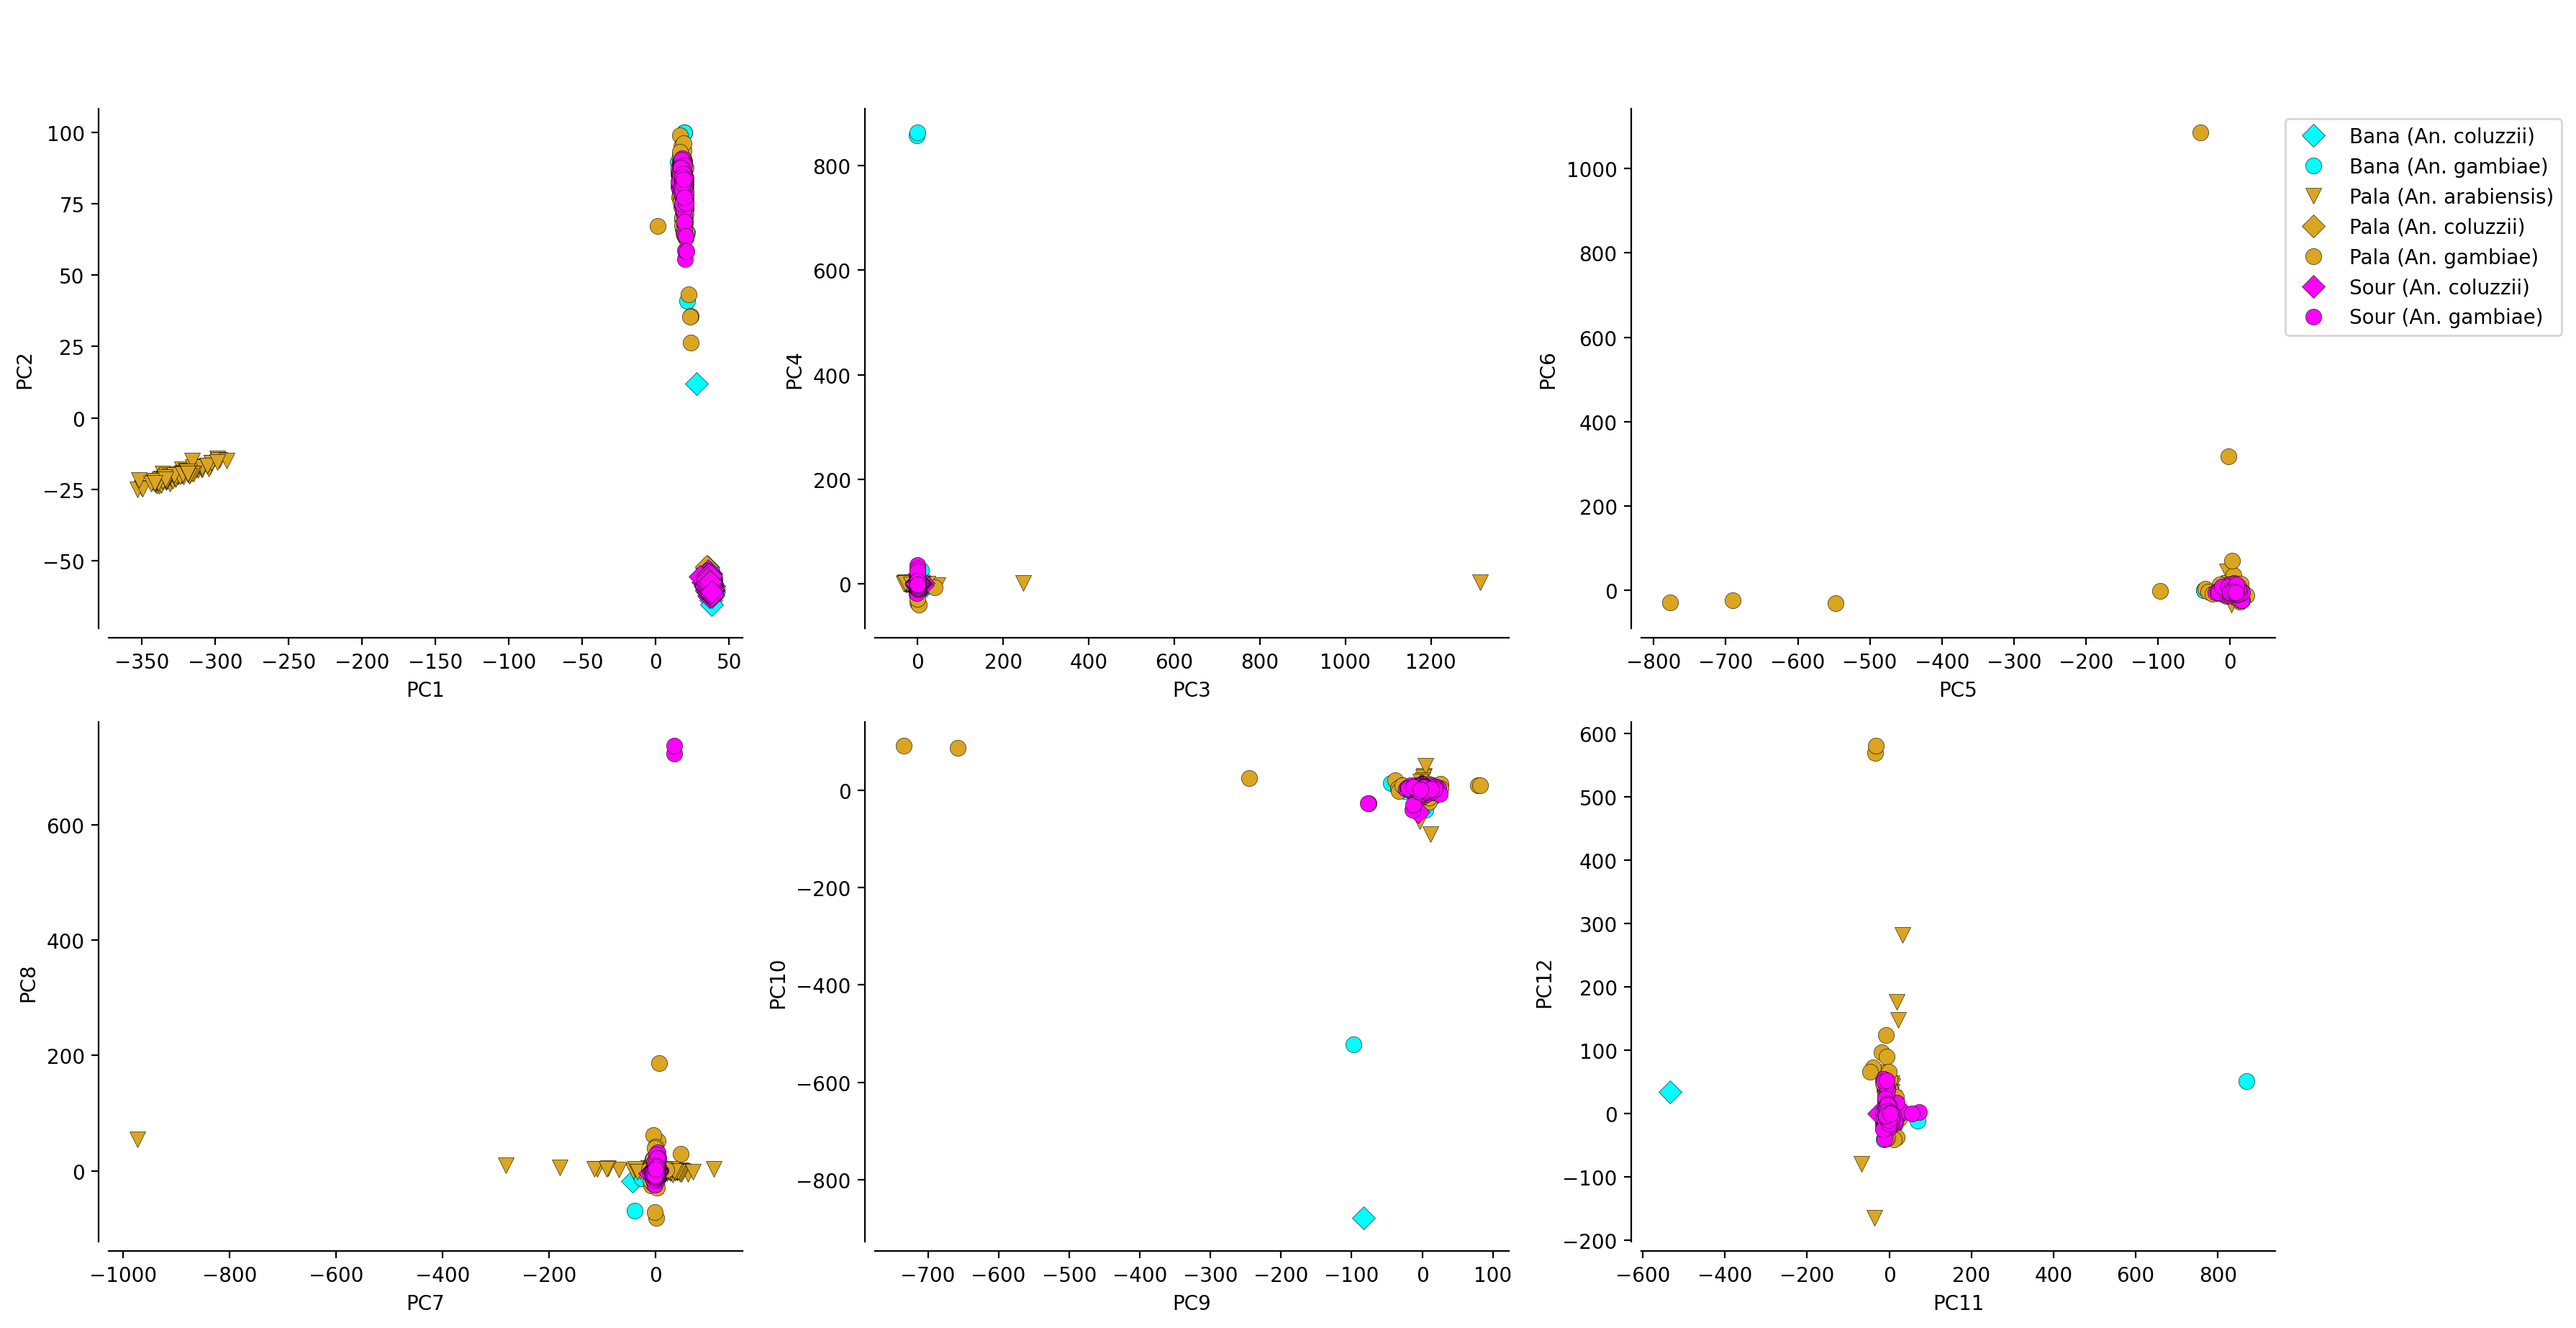

In [59]:
fig_pca(coords=coords_3L, model=model_3L.explained_variance_ratio_ , title=' ', ls=ls1, pop_id=pop_ids, pop_color=pop_color,
        sample_population=bf_samples.population.values, fig_name='3L_PCA')

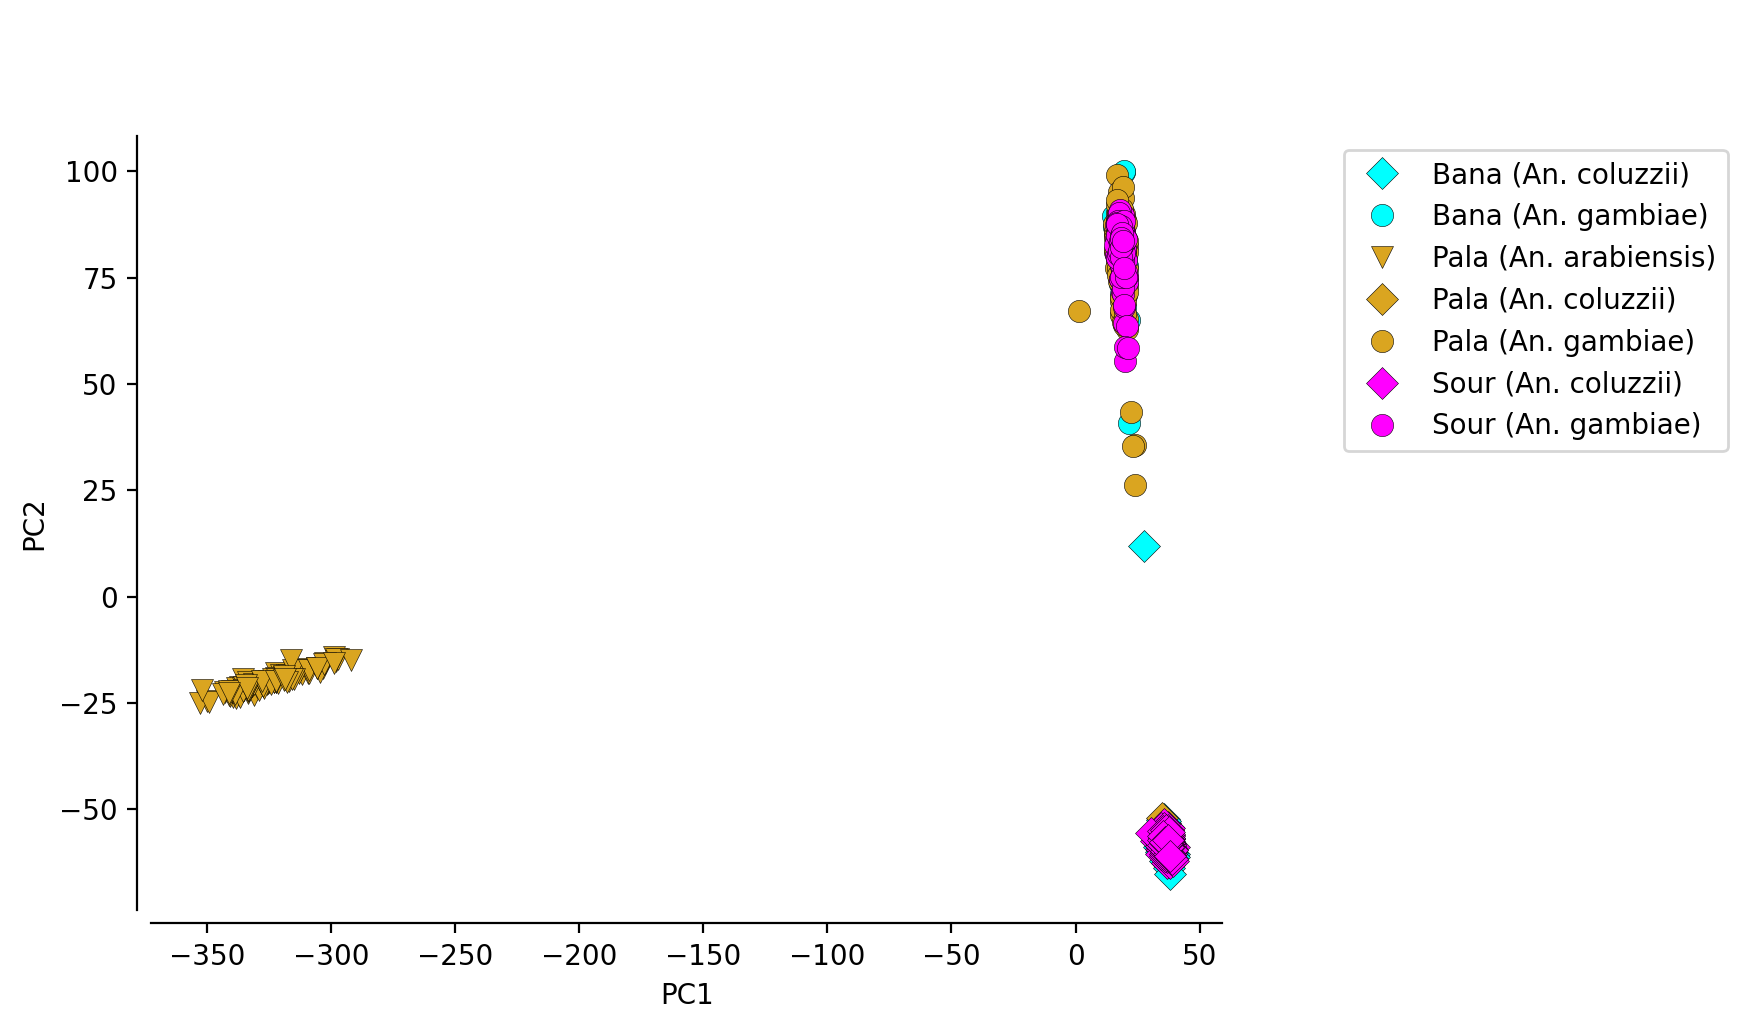

In [60]:
fig_pca1_2(coords=coords_3L, model=model_3L.explained_variance_ratio_ ,title=' ', ls=ls1, pop_id=pop_ids, pop_color=pop_color,
           sample_population=bf_samples.population.values)
plt.show()

In [30]:
coords_3L

array([[ 1.9954453e+01,  7.8665611e+01, -1.4725773e+00, ...,
        -3.4042873e+00,  6.8544815e+01, -1.4932350e+02],
       [ 1.8930628e+01,  7.5634041e+01, -2.2818863e+00, ...,
         6.6107535e-01,  1.2412288e+01, -1.9115910e+01],
       [ 1.8183437e+01,  7.4749794e+01, -3.1738800e-01, ...,
        -4.3326278e+00,  6.2067304e+00, -1.2281874e+01],
       ...,
       [ 1.8155008e+01,  8.4239738e+01, -1.1619240e+00, ...,
        -3.4203744e+00,  1.5660615e+01, -2.4412642e+01],
       [ 1.9052261e+01,  8.3649956e+01, -6.0228109e-01, ...,
        -7.6993990e-01, -7.3667431e+00, -3.4214914e+00],
       [ 3.5757042e+01, -5.5406261e+01, -1.4816568e+00, ...,
        -1.5048209e+00, -2.5066350e+00,  2.2427458e-03]], dtype=float32)

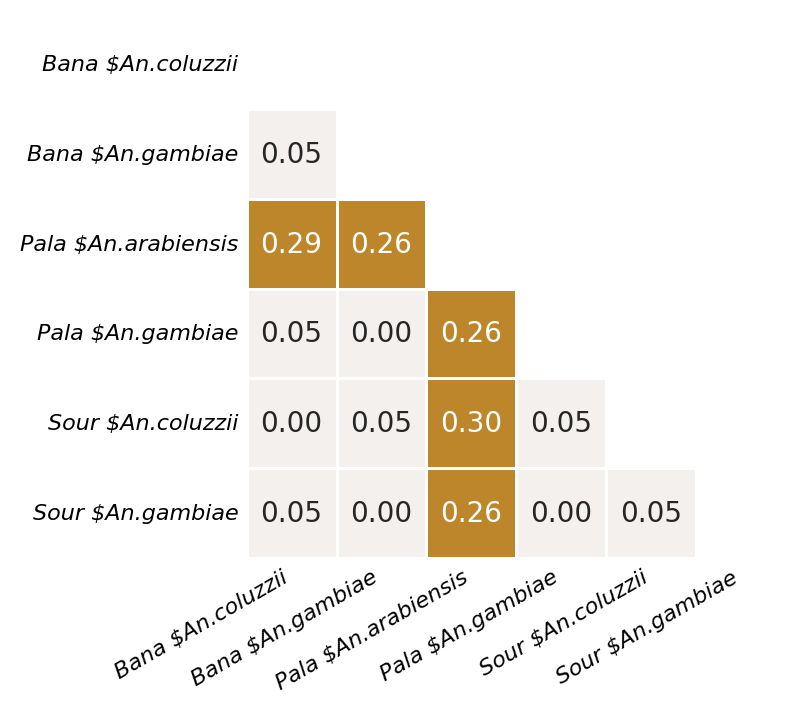

In [61]:
plot_pairwise_fst1(fst=fst_3L[0], figsize=(3.5, 3.5), pop_coh=sorted(pop_coh), pop_labels=pop_labels_Fst, xlabel=True, ylabel=True, chrom='3L',fs=8, fmt='.2f')

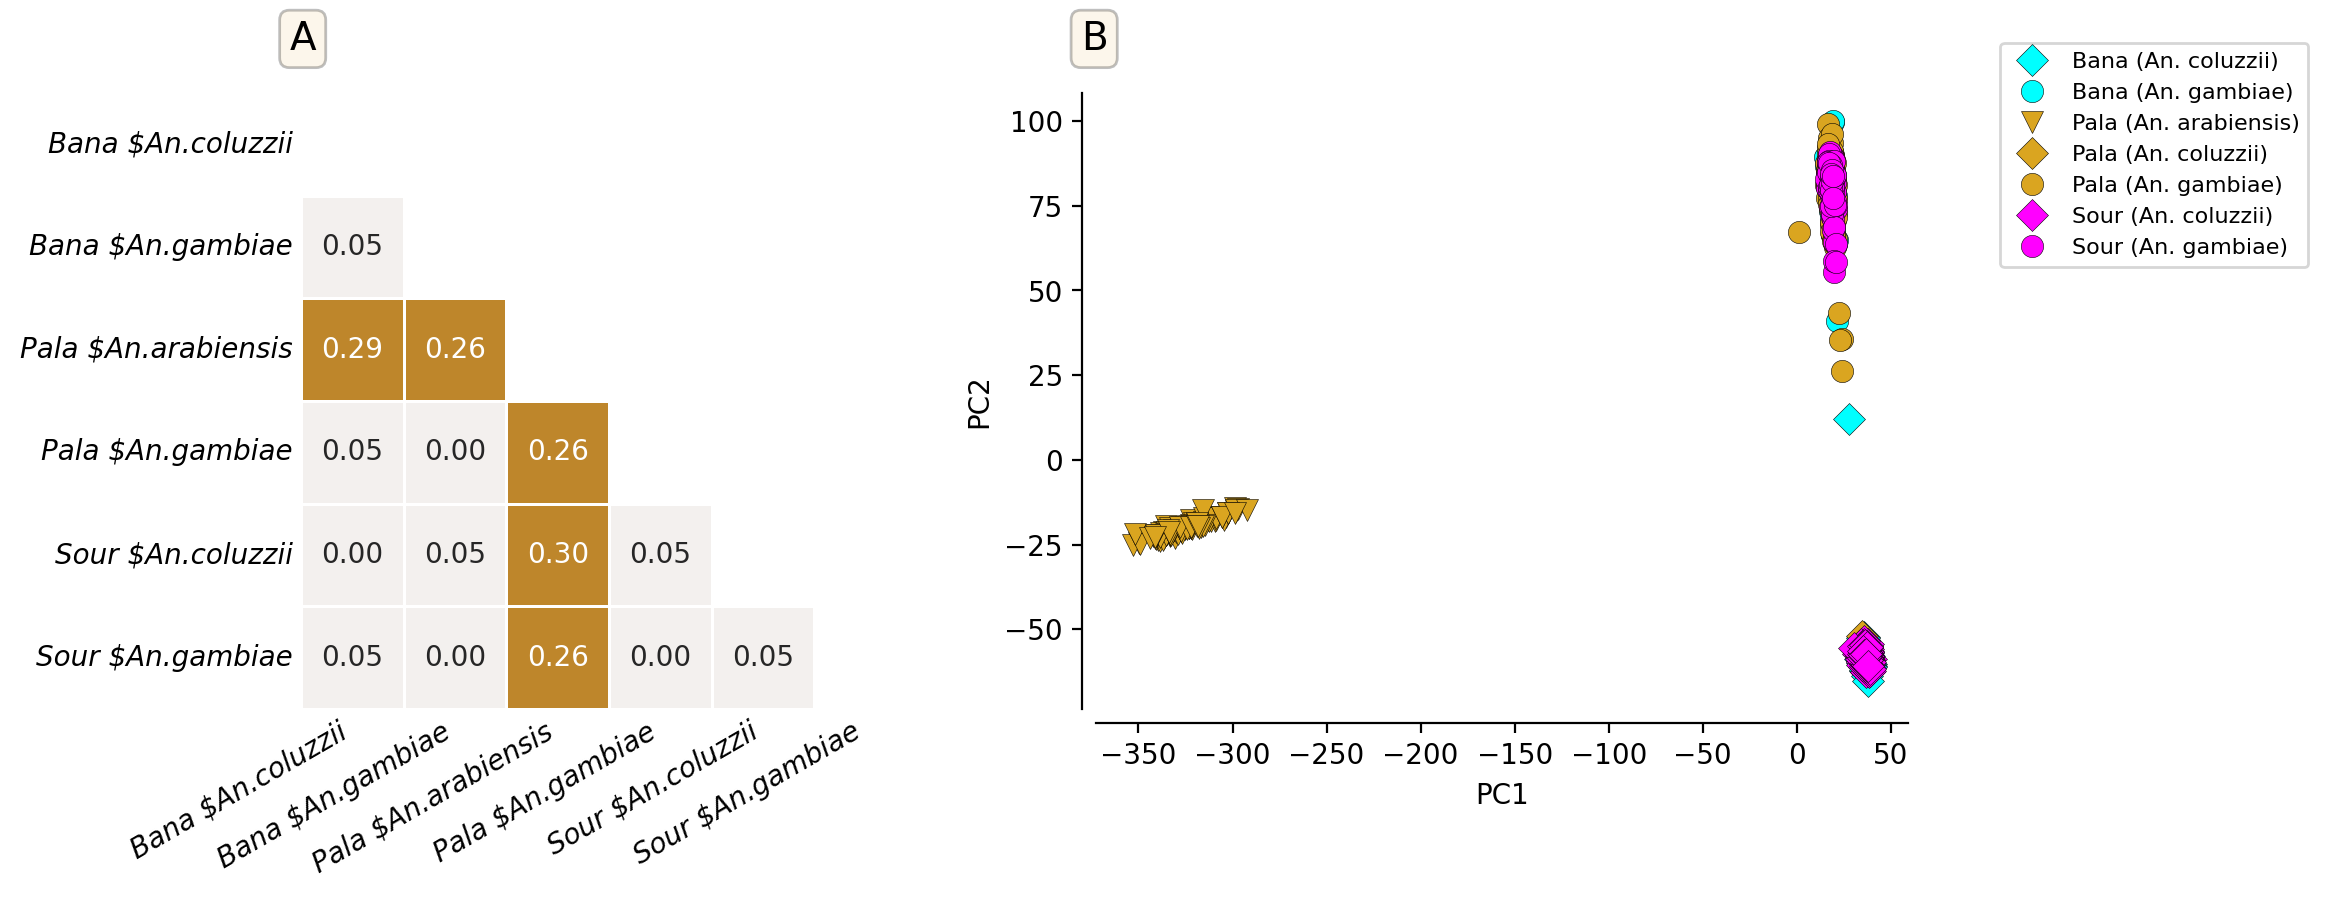

In [66]:
fig = plt.figure(figsize=(11, 4))

fig.subplots_adjust(wspace=0.1, hspace=0.5)
ax = fig.add_subplot(121)
plot_pairwise_fst1(fst=fst_3L[0], figsize=(3.5, 3.5), ax=ax, pop_coh=sorted(pop_coh), pop_labels=pop_labels_Fst, xlabel=True, ylabel=True, chrom='3L',fs=10, fmt='.2f')
ax.text(-0.019, 1.07, 'A', transform=ax.transAxes, size=14,
         bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

ax = fig.add_subplot(122)
plot_pca_coords(coords_3L, model_3L.explained_variance_ratio_, 0, 1, ax, ls1, pop_ids, pop_color, bf_samples.population.values)
ax.legend(bbox_to_anchor=(1.1, 1.1), loc='upper left', fontsize=8)
ax.text(-0.019, 1.07, 'B', transform=ax.transAxes, size=14,
        bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

fig.savefig(f"drive/MyDrive/Genomic/PCA/Fst_PCA_12.png", dpi=300, bbox_inches='tight', transparent=False)


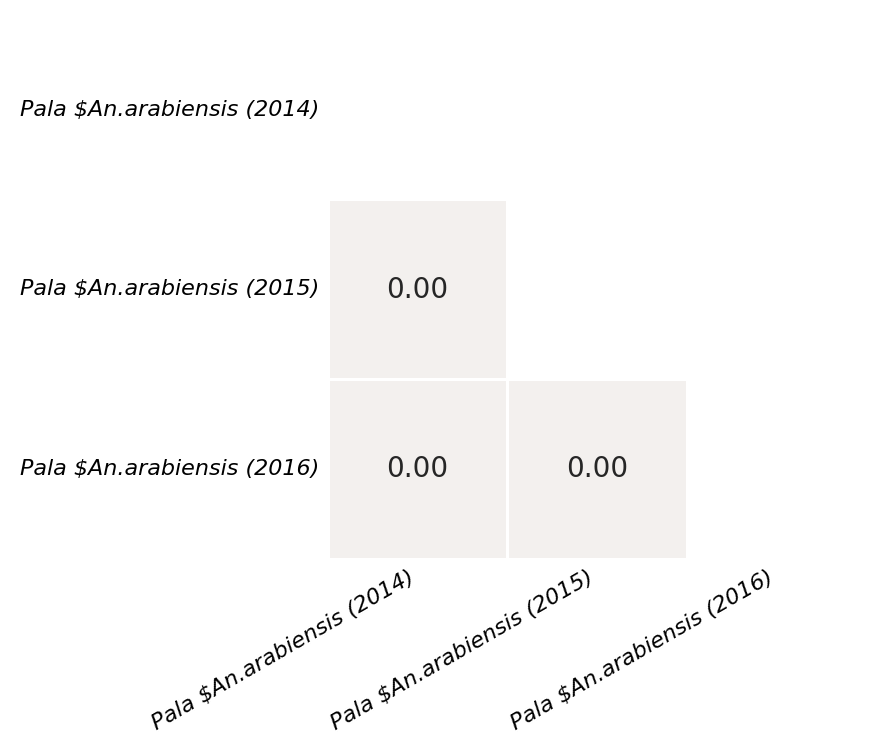

In [67]:
plot_pairwise_fst1(fst=fst_y_ara[0], figsize=(3.5, 3.5), pop_coh=sorted(pop_ara_year), pop_labels=dict((k, pop_labels_y_Fst[k]) for k in pop_ara_year),
                   xlabel=True, ylabel=True, chrom='3L',fs=8, fmt='.2f', fig_name='3L_y_Fst_ara')

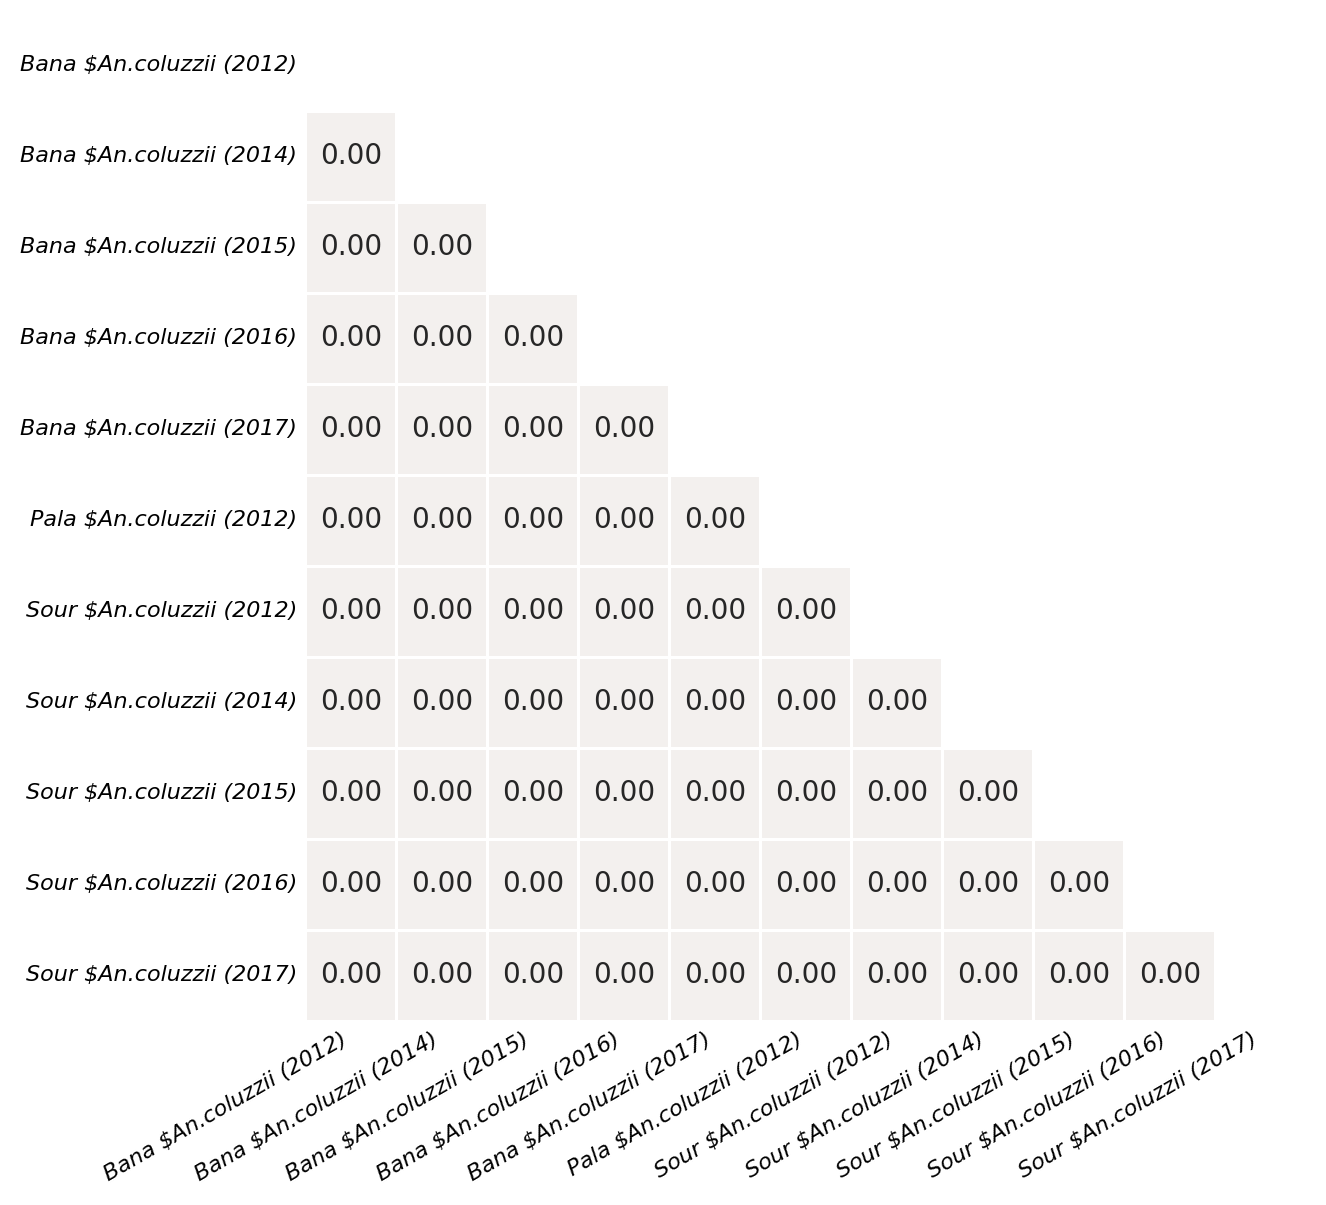

In [68]:
plot_pairwise_fst1(fst=fst_y_ac[0], figsize=(6.5, 6.5), pop_coh=sorted(pop_ac_year), pop_labels=dict((k, pop_labels_y_Fst[k]) for k in pop_ac_year),
                   xlabel=True, ylabel=True, chrom='3L',fs=8, fmt='.2f', fig_name='3L_y_Fst_ac')

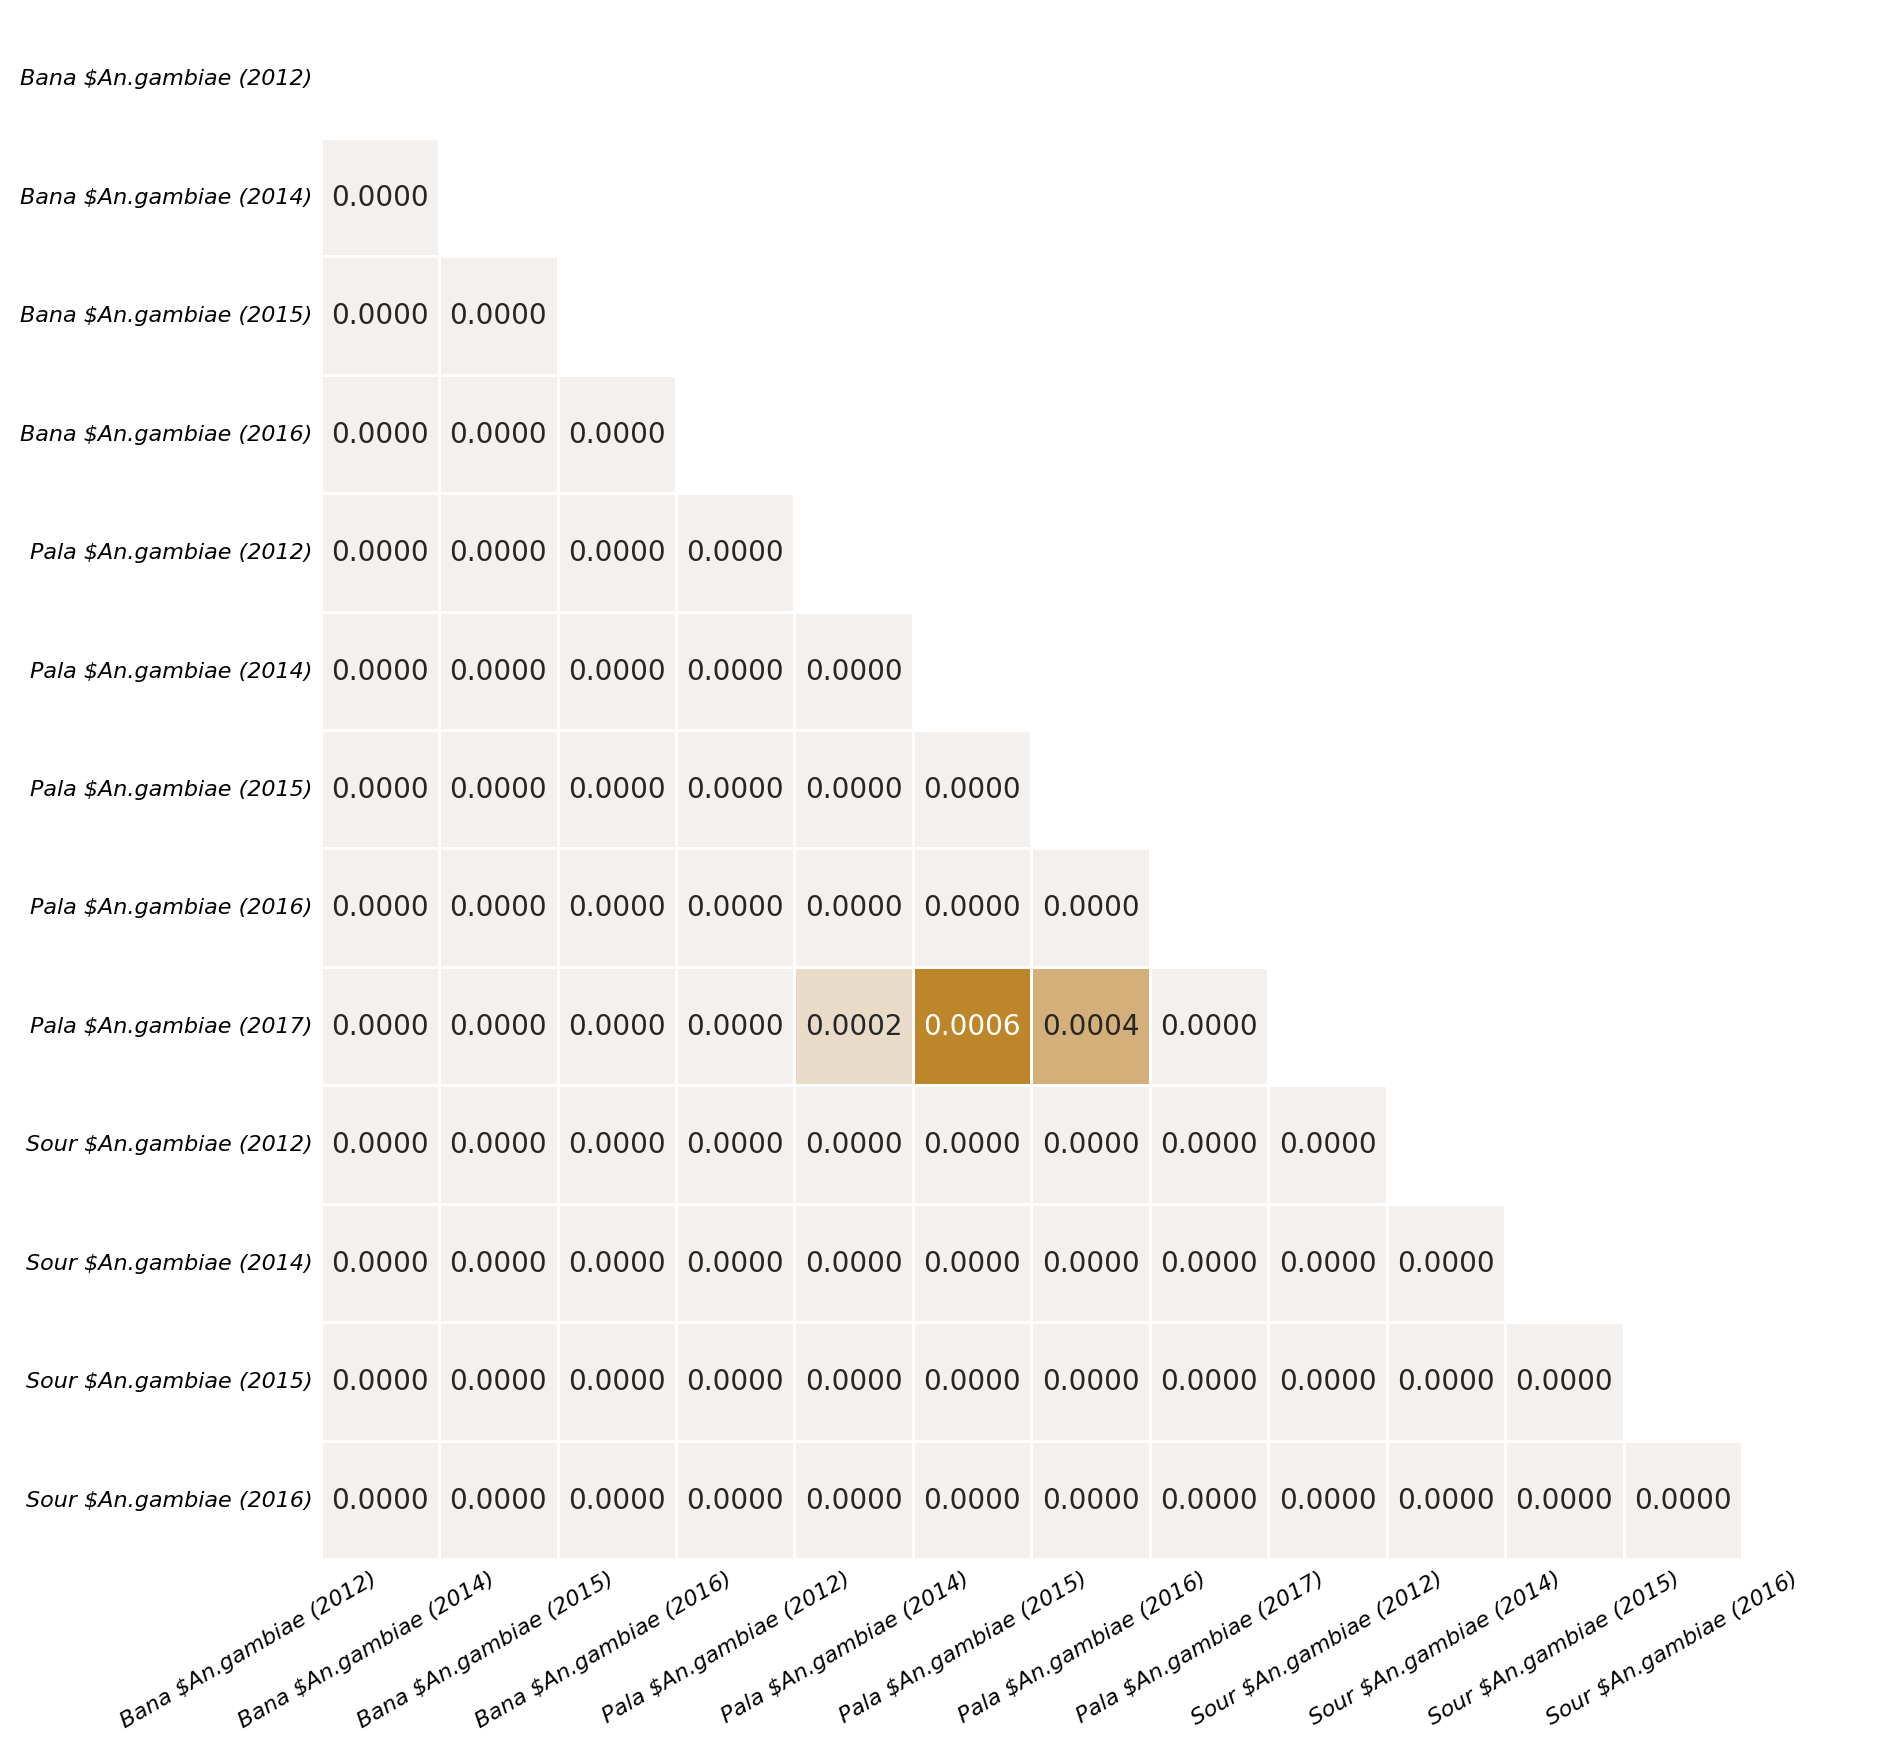

In [64]:
plot_pairwise_fst1(fst=fst_y_ag[0], figsize=(10, 10), pop_coh=sorted(pop_ag_year), pop_labels=dict((k, pop_labels_y_Fst[k]) for k in pop_ag_year),
                   xlabel=True, ylabel=True, chrom='3L',fs=8, fmt='.4f', fig_name='3L_y_Fst_ag')

# PCA 3L - An. coluzzii - year to year

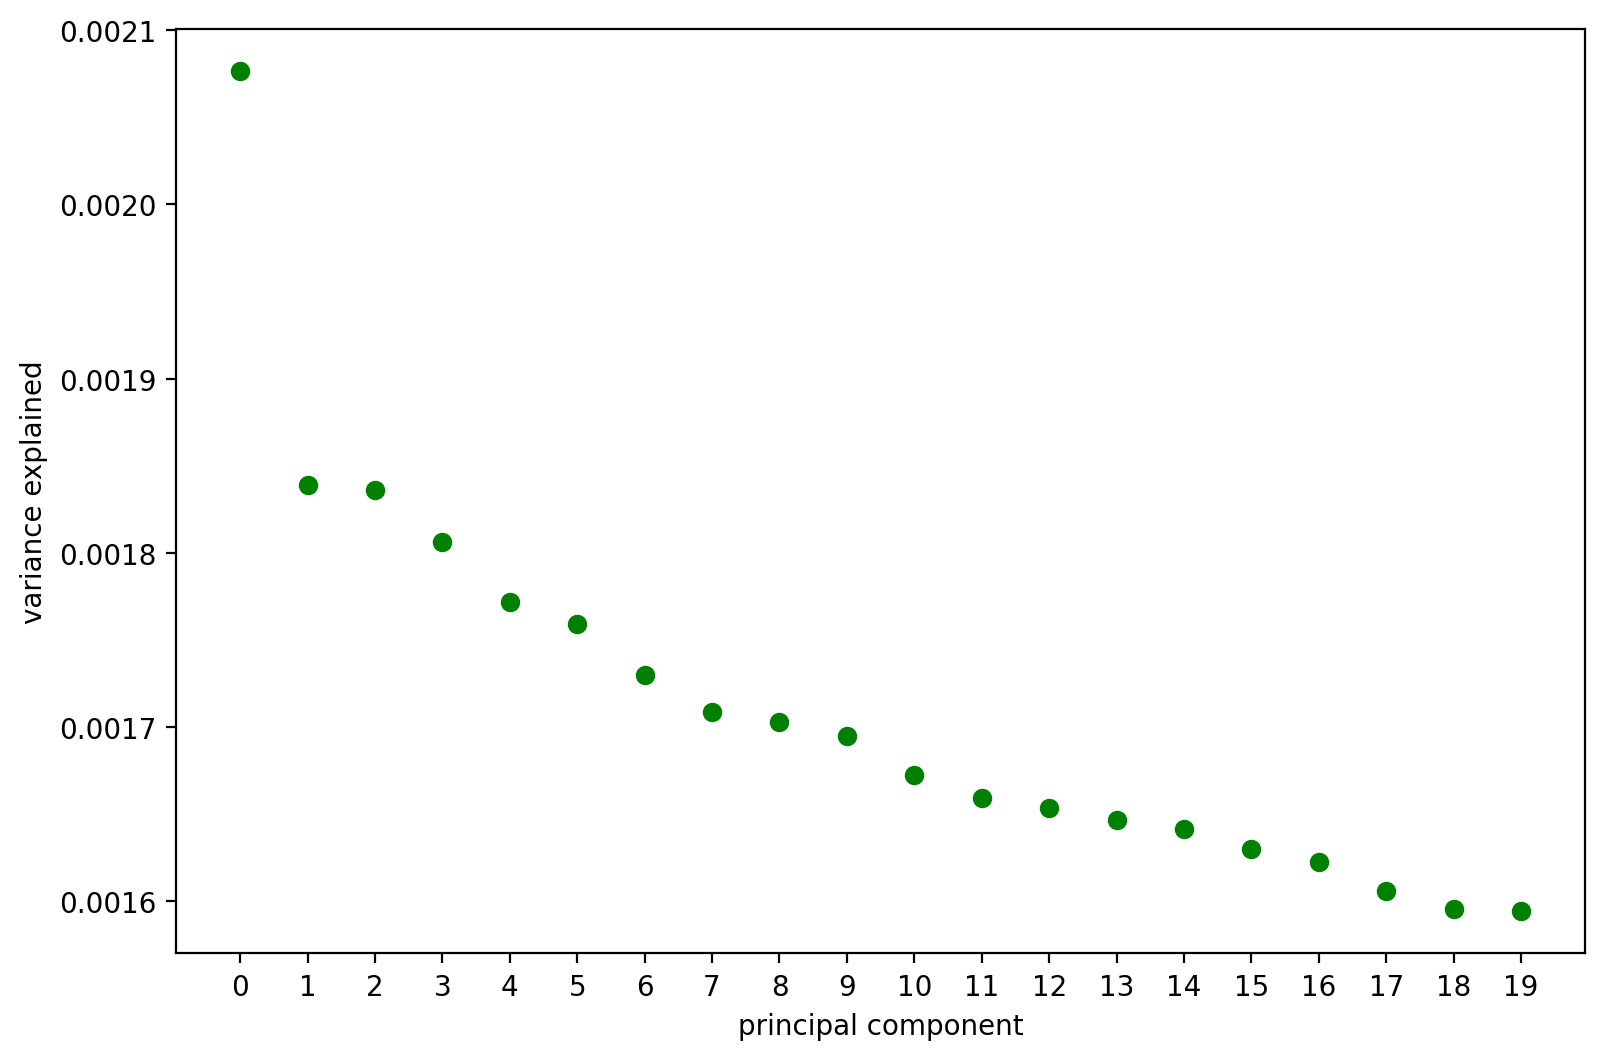

In [69]:
plot_variance(model_col)

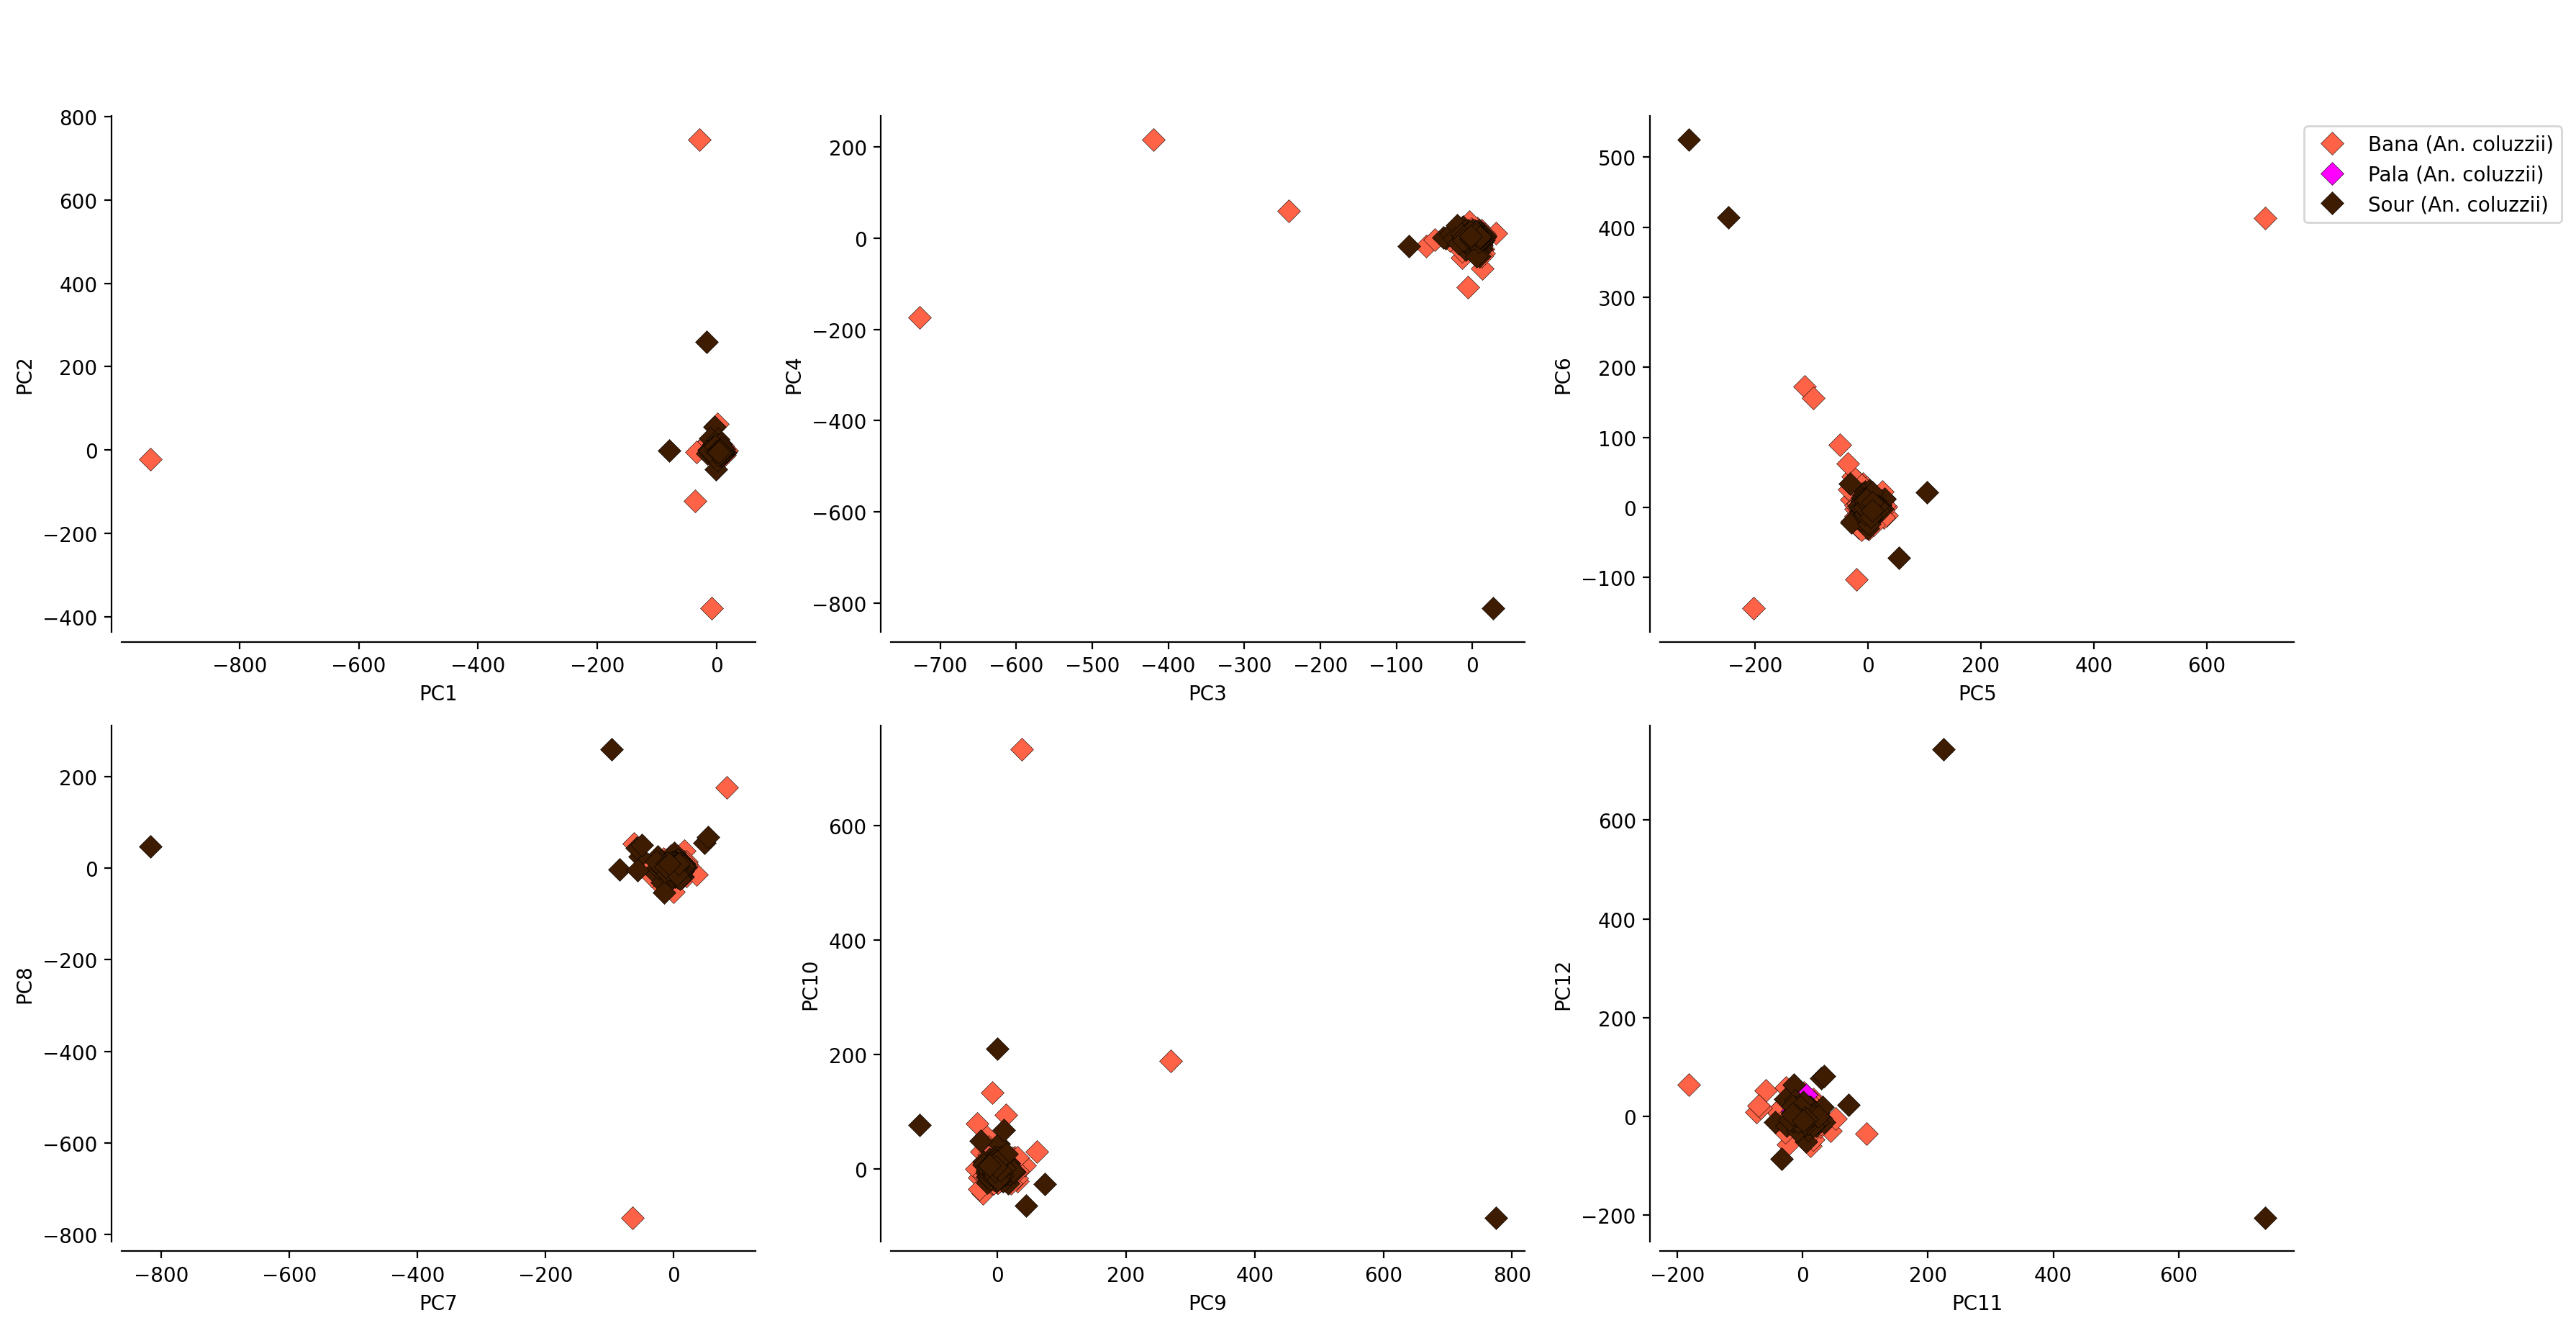

In [70]:
fig_pca(coords=coords_col, model=model_col.explained_variance_ratio_ , title=' ', ls=col_ls1, pop_id=col_pop_ids, pop_color=col_pop_color,
        sample_population=col_samples.population.values, fig_name='PCA_3L_An_coluzzii')

In [38]:
fig_pca(coords=coords_col, model=model_col.explained_variance_ratio_ , title=' ', ls=col_ls2, pop_id=col_pop_ids1, pop_color=col_pop_color1,
        sample_population=col_samples.pop_year.values, fig_name='PCA_3L_An_coluzzii_y')

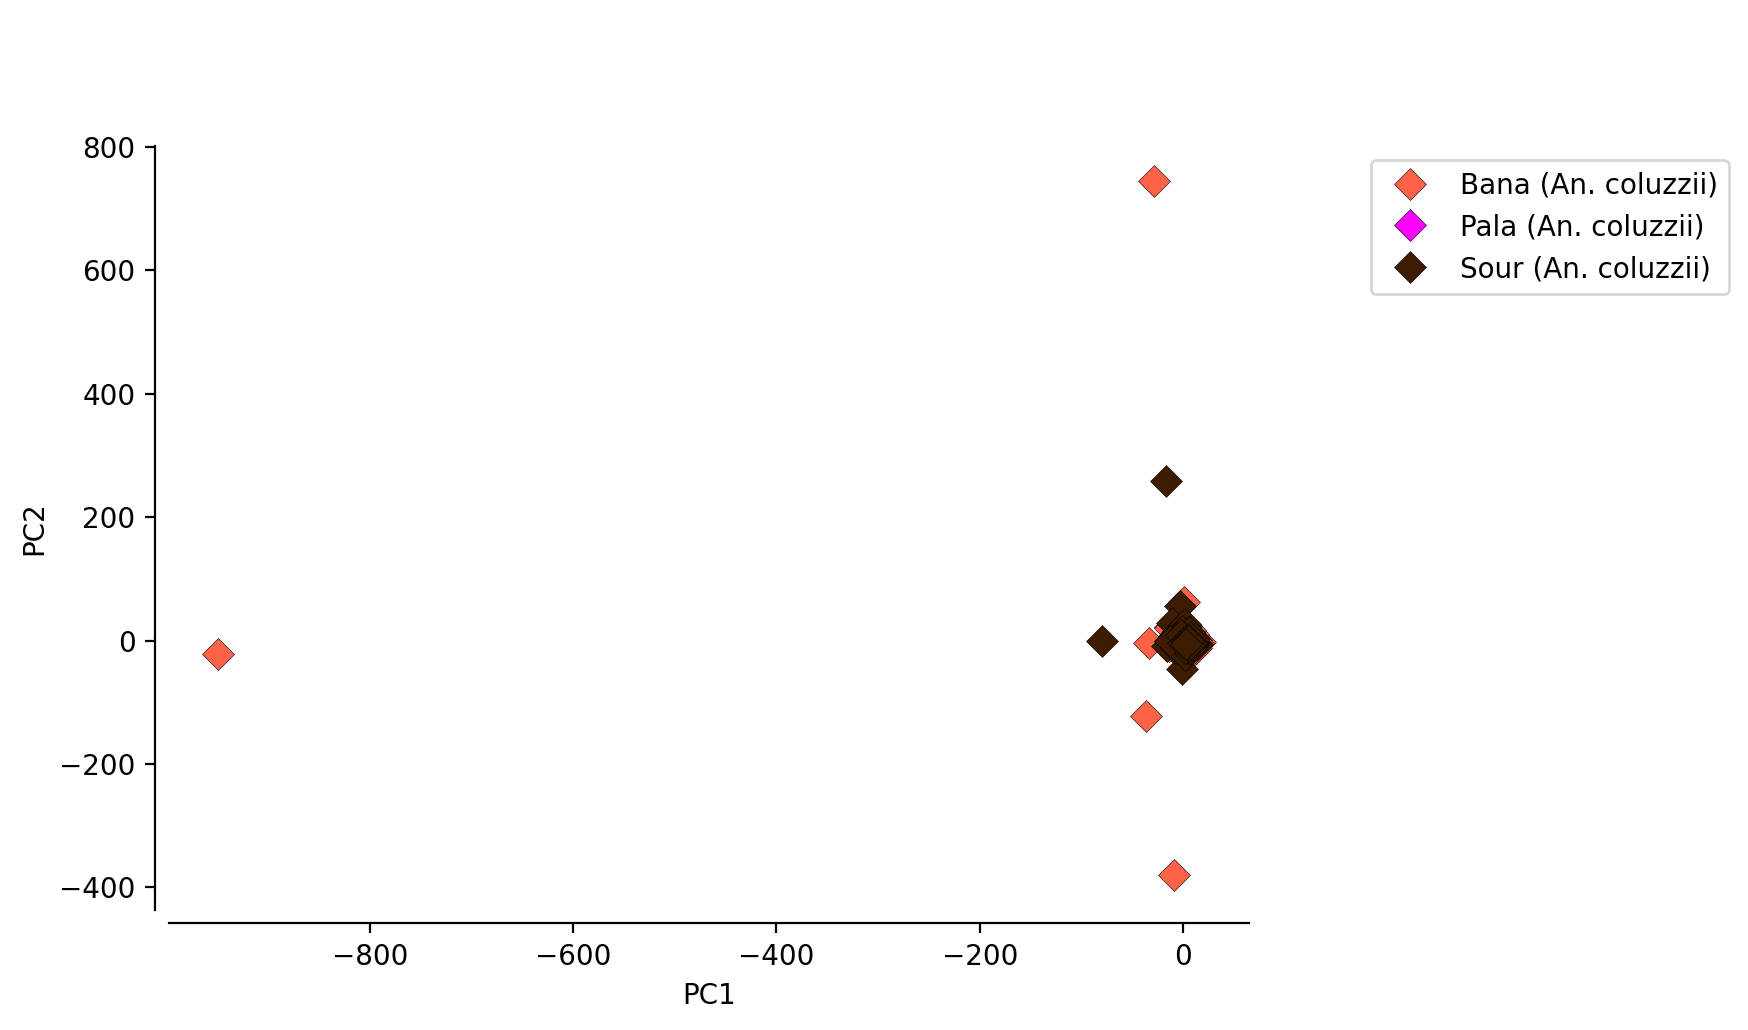

In [71]:
fig_pca1_2(coords=coords_col, model=model_col.explained_variance_ratio_ , title=' ', ls=col_ls1, pop_id=col_pop_ids,
           pop_color=col_pop_color, sample_population=col_samples.population.values, fig_name='PCA1,2_3L_An_coluzzii')

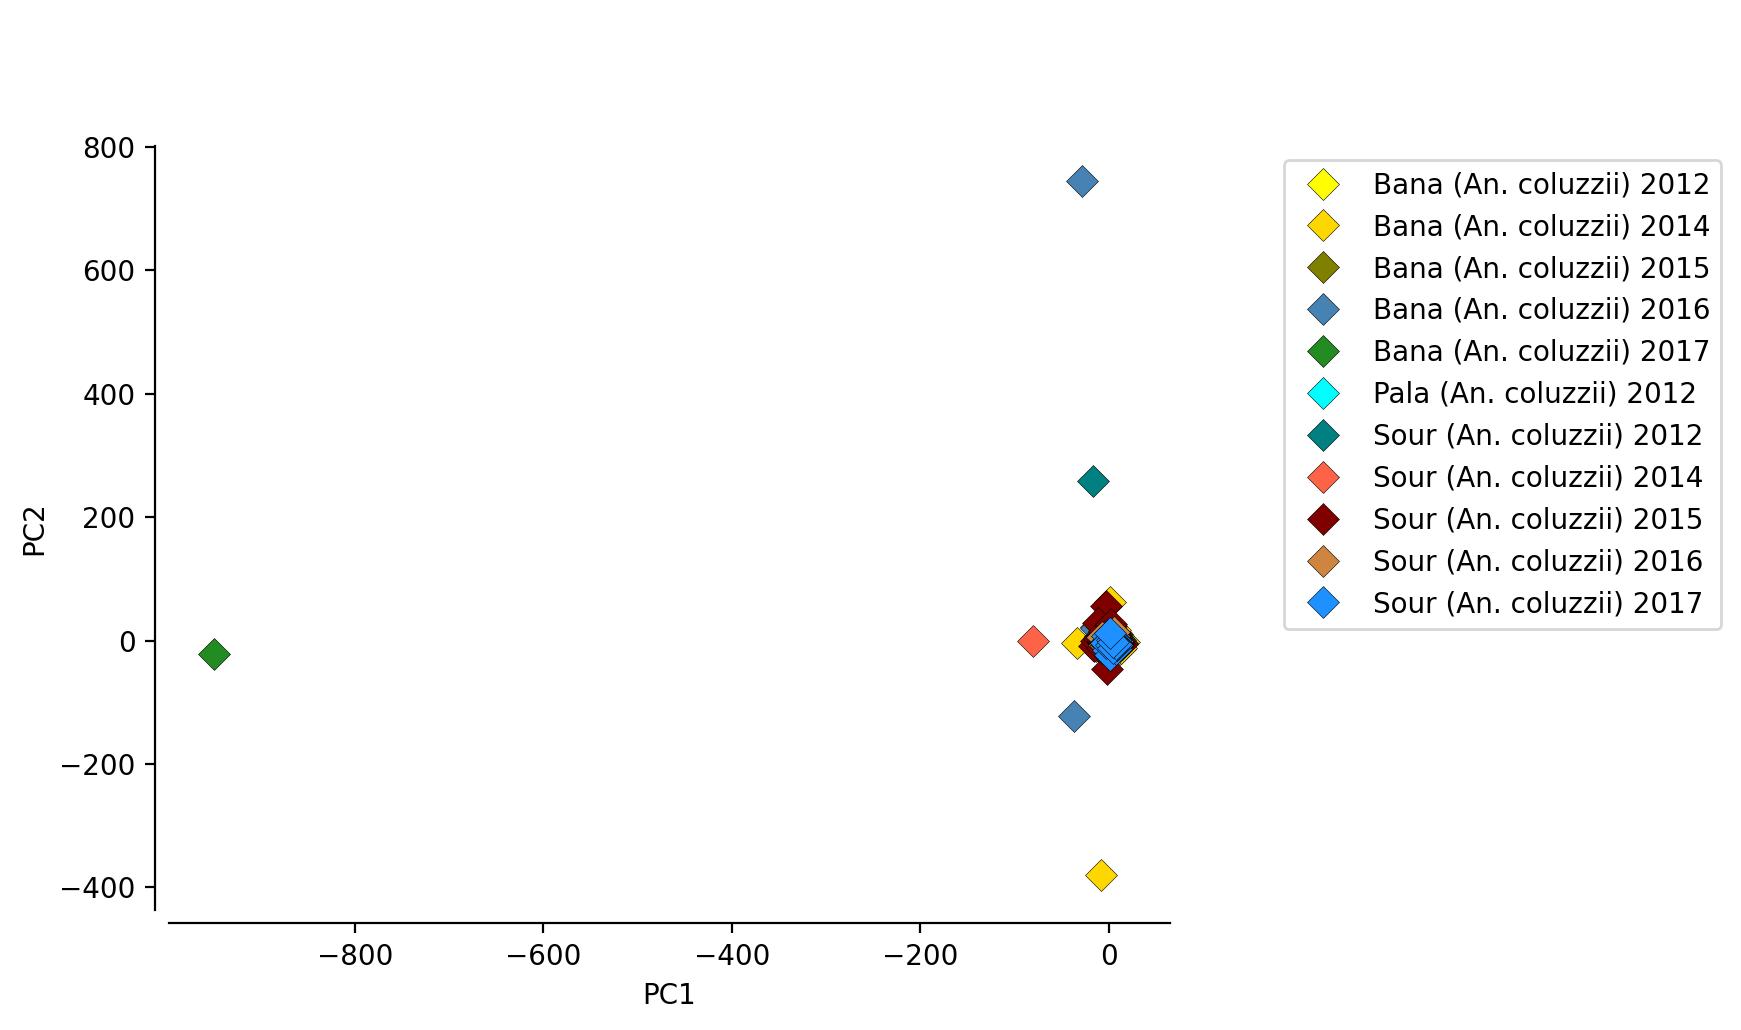

In [72]:
fig_pca1_2(coords=coords_col, model=model_col.explained_variance_ratio_ , title=' ', ls=col_ls2, pop_id=col_pop_ids1,
           pop_color=col_pop_color1, sample_population=col_samples.pop_year.values, fig_name='PCA1,2_3L_An_coluzzii_y')

Text(-0.019, 1.07, 'B')

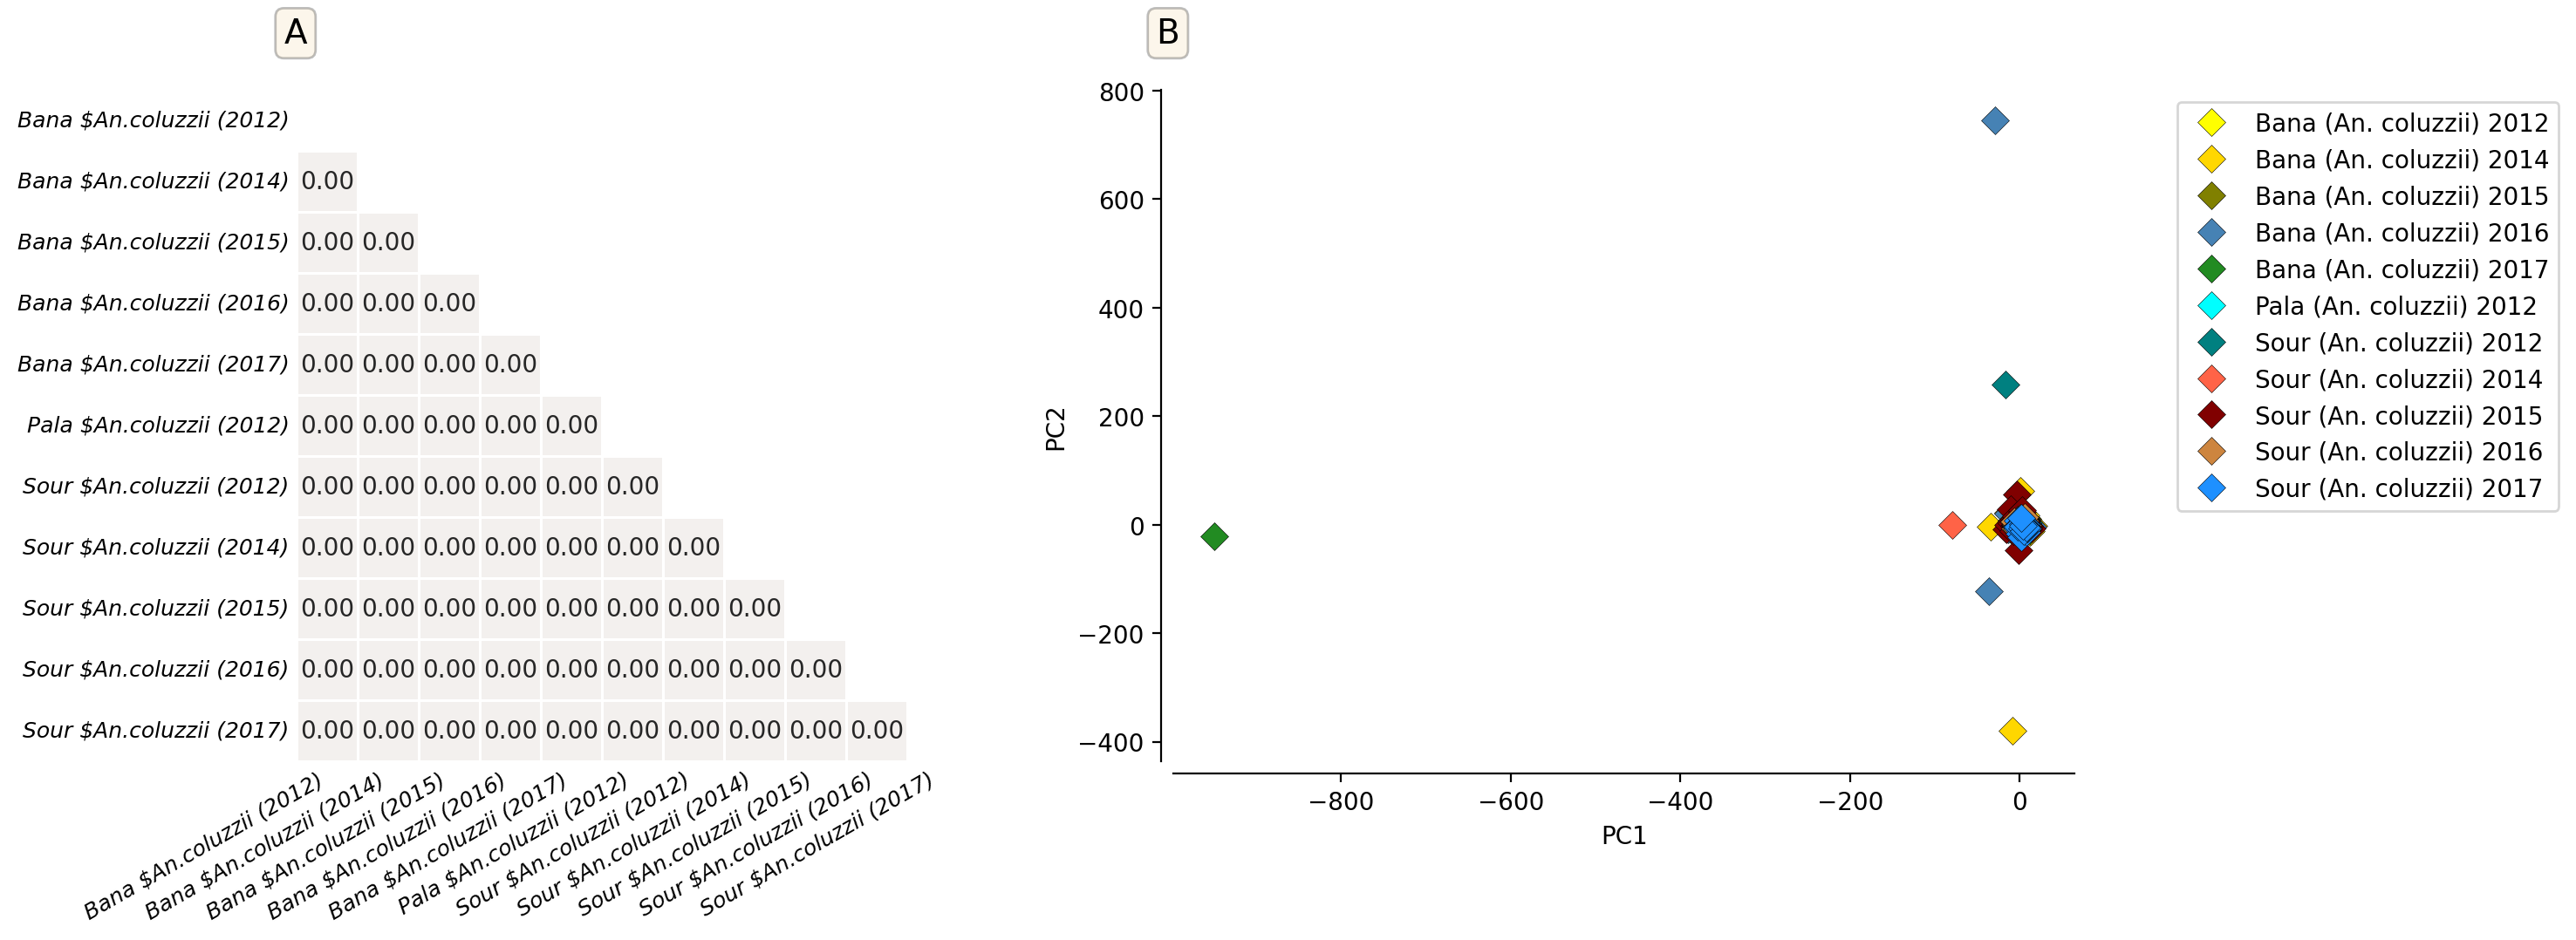

In [73]:
fig = plt.figure(figsize=(14, 5))

fig.subplots_adjust(wspace=0.1, hspace=0.5)
ax = fig.add_subplot(121)
plot_pairwise_fst1(fst=fst_y_ac[0],  pop_coh=sorted(pop_ac_year), pop_labels=dict((k, pop_labels_y_Fst[k]) for k in pop_ac_year),
                   ax= ax, xlabel=True, ylabel=True, chrom='3L',fs=9, fmt='.2f')
ax.text(-0.019, 1.07, 'A', transform=ax.transAxes, size=14,
         bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

ax = fig.add_subplot(122)
plot_pca_coords(coords_col, model_col.explained_variance_ratio_, 0, 1, ax, col_ls2, col_pop_ids1, col_pop_color1,
                col_samples.pop_year.values)
ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
ax.text(-0.019, 1.07, 'B', transform=ax.transAxes, size=14,
        bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

#fig.savefig(f"drive/MyDrive/Genomic/PCA/Fst_PCA_y_ac_12.png", dpi=300, bbox_inches='tight', transparent=False)

# PCA 3L - An. gambiae

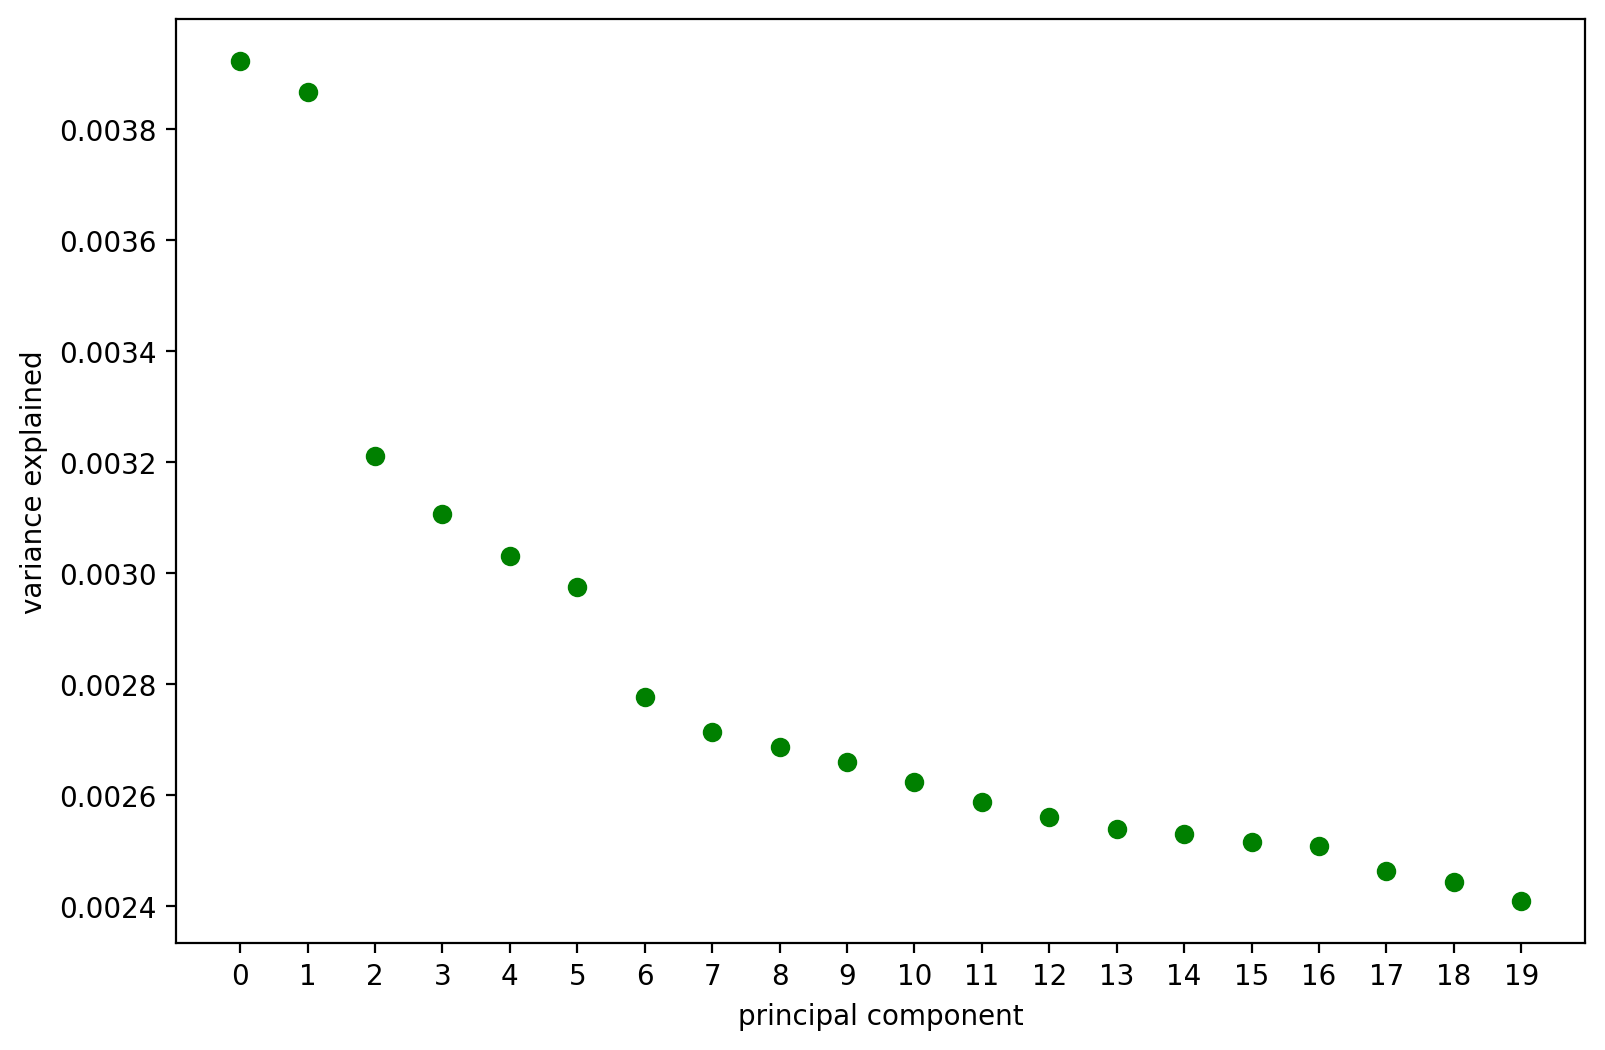

In [74]:
plot_variance(model_gamb)

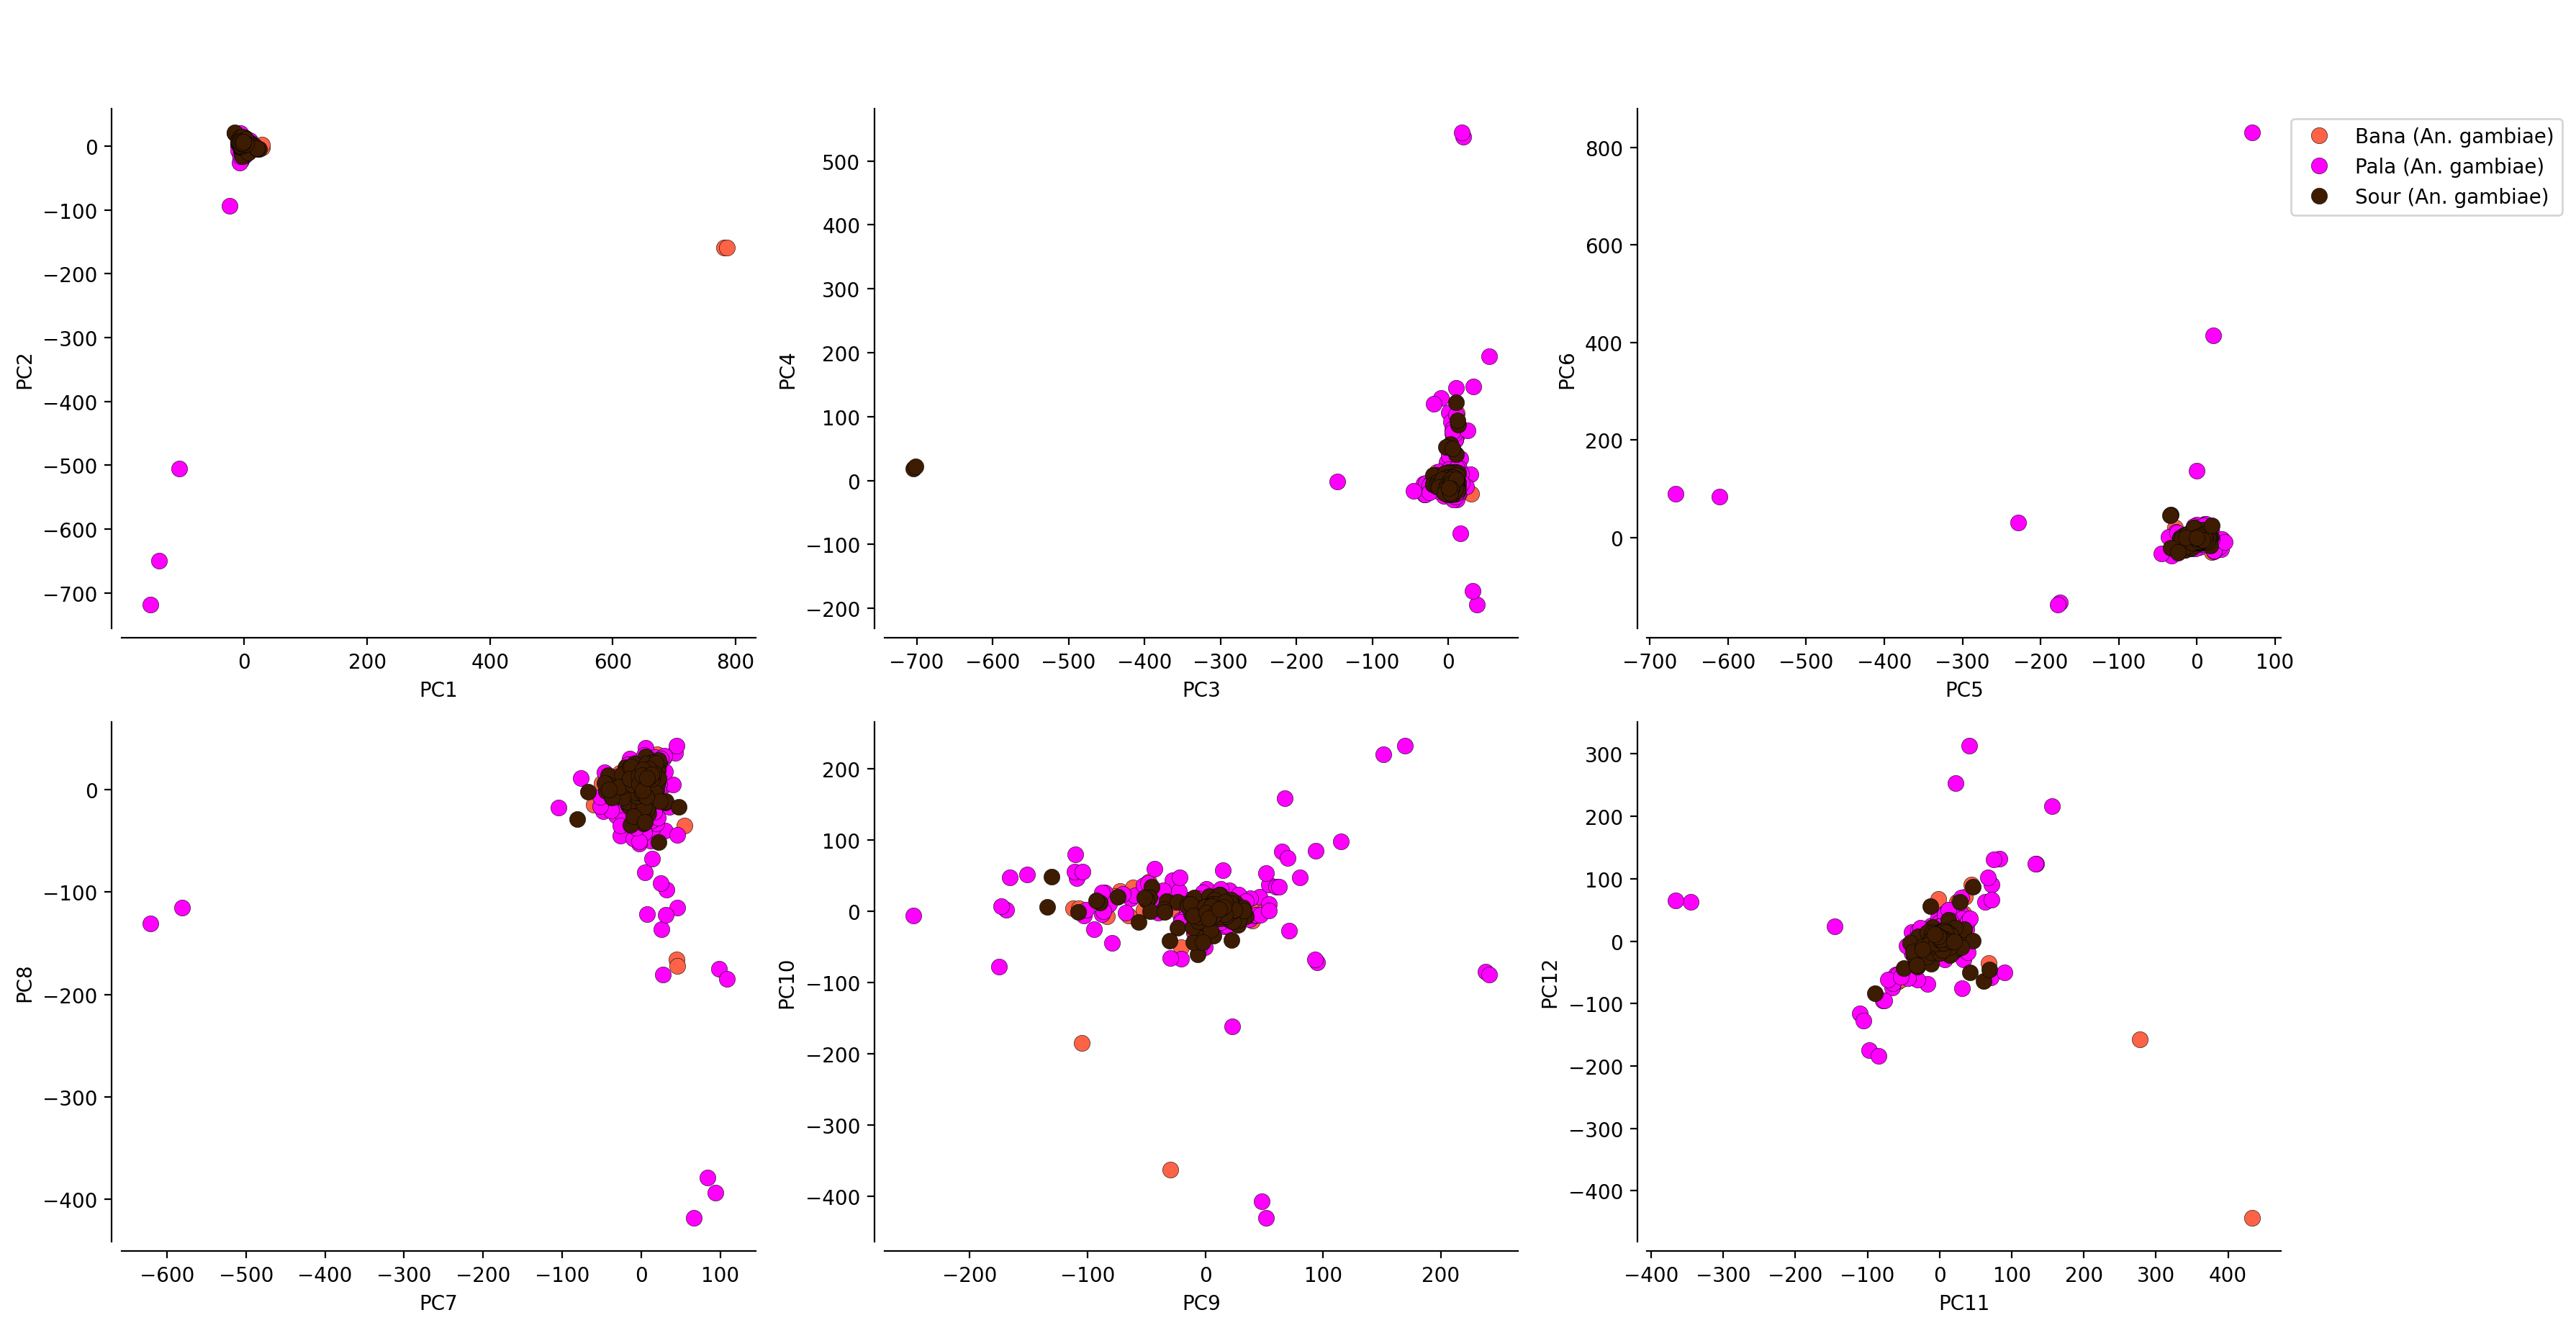

In [75]:
fig_pca(coords=coords_gamb, model=model_gamb.explained_variance_ratio_ , title=' ', ls=gam_ls1, pop_id=gam_pop_ids, pop_color=gam_pop_color,
        sample_population=gam_samples.population.values, fig_name='PCA_3L_An_gambiae')

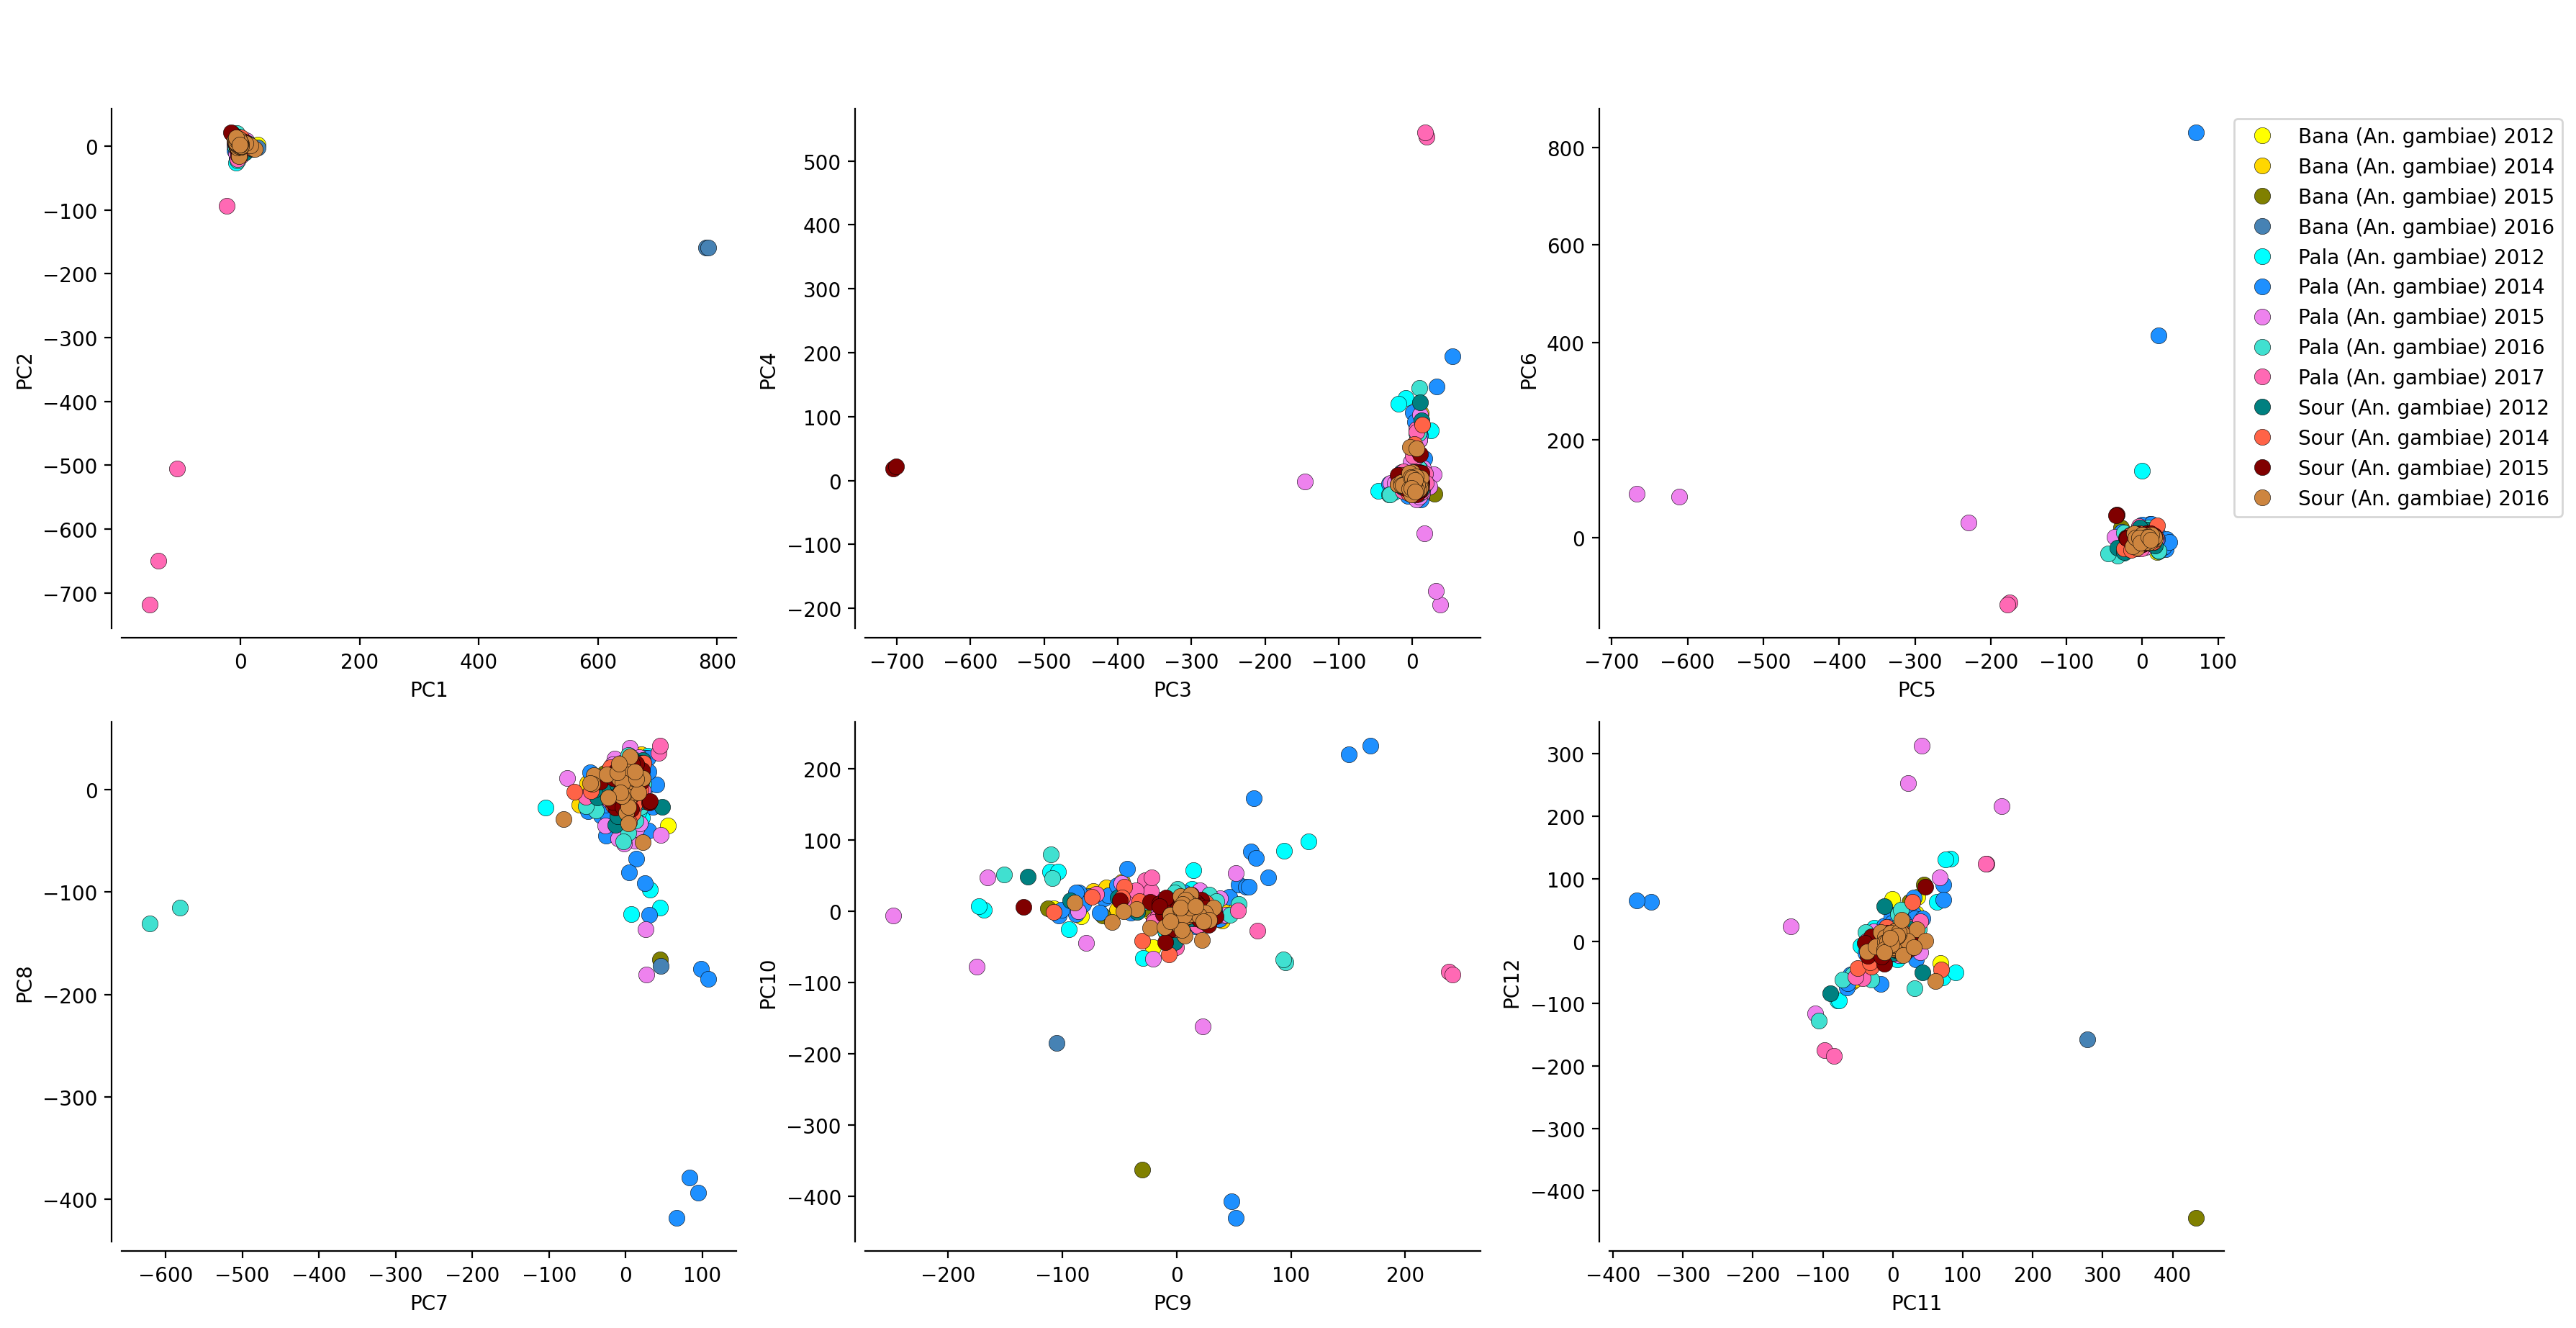

In [76]:
fig_pca(coords=coords_gamb, model=model_gamb.explained_variance_ratio_ , title=' ', ls=gam_ls2, pop_id=gam_pop_ids1, pop_color=gam_pop_color1,
        sample_population=gam_samples.pop_year.values, fig_name='PCA_3L_An_gambiae_y')

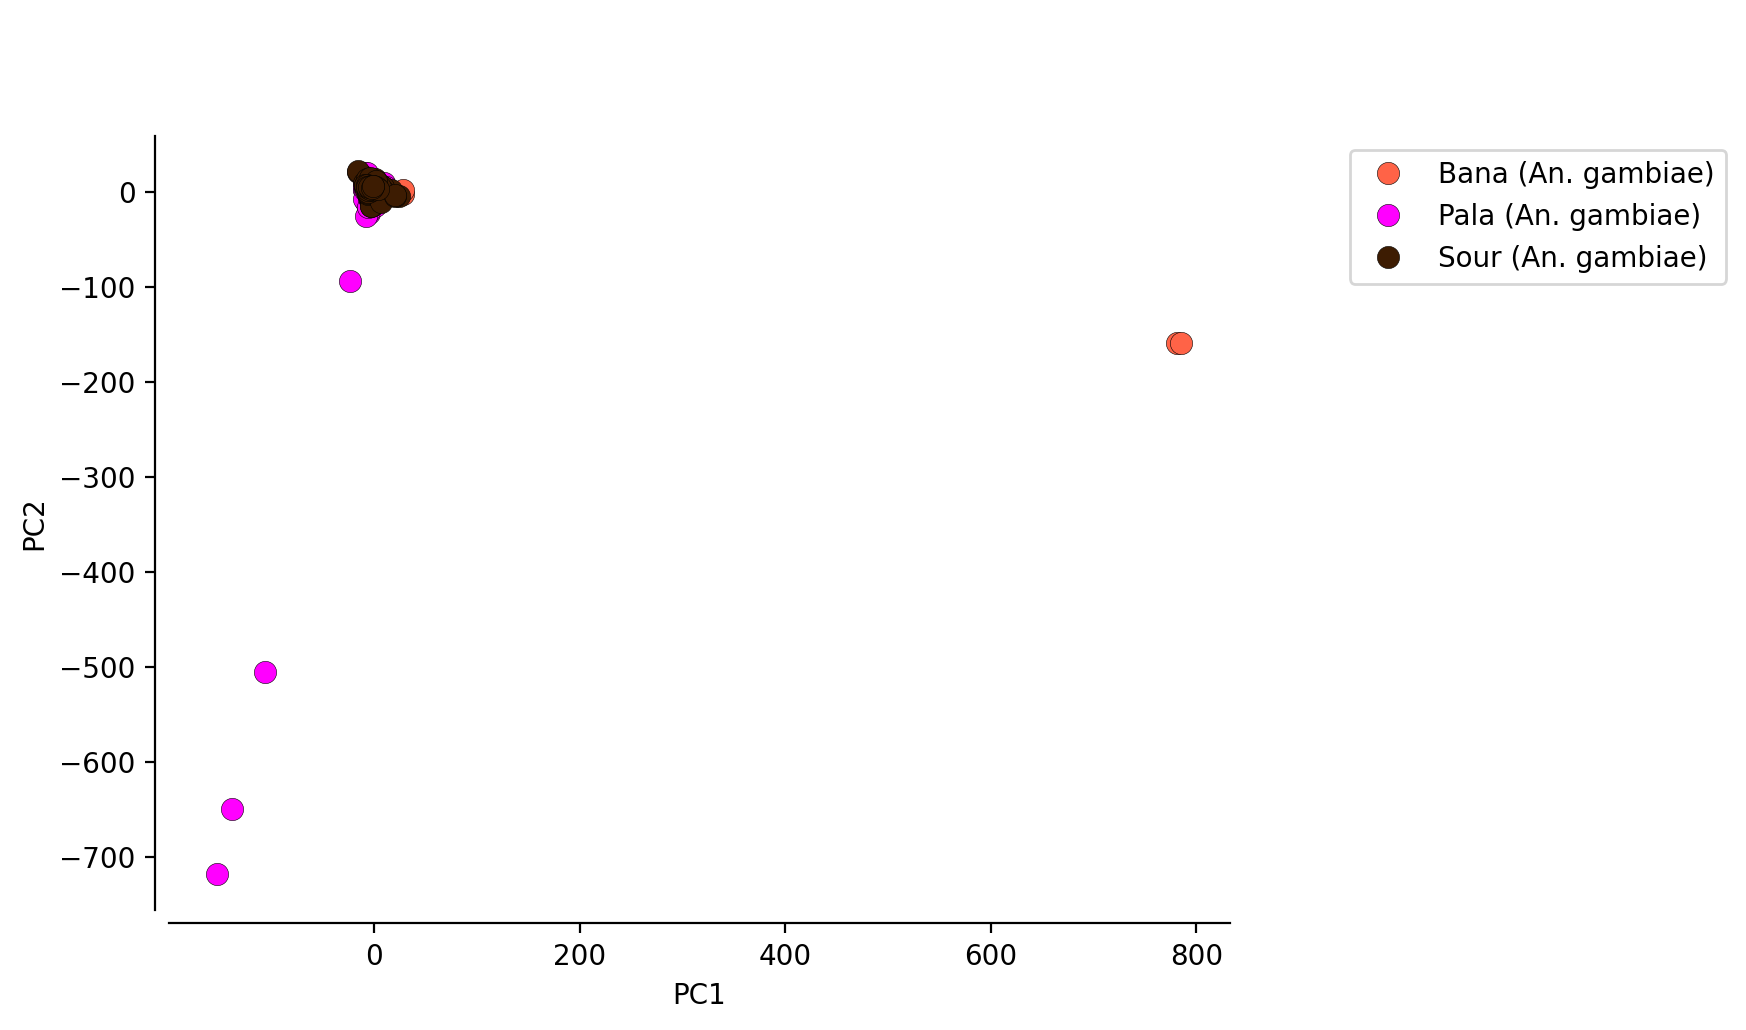

In [77]:
fig_pca1_2(coords=coords_gamb, model=model_gamb.explained_variance_ratio_ , title=' ', ls=gam_ls1, pop_id=gam_pop_ids,
           pop_color=gam_pop_color, sample_population=gam_samples.population.values, fig_name='PCA1,2_3L_An_gambiae')

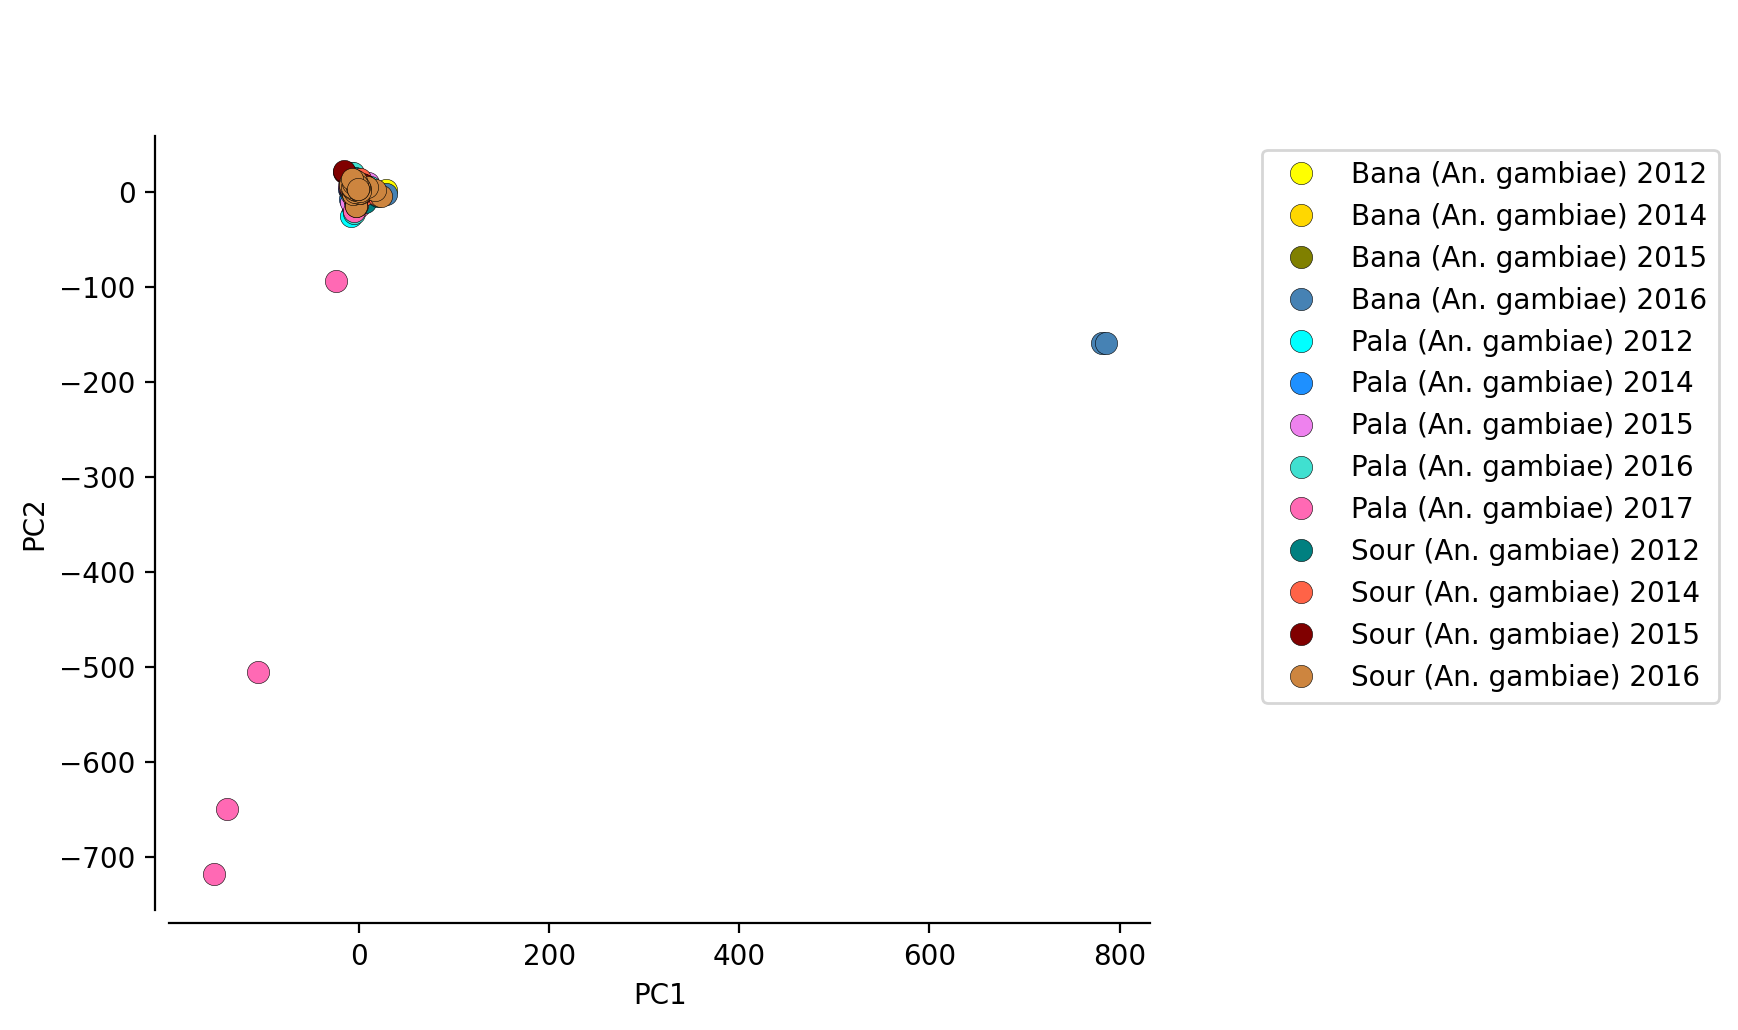

In [78]:
fig_pca1_2(coords=coords_gamb, model=model_gamb.explained_variance_ratio_ , title=' ', ls=gam_ls2, pop_id=gam_pop_ids1,
           pop_color=gam_pop_color1, sample_population=gam_samples.pop_year.values, fig_name='PCA1,2_3L_An_gambiae_y')

# PCA 3L - An. arabiensis

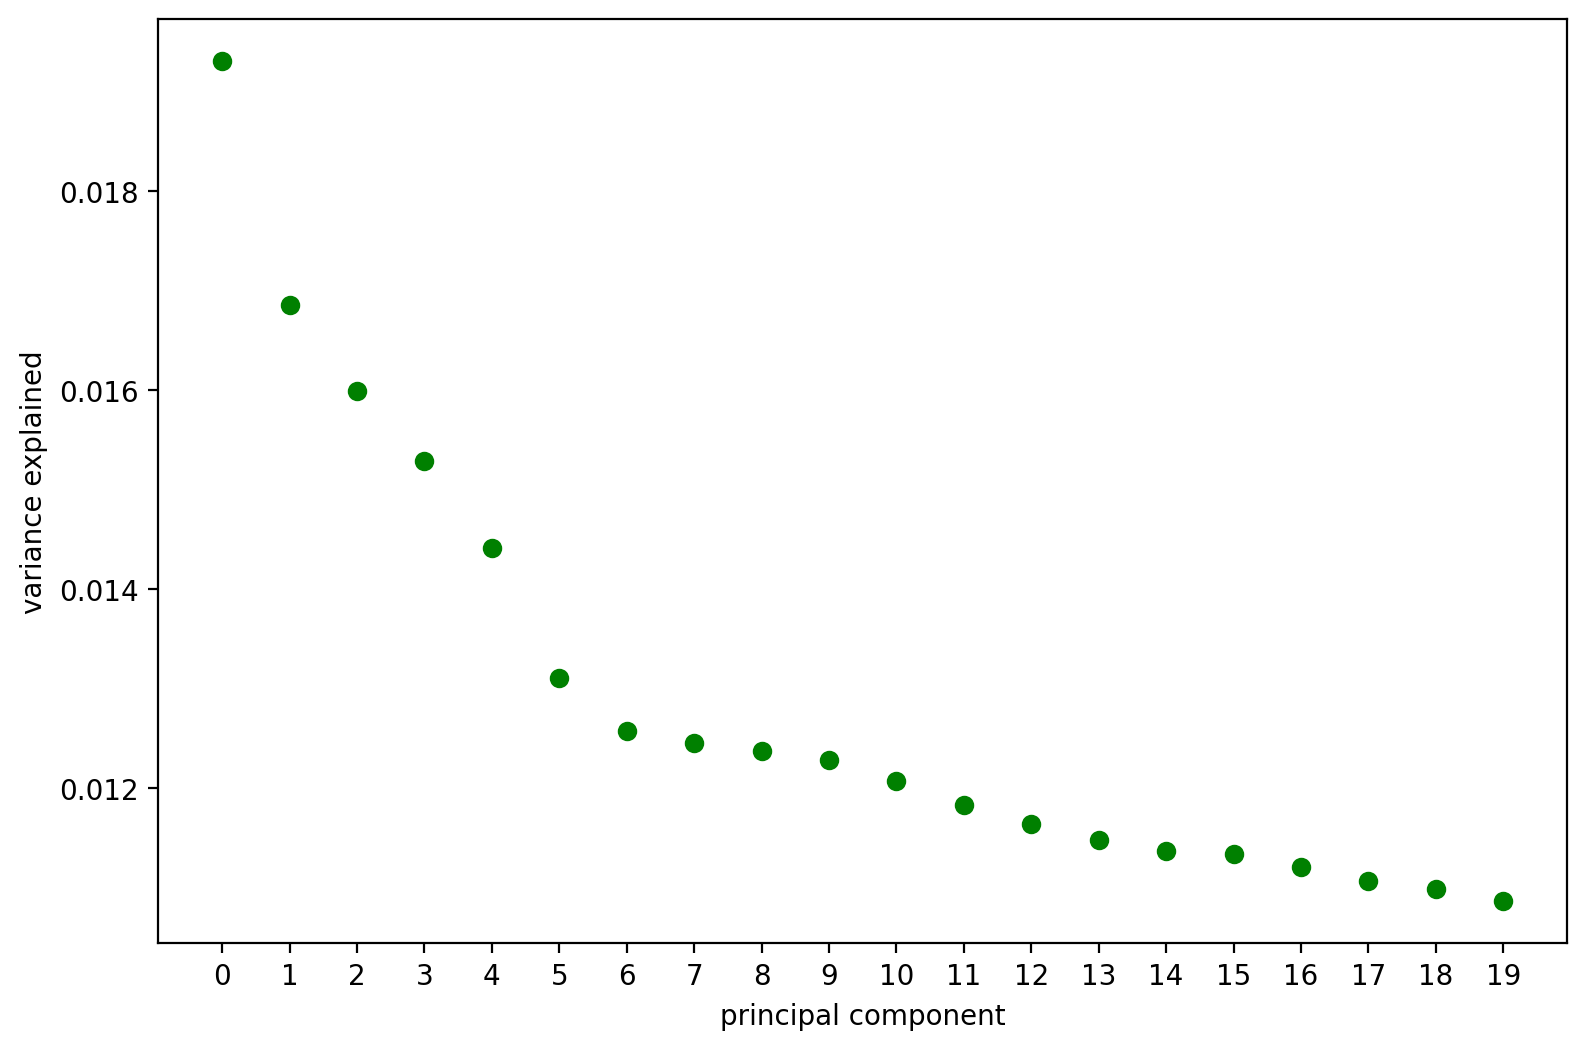

In [79]:
plot_variance(model_ara)

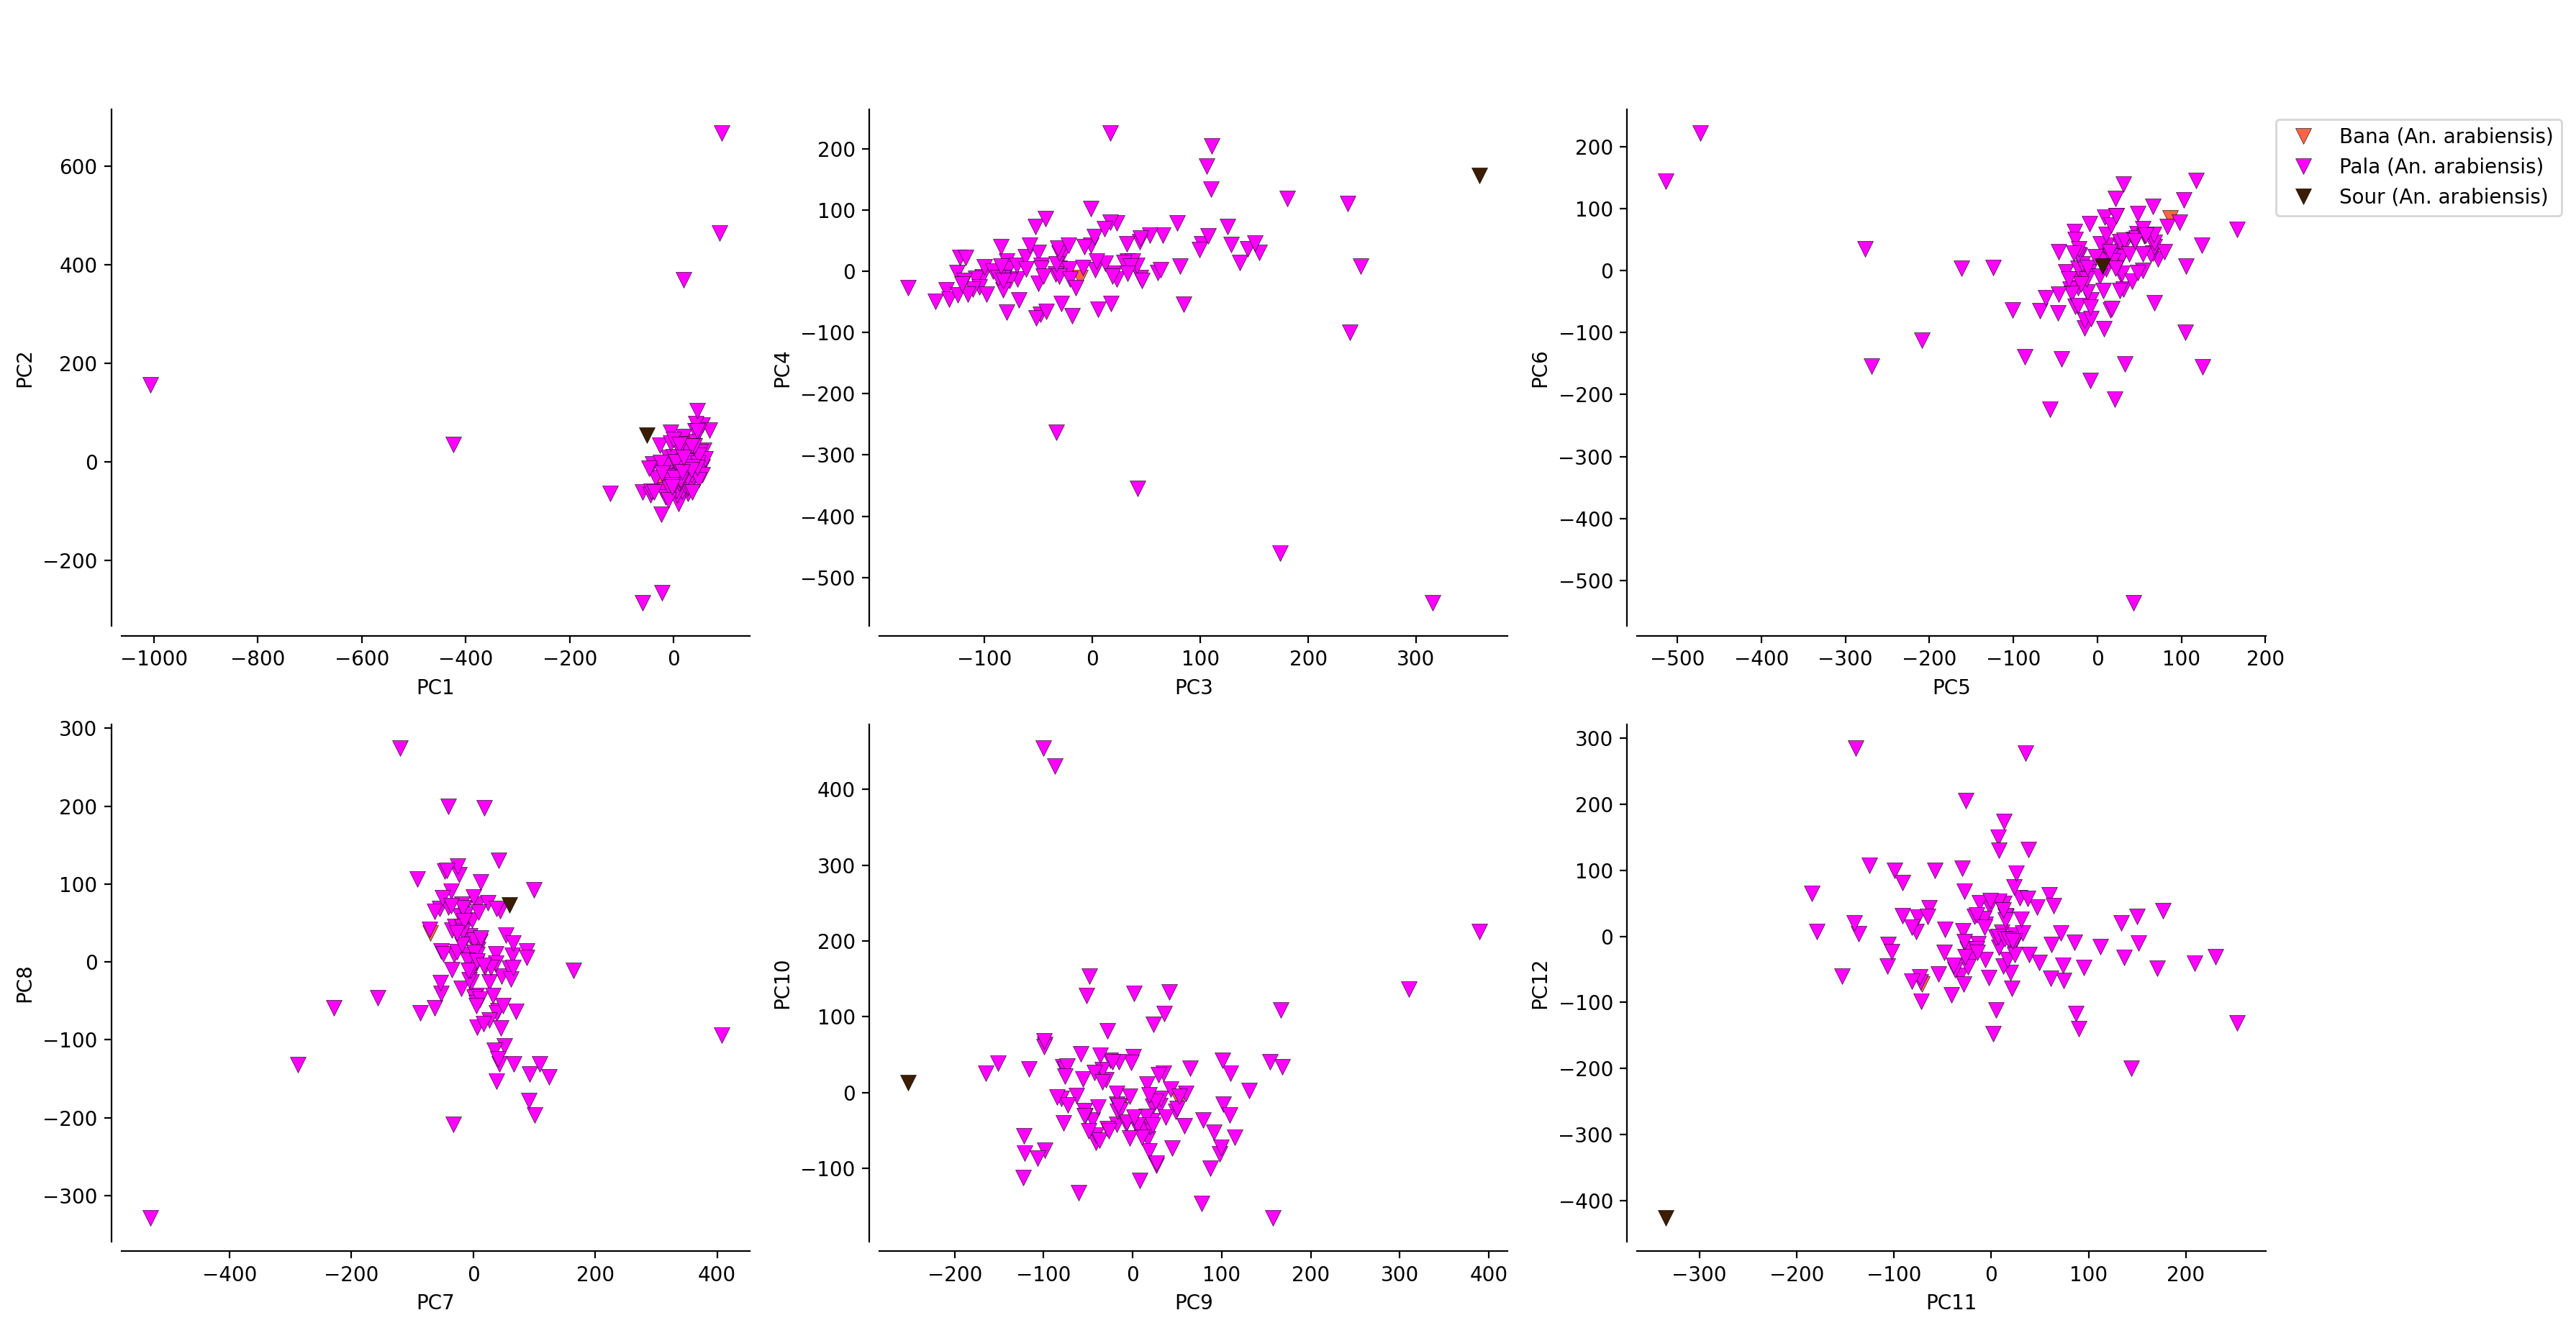

In [80]:
fig_pca(coords=coords_ara, model=model_ara.explained_variance_ratio_ , title=' ', ls=ara_ls1, pop_id=ara_pop_ids,
        pop_color=ara_pop_color, sample_population=ara_samples.population.values, fig_name='PCA_3L_An_arabiensis')

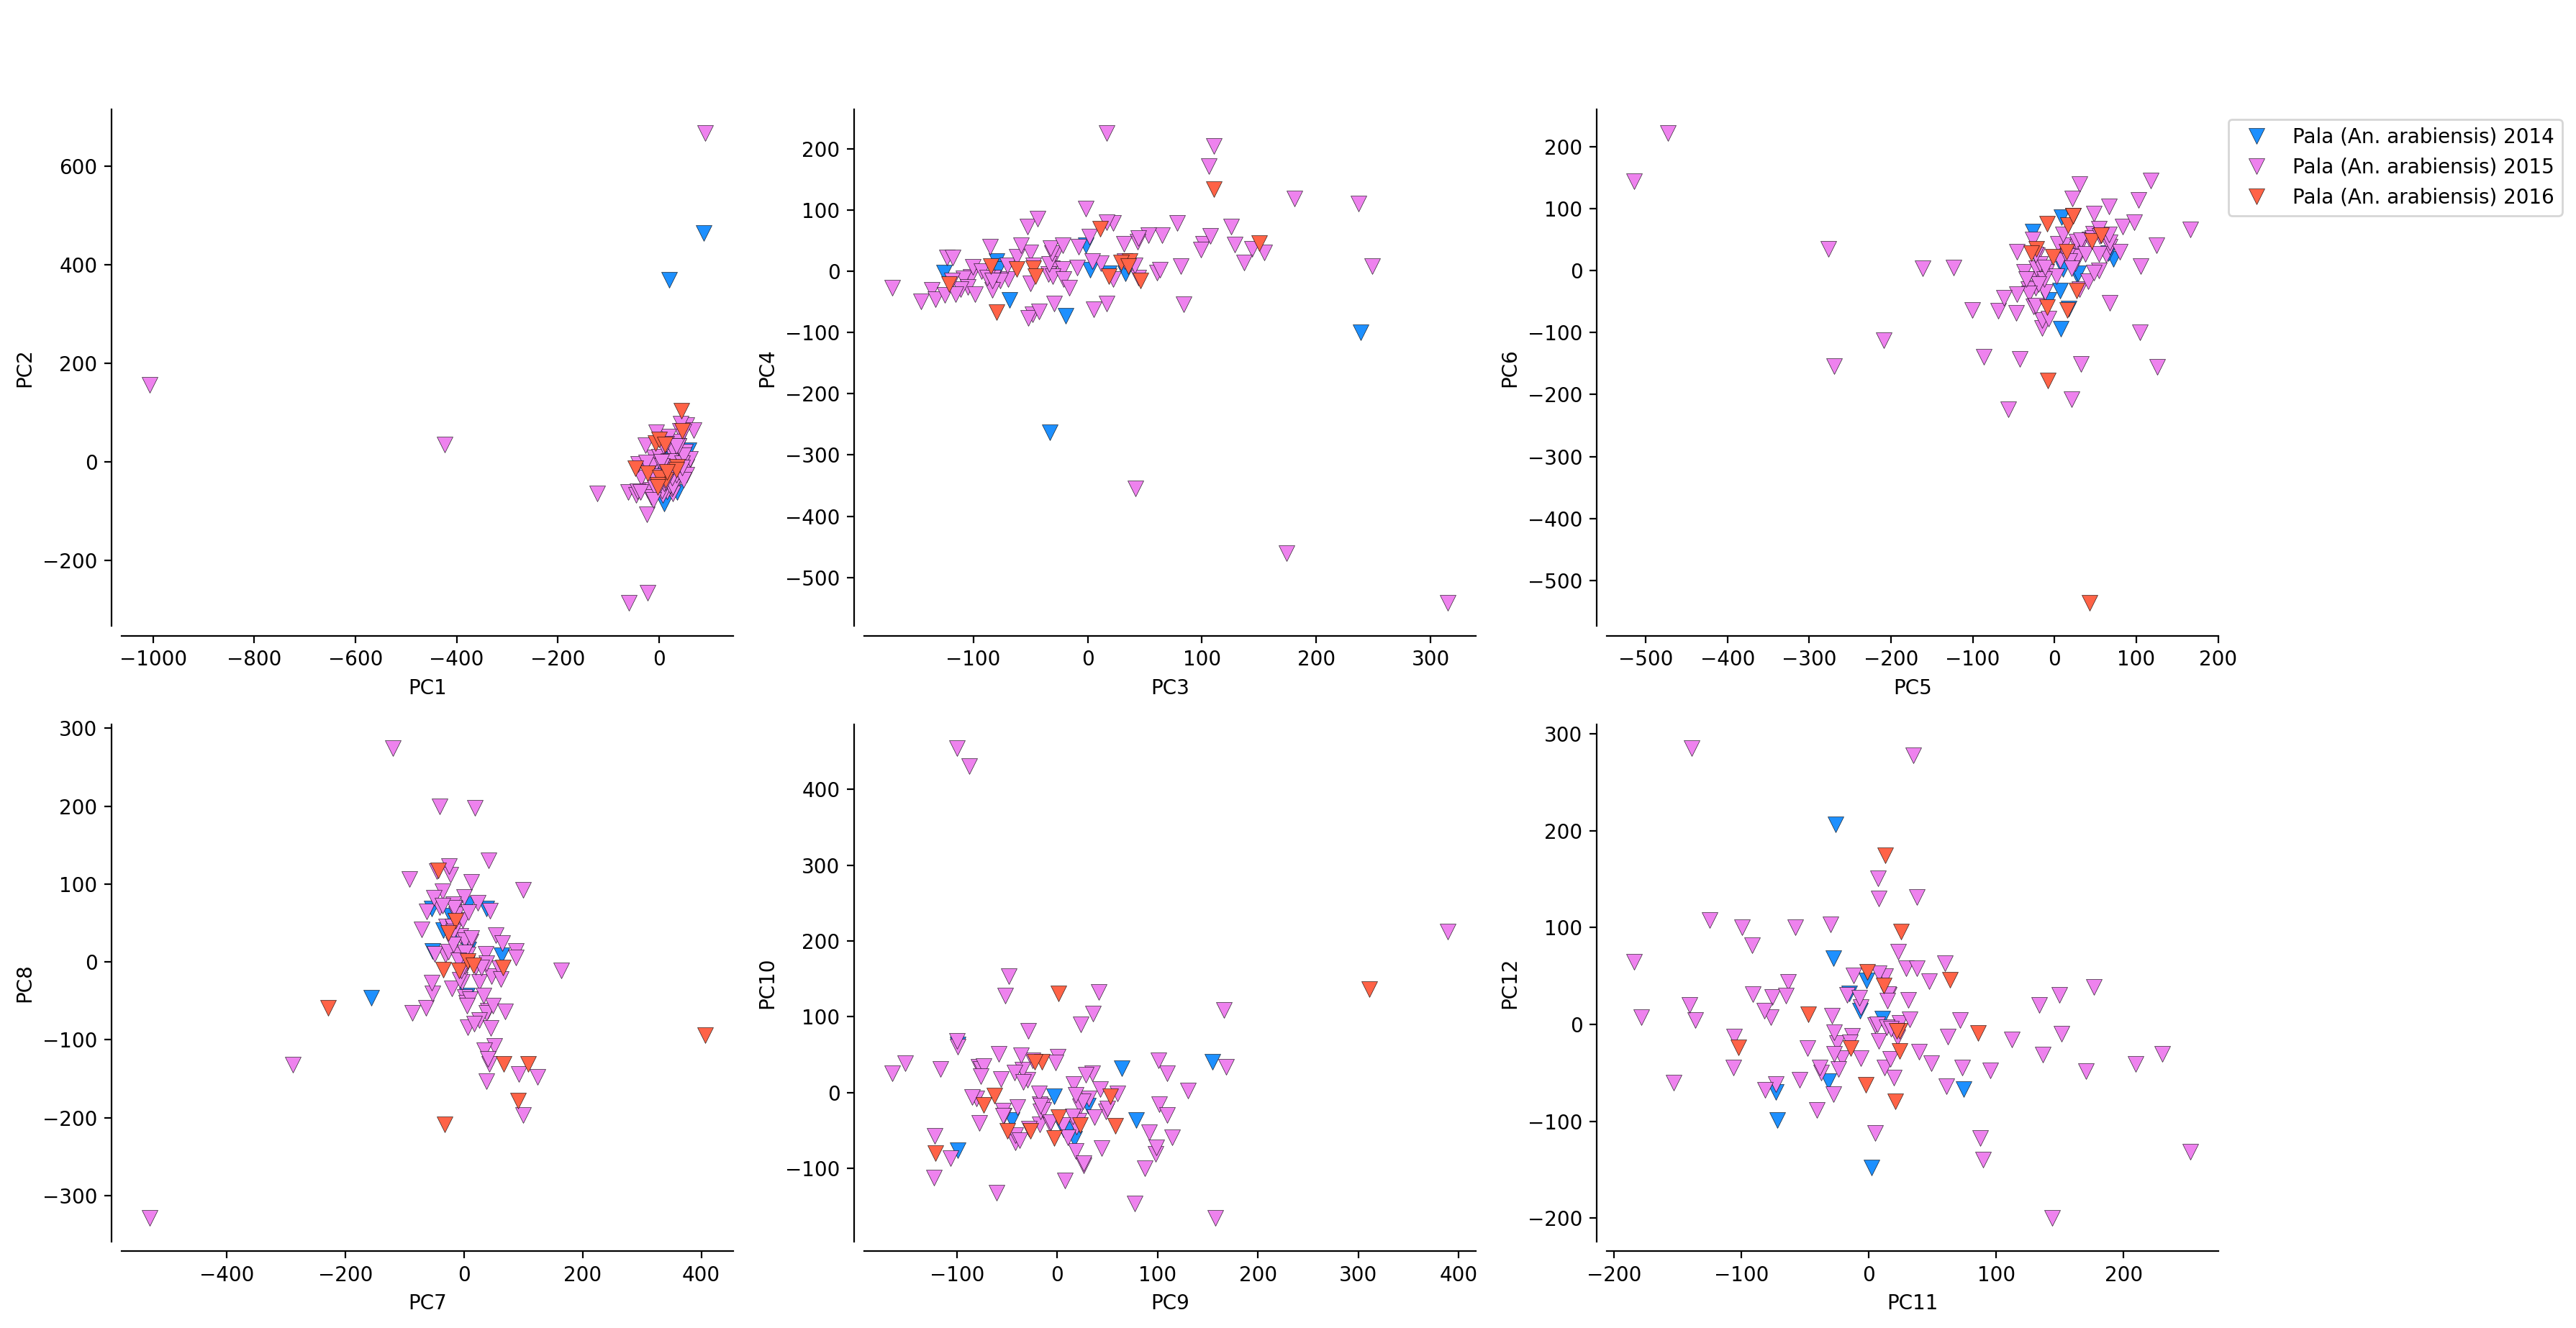

In [81]:
fig_pca(coords=coords_ara, model=model_ara.explained_variance_ratio_ , title=' ', ls=ara_ls2, pop_id=ara_pop_ids1,
        pop_color=ara_pop_color1, sample_population=ara_samples.pop_year.values, fig_name='PCA_3L_An_arabiensis_y')

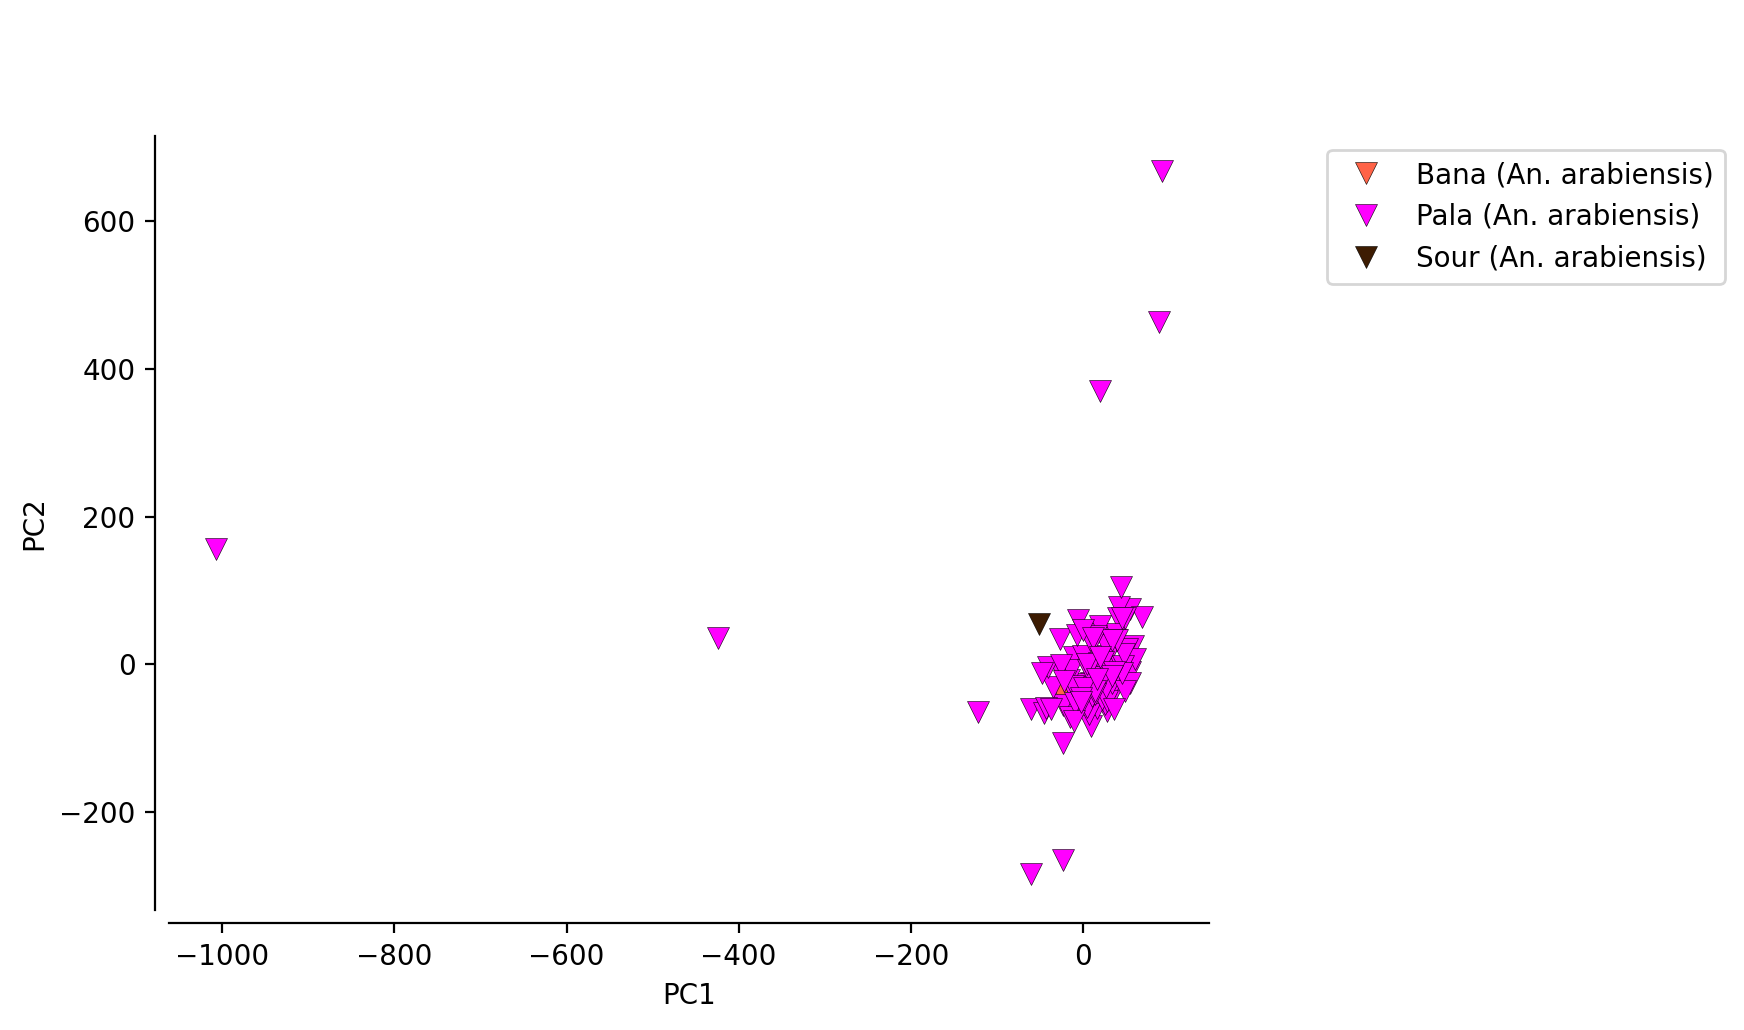

In [82]:
fig_pca1_2(coords=coords_ara, model=model_ara.explained_variance_ratio_ , title=' ', ls=ara_ls1, pop_id=ara_pop_ids,
           pop_color=ara_pop_color, sample_population=ara_samples.population.values, fig_name='PCA1,2_3L_An_arabiensis')

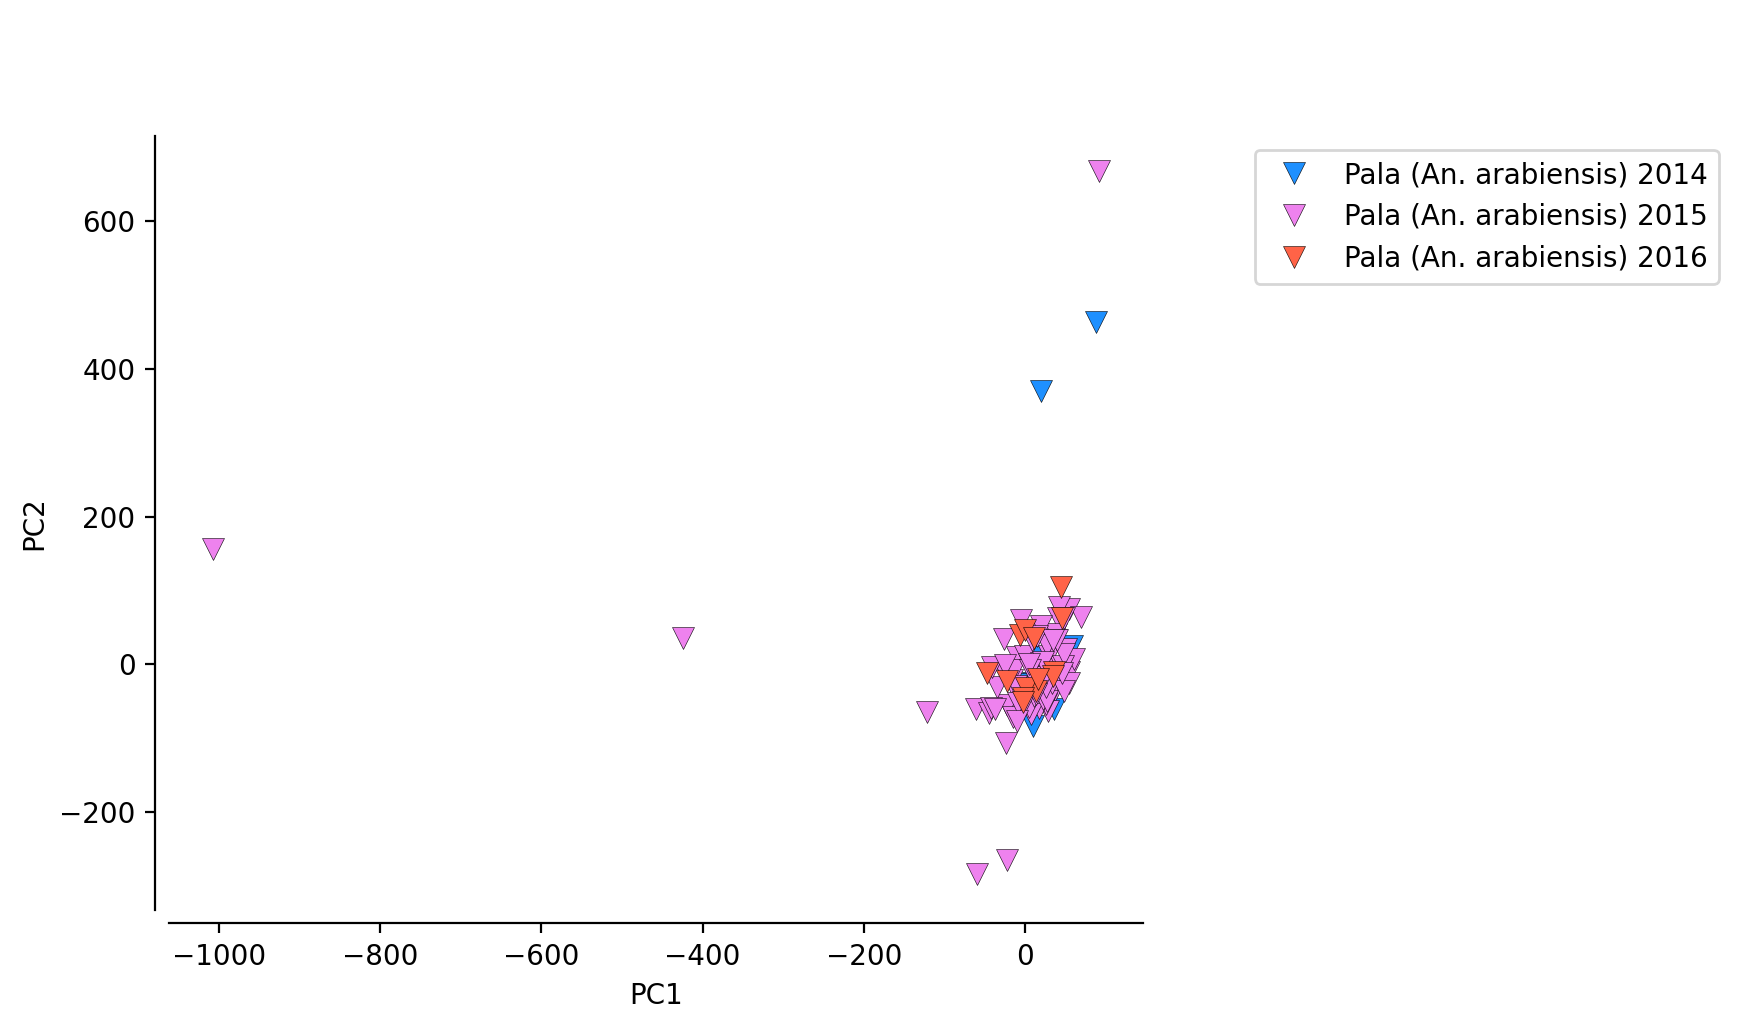

In [83]:
fig_pca1_2(coords=coords_ara, model=model_ara.explained_variance_ratio_ , title=' ', ls=ara_ls2, pop_id=ara_pop_ids1,
           pop_color=ara_pop_color1, sample_population=ara_samples.pop_year.values, fig_name='PCA1,2_3L_An_arabiensis_y')

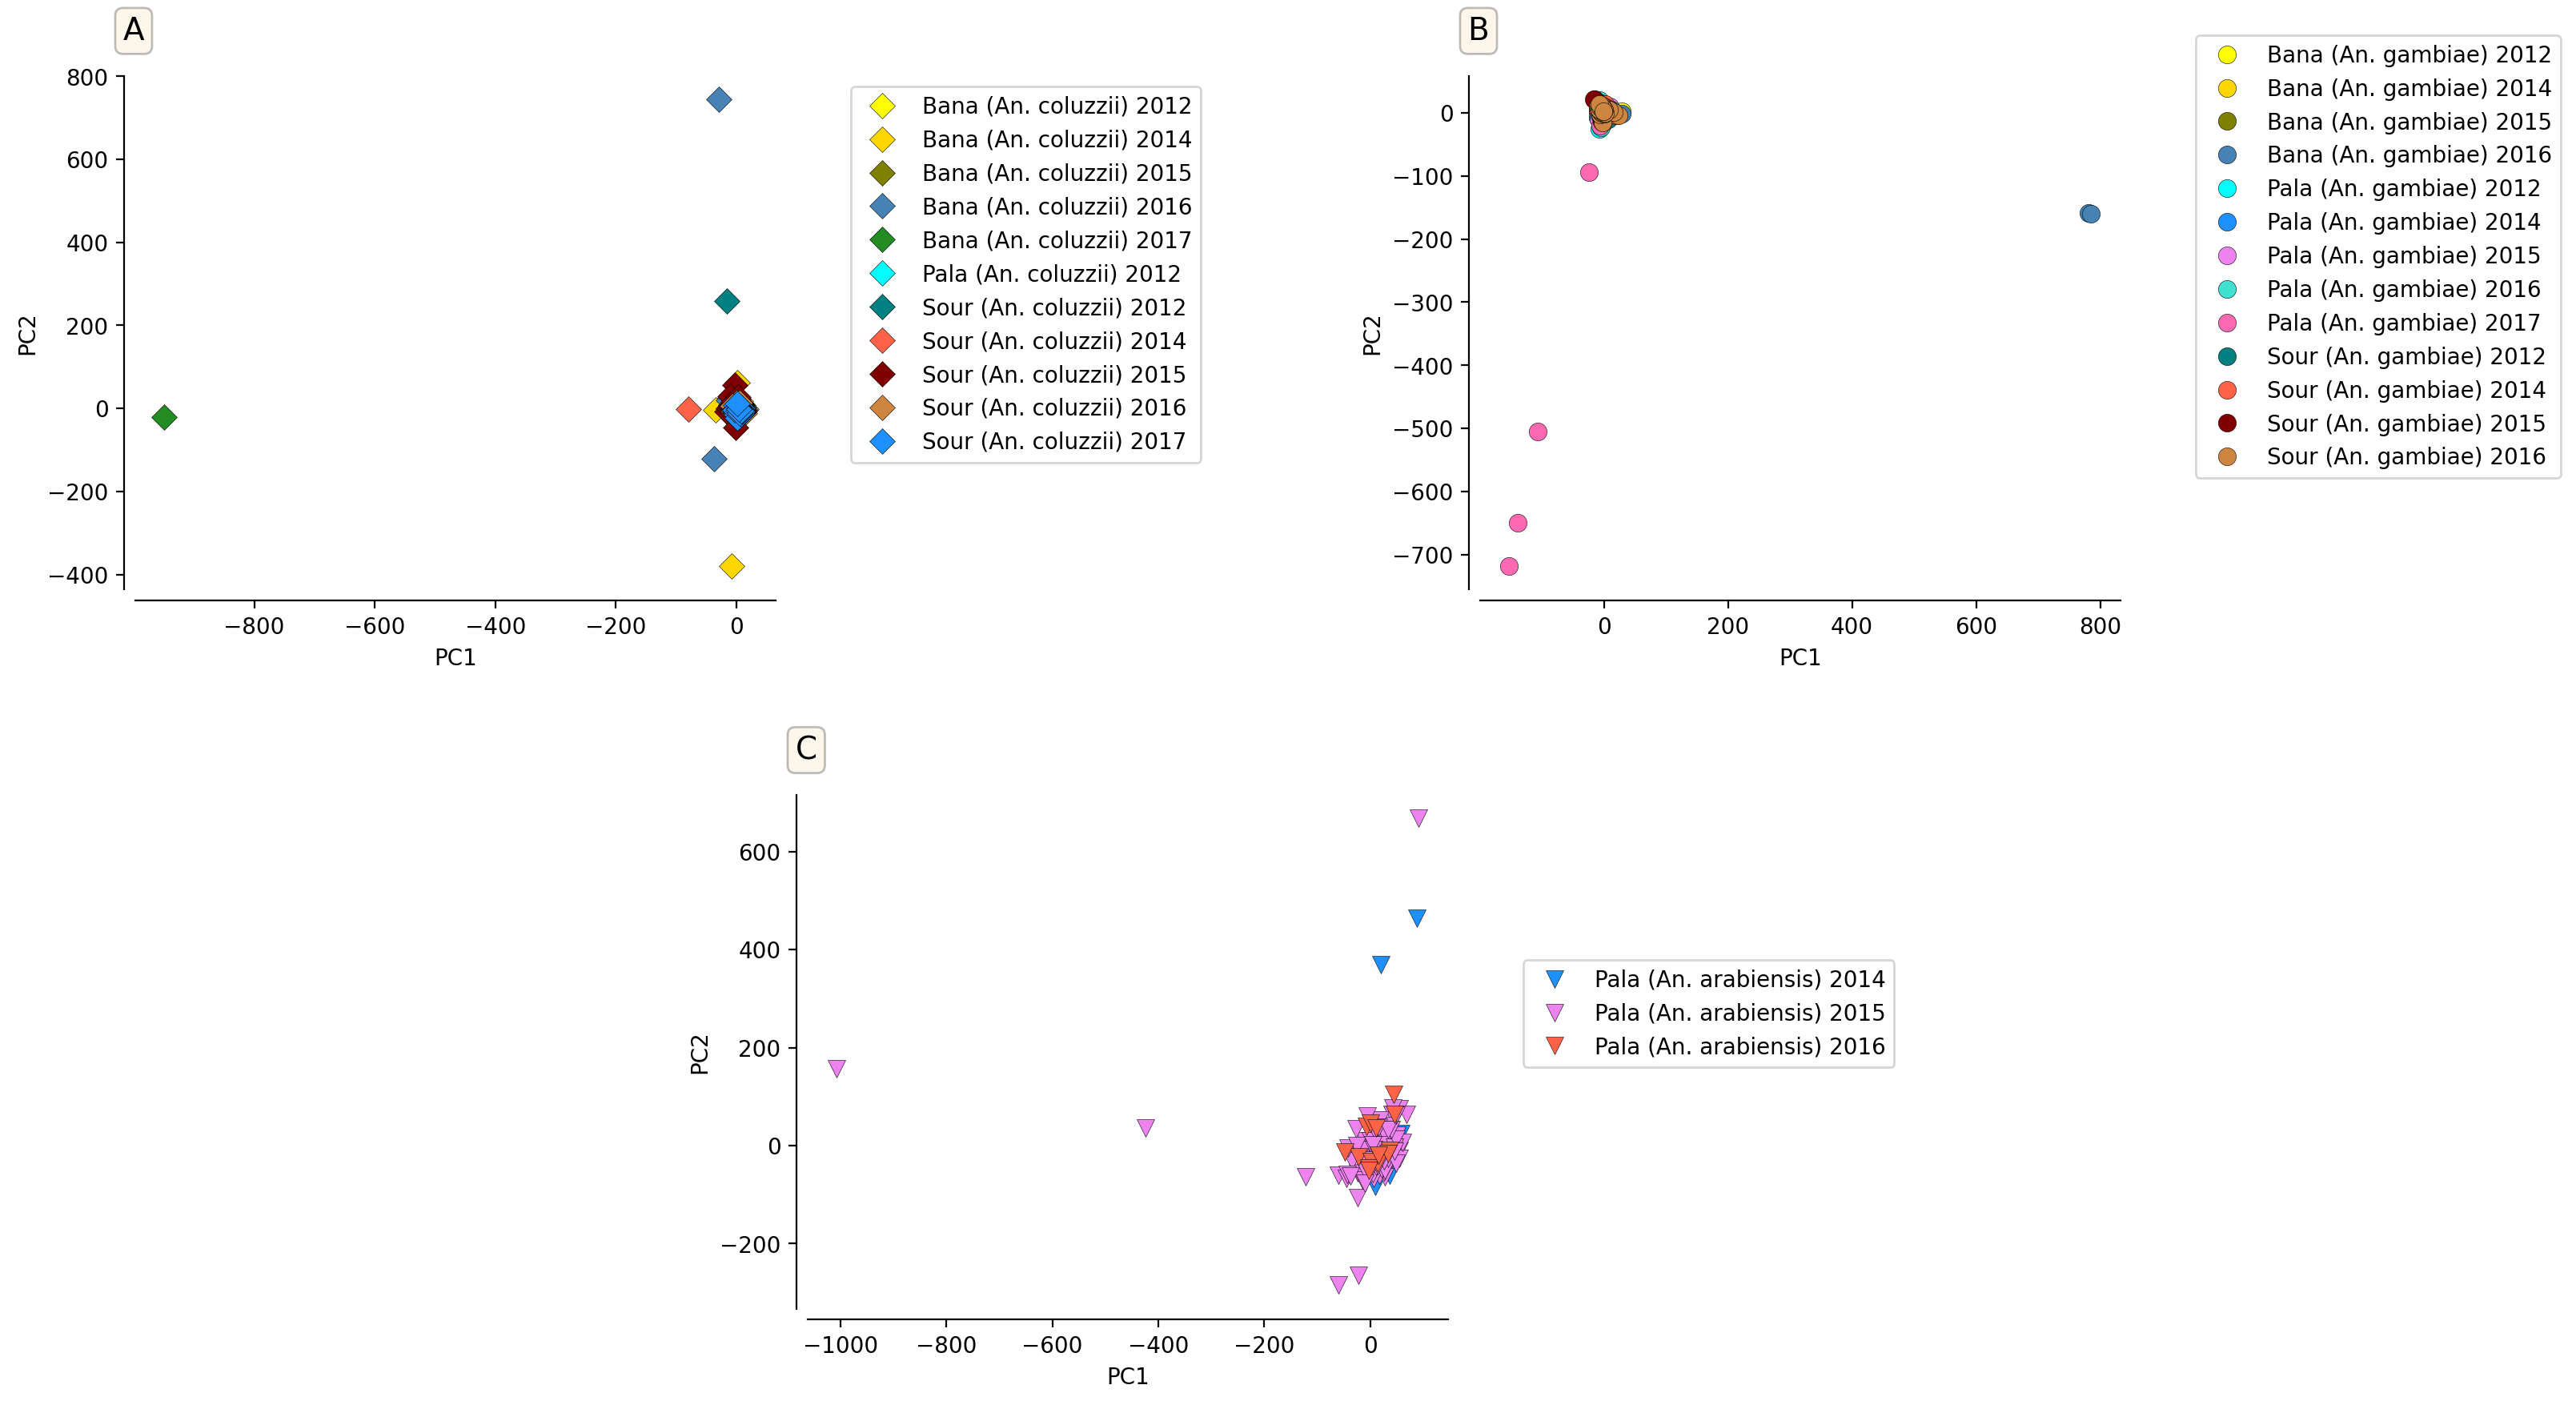

In [84]:
fig = plt.figure(figsize=(16, 10))

ax = fig.add_subplot(231)
plot_pca_coords(coords_col, model_col.explained_variance_ratio_, 0, 1, ax, col_ls2, col_pop_ids1, col_pop_color1,
                col_samples.pop_year.values)
ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
ax.text(-0.019, 1.07, 'A', transform=ax.transAxes, size=14,
         bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

ax = fig.add_subplot(233)
plot_pca_coords(coords_gamb, model_gamb.explained_variance_ratio_, 0, 1, ax, gam_ls2, gam_pop_ids1, gam_pop_color1,
                gam_samples.pop_year.values)
ax.legend(bbox_to_anchor=(1.1, 1.1), loc='upper left')
ax.text(-0.019, 1.07, 'B', transform=ax.transAxes, size=14,
        bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

fig.subplots_adjust(wspace=0.05, hspace=0.4)
ax = fig.add_subplot(235)
plot_pca_coords(coords_ara, model_ara.explained_variance_ratio_, 0, 1, ax, ara_ls2, ara_pop_ids1, ara_pop_color1,
                ara_samples.pop_year.values)
ax.legend(bbox_to_anchor=(1.1, 0.7), loc='upper left')
ax.text(-0.019, 1.07, 'C', transform=ax.transAxes, size=14,
        bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

fig.savefig(f"drive/MyDrive/Genomic/PCA/PCAY12.png", dpi=300, bbox_inches='tight', transparent=False)
plt.show()

In [53]:
fig_pca1_2(coords=coords_gamb, model=model_gamb.explained_variance_ratio_ , title=' ', ls=gam_ls2, pop_id=gam_pop_ids1,
           pop_color=gam_pop_color1, sample_population=gam_samples.pop_year.values, fig_name='PCA1,2_3L_An_gambiae_y')

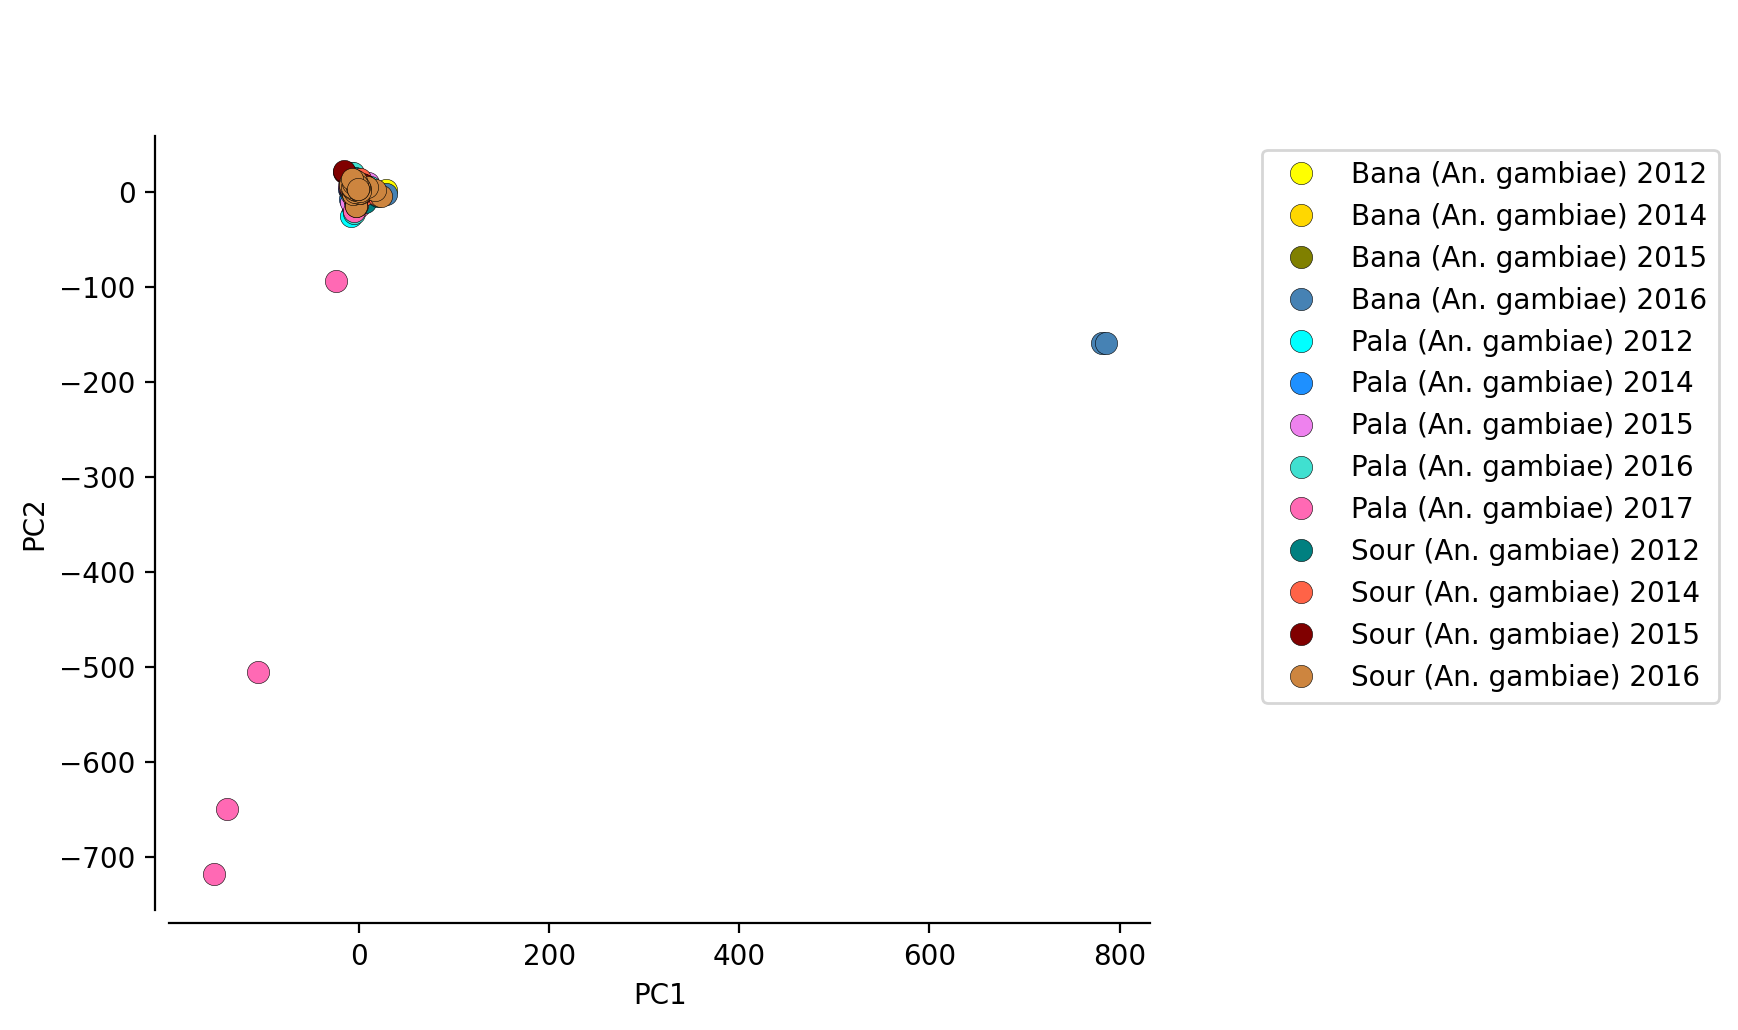

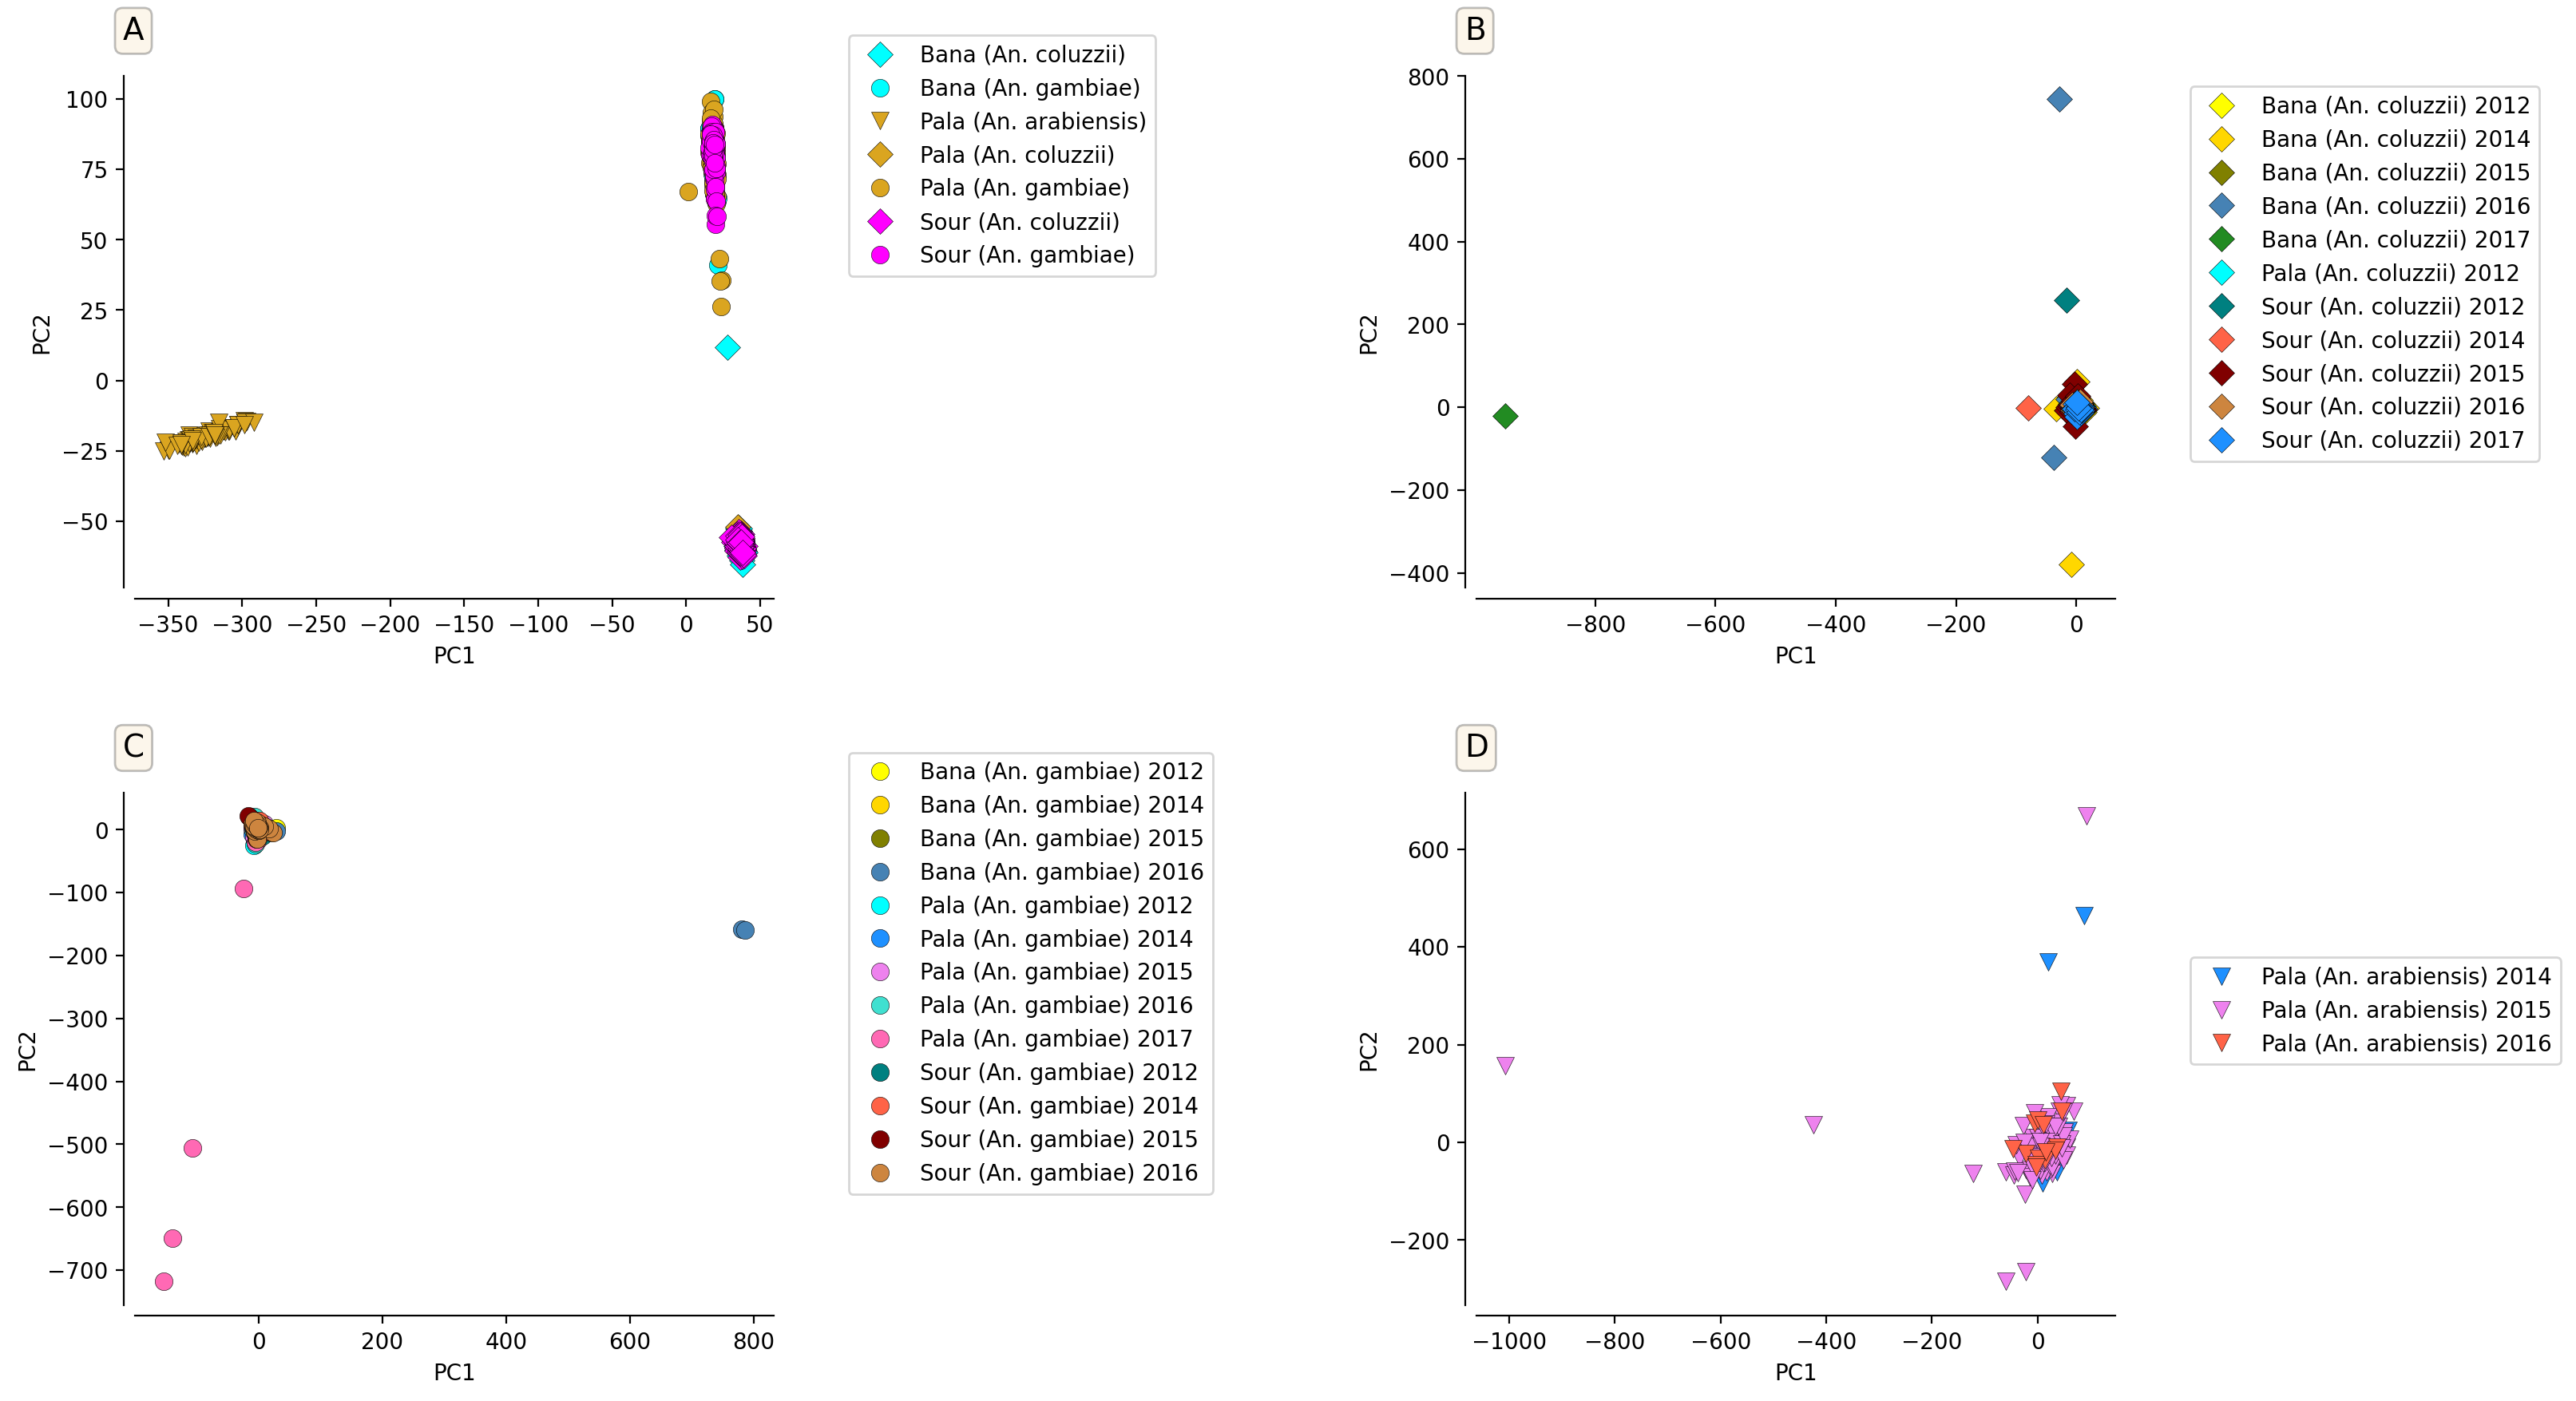

In [54]:
fig = plt.figure(figsize=(16, 10))

ax = fig.add_subplot(231)
plot_pca_coords(coords_3L, model_3L.explained_variance_ratio_, 0, 1, ax, ls1, pop_ids, pop_color, bf_samples.population.values)
ax.legend(bbox_to_anchor=(1.1, 1.1), loc='upper left', fontsize=10)
ax.text(-0.019, 1.07, 'A', transform=ax.transAxes, size=14,
        bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

ax = fig.add_subplot(233)
plot_pca_coords(coords_col, model_col.explained_variance_ratio_, 0, 1, ax, col_ls2, col_pop_ids1, col_pop_color1,
                col_samples.pop_year.values)
ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
ax.text(-0.019, 1.07, 'B', transform=ax.transAxes, size=14,
         bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

ax = fig.add_subplot(234)
plot_pca_coords(coords_gamb, model_gamb.explained_variance_ratio_, 0, 1, ax, gam_ls2, gam_pop_ids1, gam_pop_color1,
                gam_samples.pop_year.values)
ax.legend(bbox_to_anchor=(1.1, 1.1), loc='upper left')
ax.text(-0.019, 1.07, 'C', transform=ax.transAxes, size=14,
        bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

fig.subplots_adjust(wspace=0.05, hspace=0.4)
ax = fig.add_subplot(236)
plot_pca_coords(coords_ara, model_ara.explained_variance_ratio_, 0, 1, ax, ara_ls2, ara_pop_ids1, ara_pop_color1,
                ara_samples.pop_year.values)
ax.legend(bbox_to_anchor=(1.1, 0.7), loc='upper left')
ax.text(-0.019, 1.07, 'D', transform=ax.transAxes, size=14,
        bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

fig.savefig(f"drive/MyDrive/Genomic/PCA/all_PCAY12.png", dpi=300, bbox_inches='tight', transparent=False)
plt.show()